In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import keras
from keras.layers import Input, Dense, Add
from keras.utils.vis_utils import plot_model

from numpy.linalg import norm
import pandas as pd

import sklearn.metrics

from keras import regularizers as l 

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

import os

from matplotlib.ticker import FormatStrFormatter

In [ ]:
print(os.getcwd())

/content/drive/MyDrive/Tesis Maestría /Codigos depurados


In [ ]:
os.chdir('/content/drive/MyDrive/Tesis Maestría /Codigos depurados')
print(os.getcwd())

/content/drive/MyDrive/Tesis Maestría /Codigos depurados


In [ ]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
def load_data():
  mnist = keras.datasets.mnist
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train, X_test = X_train / 255.0, X_test / 255.0
  X_train = X_train.reshape(len(y_train),784)
  X_test  = X_test.reshape(len(y_test),784)

  y_train_onehot = keras.utils.to_categorical(y_train)
  y_test_onehot =  keras.utils.to_categorical(y_test)

  print(f'Conjunto de datos cargados')
  print(f'Tamaño imágenes de entrenamiento {X_train[:10000].shape}')
  print(f'Tamaño imágenes de test {X_test.shape}')
  print(f'Datos por cada etiqueta en X train {np.bincount(y_train[:10000])}')
  return X_train[:10000], X_test, y_train_onehot[:10000], y_test_onehot, y_train[:10000], y_test

In [ ]:
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = load_data()

Conjunto de datos cargados
Tamaño imágenes de entrenamiento (10000, 784)
Tamaño imágenes de test (10000, 784)
Datos por cada etiqueta en X train [1001 1127  991 1032  980  863 1014 1070  944  978]


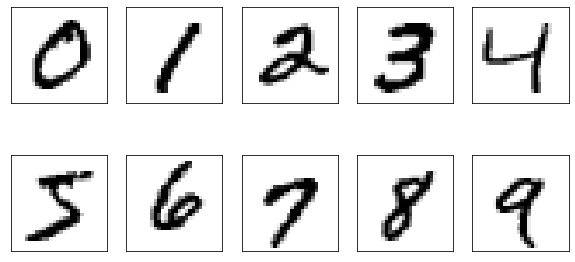

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))

ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='gist_yarg')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()

## Modelo con $n$ saltos residuales

In [ ]:
def skip_conection(dense_input, n, regular_l):
  if n >= 2:
    resDense = Dense(20, activation ='relu', kernel_regularizer=l.l2(regular_l))(dense_input)
    return skip_conection(Add()([dense_input, resDense]), n-1, regular_l)
  resDenseo = Dense(20, activation ='relu', kernel_regularizer=l.l2(regular_l))(dense_input)
  return Add()([dense_input, resDenseo])

In [ ]:
def load_model(n, regular_l):
  keras.backend.clear_session()
  inputs  = Input(shape=(784,))
  dense1  = Dense(20, activation  ='relu', kernel_regularizer=l.l2(regular_l))(inputs)
  
  skip_final = skip_conection(dense1, n, regular_l)

  outputs = Dense(10, activation='softmax', kernel_regularizer=l.l2(regular_l))(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=100, shuffle=True):
        super().__init__()
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
        self.on_epoch_end()

    def __len__(self):
        return len(self.key_array)//self.batch_size

    def __getitem__(self, index):
        keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]
        x = np.asarray(self.images[keys], dtype=np.float32)
        y = np.asarray(self.labels[keys], dtype=np.float32)
      
        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            self.key_array = np.random.permutation(self.key_array)

In [ ]:
generator = DataGenerator(images=X_train, labels=y_train, batch_size=100, shuffle=True)
n_batches = len(generator)
n_batches

100

In [ ]:
def lipschitz_bound(modelWeigts):
  numberLayers = len(modelWeigts)
  LipsBound = np.linalg.norm(modelWeigts[0], ord=2)     # Norma espectral (2) capa 1
  if LipsBound == 0: LipsBound = 1

  for rc in np.arange(2,numberLayers-2,2):              # En los indices de las capas residuales
    try: 
      LipsBound *= (1 + np.linalg.norm(modelWeigts[rc], ord=2))
    except:
      LipsBound *= 1
  
  LipsBound *= np.linalg.norm(modelWeigts[numberLayers-2], ord=2) # Capa de salida

  return  LipsBound

##  Funciones graficar 

In [ ]:
def graphGridAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  plt.yticks(np.arange(0.2, 1.1, step=0.1))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ precisión entrenamiento',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ precisión validación',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'Precisión',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.ylim(top=1)
  plt.grid()
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.tight_layout()
  nameFile = 'presicionModelo' + str(skip) + 'G' +'.pdf'
  plt.savefig(nameFile) 
  #plt.show()



def graphAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  plt.yticks(np.arange(0.2, 1.1, step=0.1))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ precisión entrenamiento',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ precisión validación',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'Precisión',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.ylim(top=1)
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  nameFile = 'presicionModelo' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()


In [ ]:
def graphGridLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  nameFile = 'cotaLipschitzModelo' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelo' + str(skip) +'.pdf'
  plt.savefig(nameFile) 
  #plt.show()

In [ ]:
def graphGridLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelolog' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0),
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  nameFile = 'cotaLipschitzModelolog' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

In [ ]:
def graphGridLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ perdida en entrenamiento', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  plt.grid()
  nameFile = 'funcionPerdidaModelo' + str(skip) + 'G' + '.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ perdida en entrenamiento', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  nameFile = 'funcionPerdidaModelo' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()


## Entrenamiento conjunto de modelos validación cruzada k-fold

Modelo : 2 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
80
80
80
80
Modelo : 4 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
80
80
80
80
Modelo : 6 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
80
80
80
80


<ipython-input-47-dec7ef527fb1>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-47-dec7ef527fb1>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-48-f54571b893d2>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.f

Modelo : 8 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
80
80
80
80


<ipython-input-45-db624e835f03>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-45-db624e835f03>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-46-4227dadd70e7>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.f

Modelo : 10 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
80
80
80
80


<ipython-input-45-db624e835f03>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-45-db624e835f03>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-46-4227dadd70e7>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.f

Modelo : 12 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
80
80
80
80


<ipython-input-45-db624e835f03>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-45-db624e835f03>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-46-4227dadd70e7>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.f

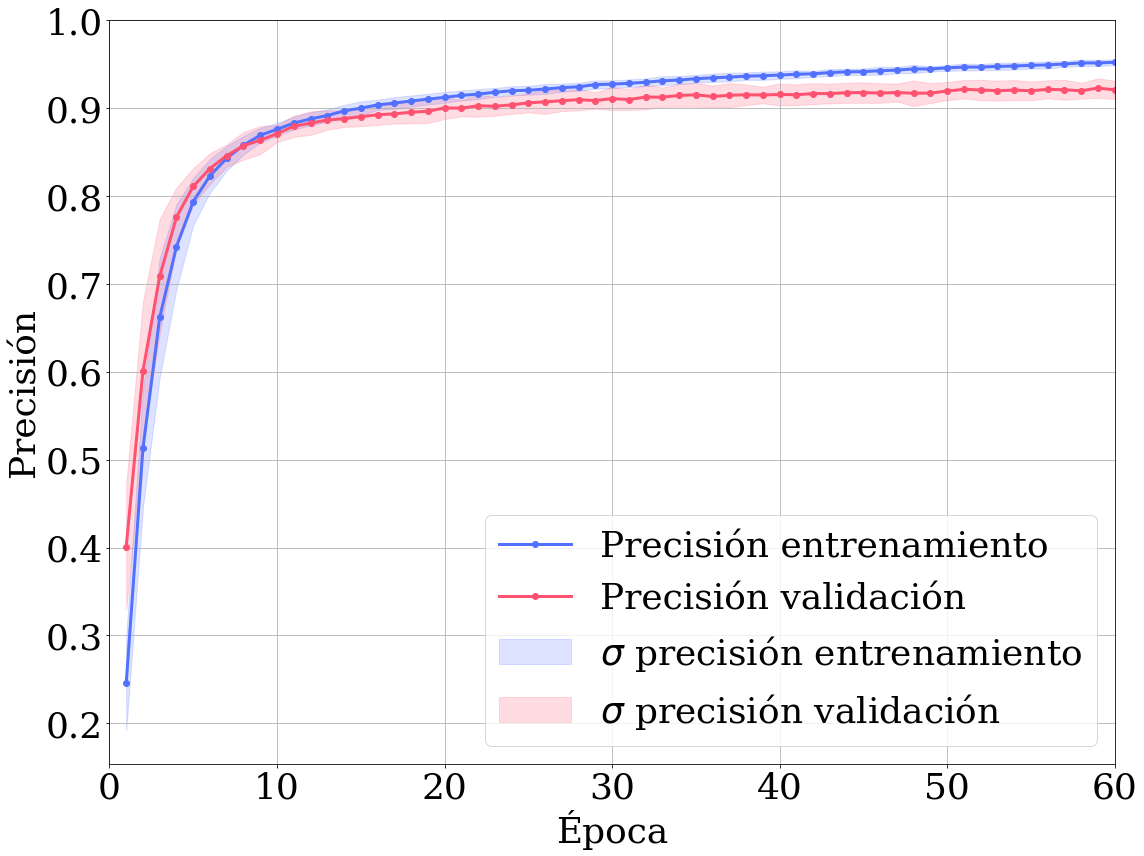

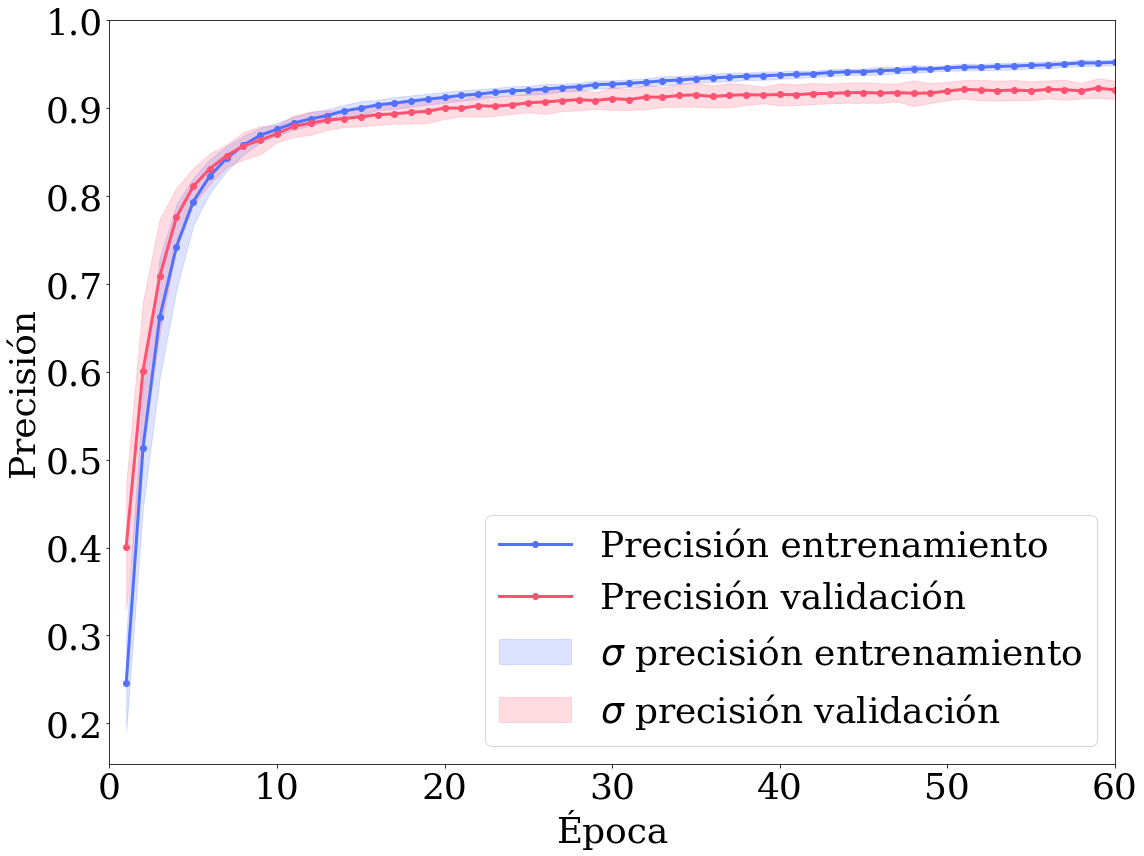

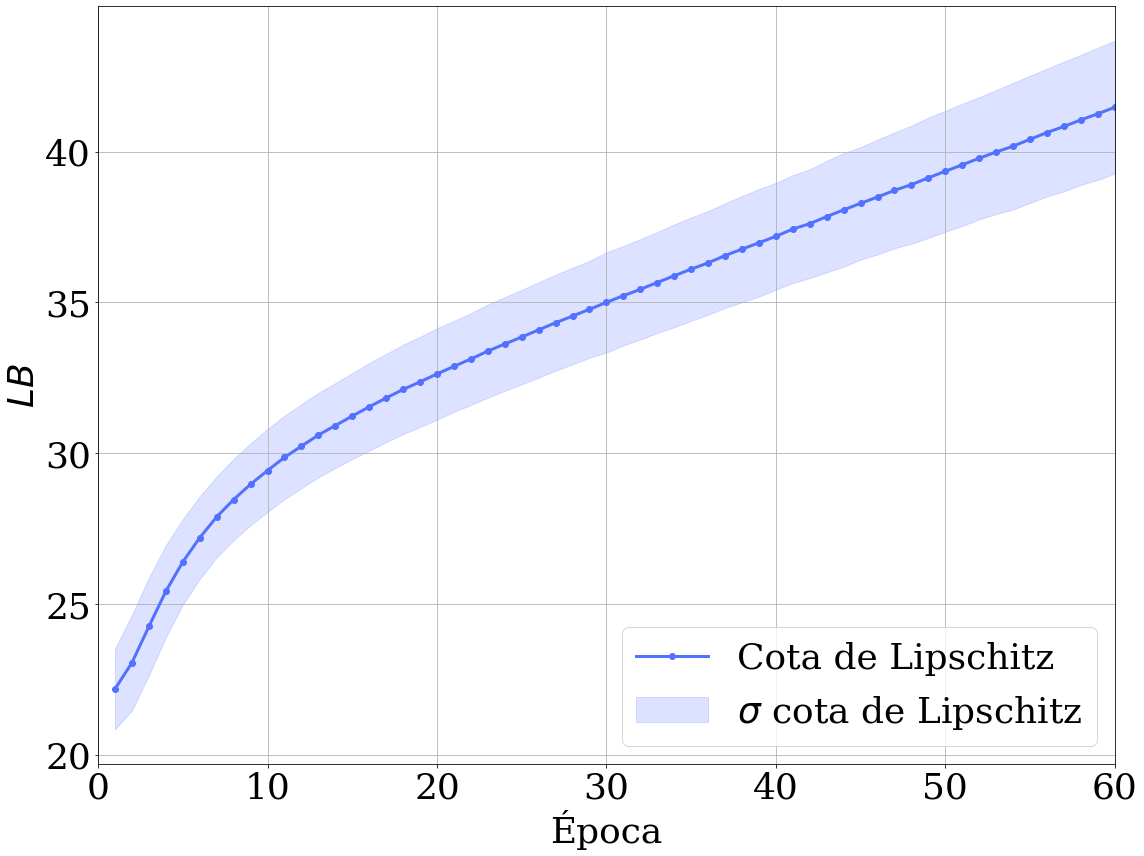

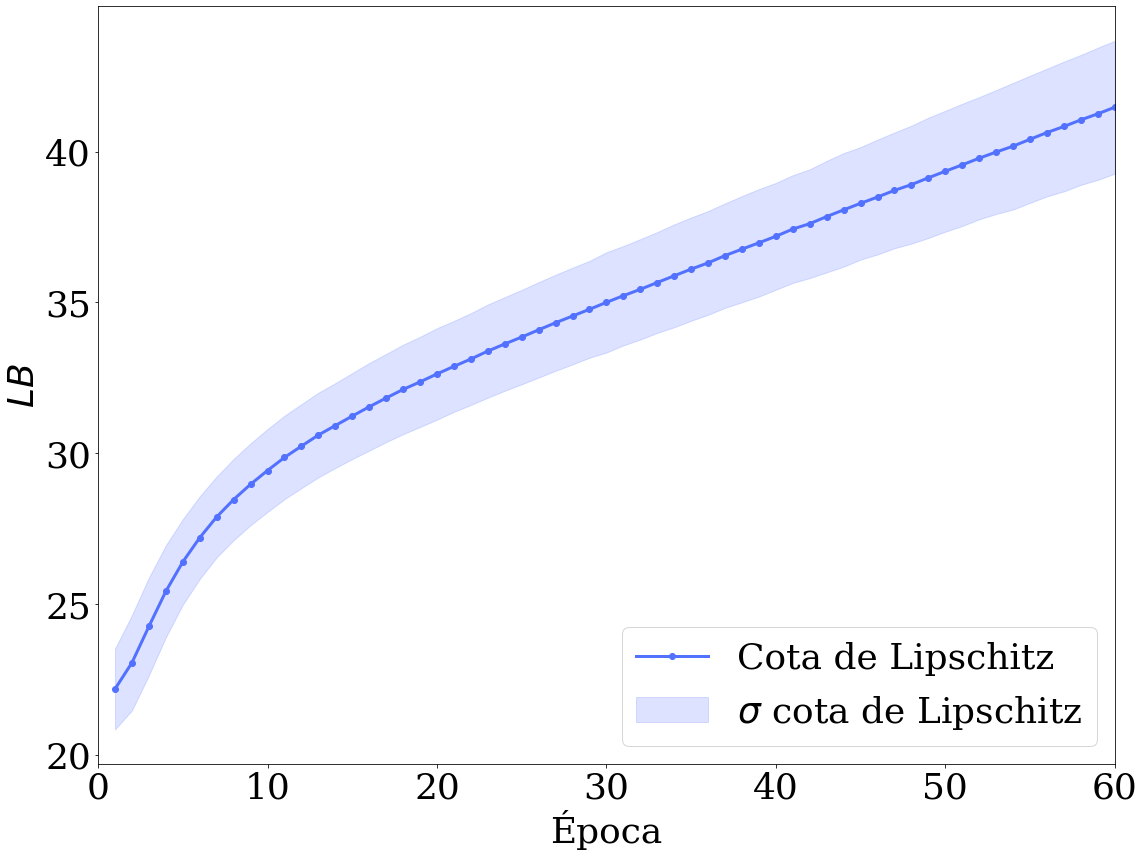

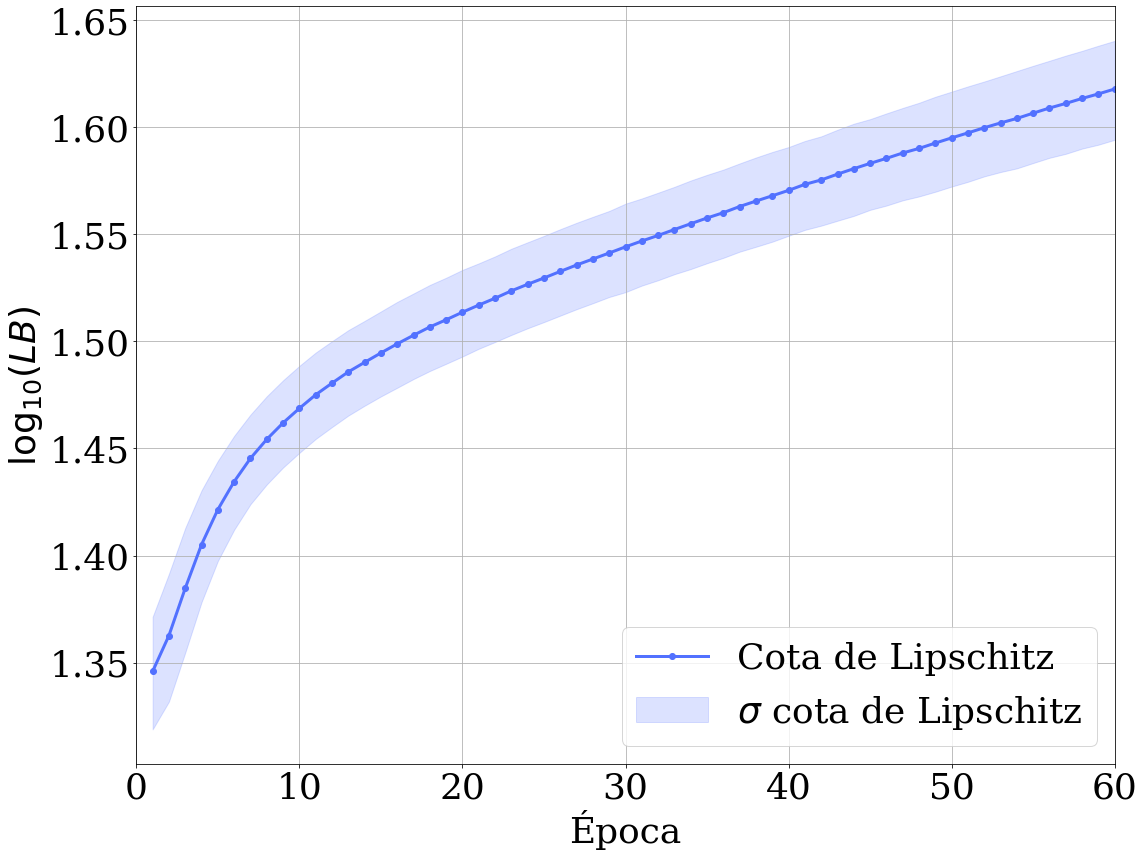

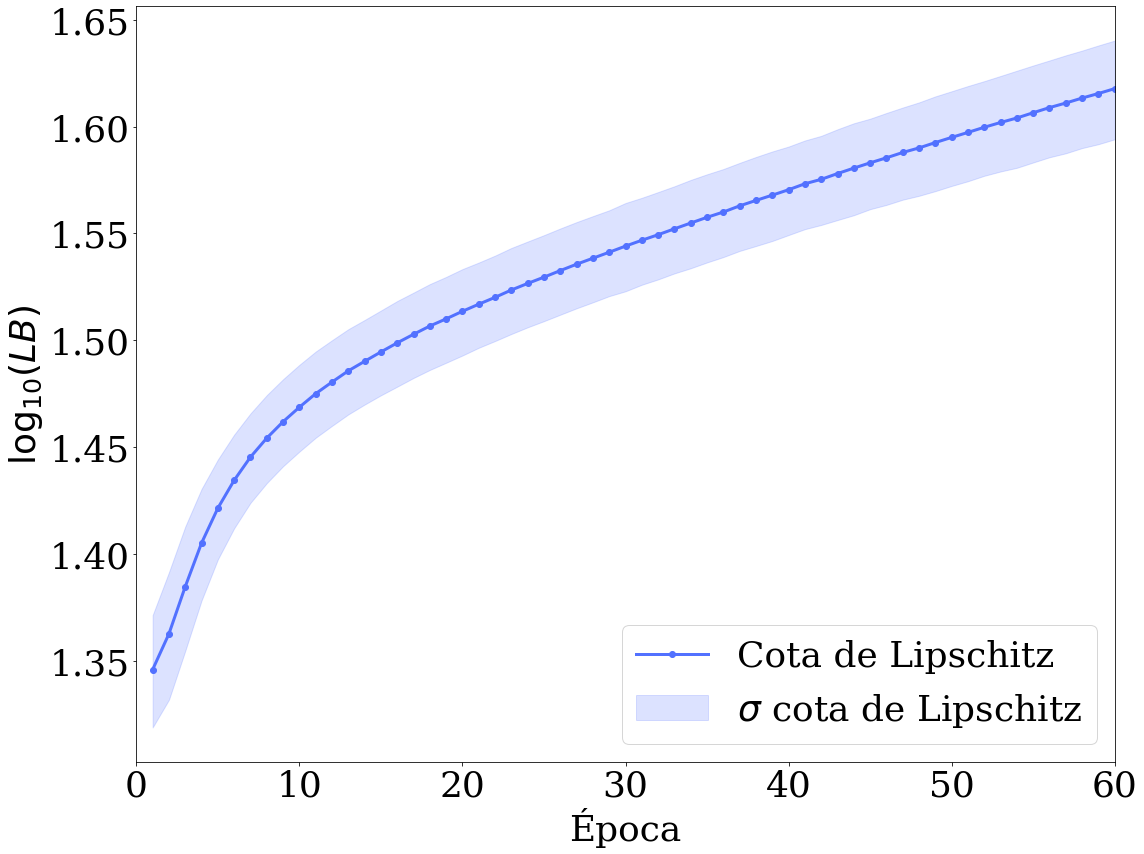

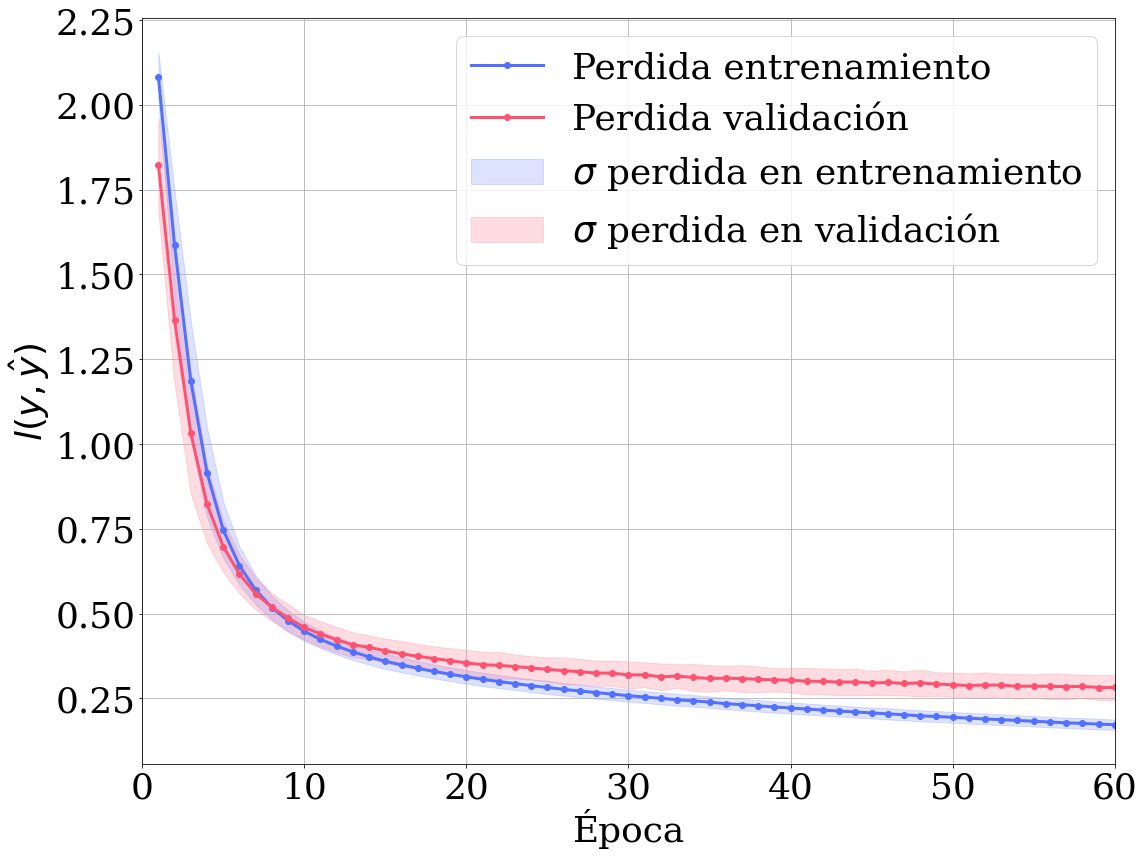

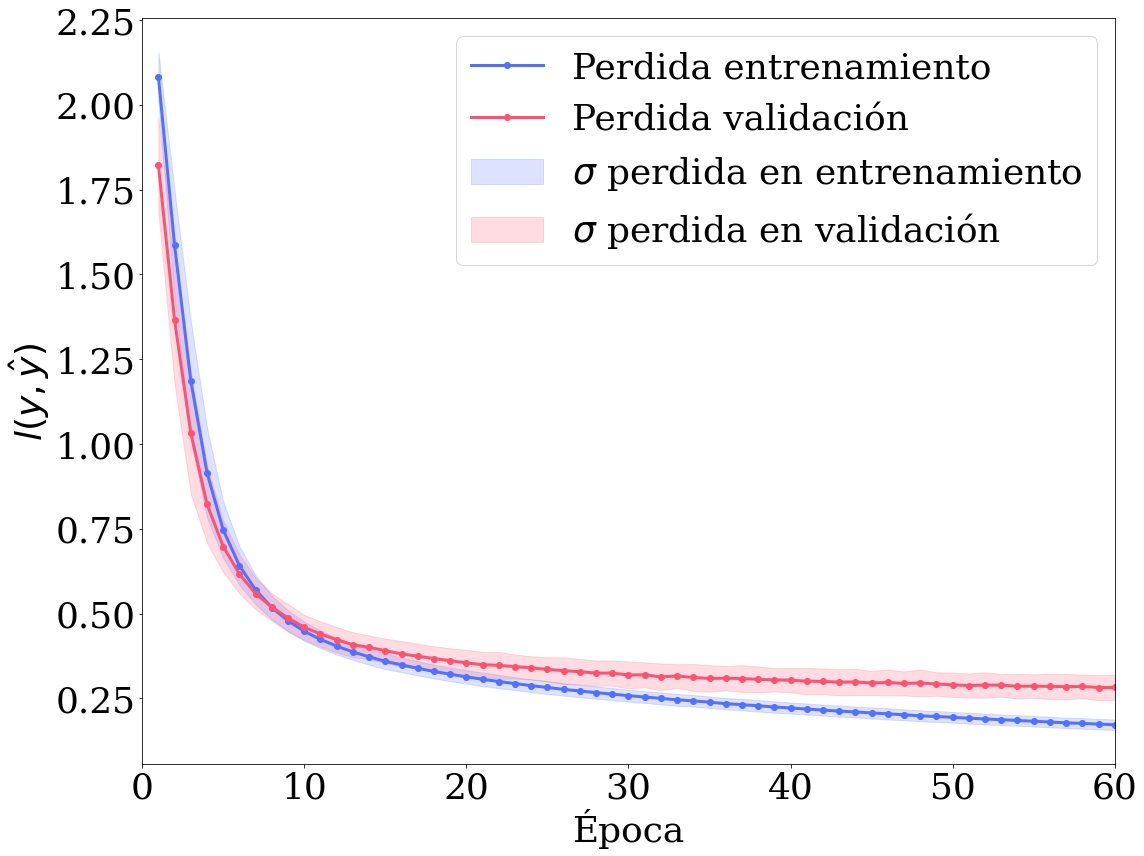

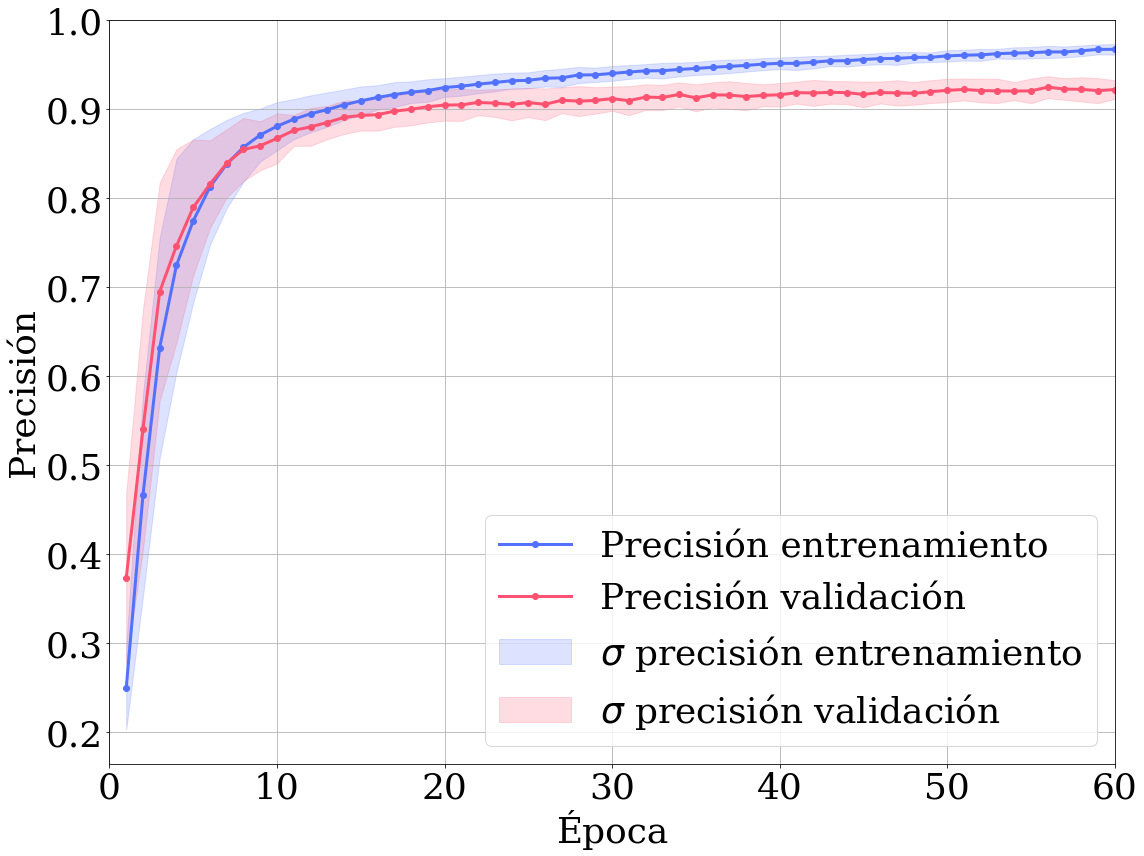

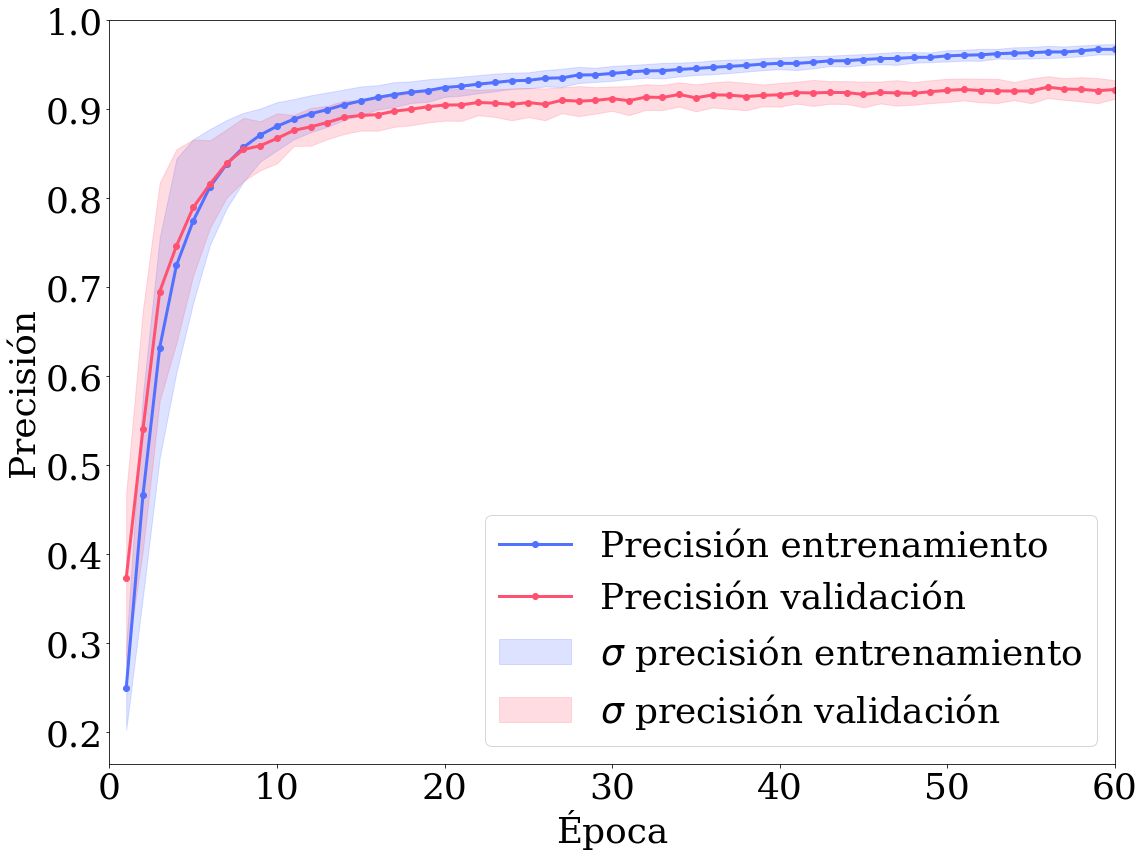

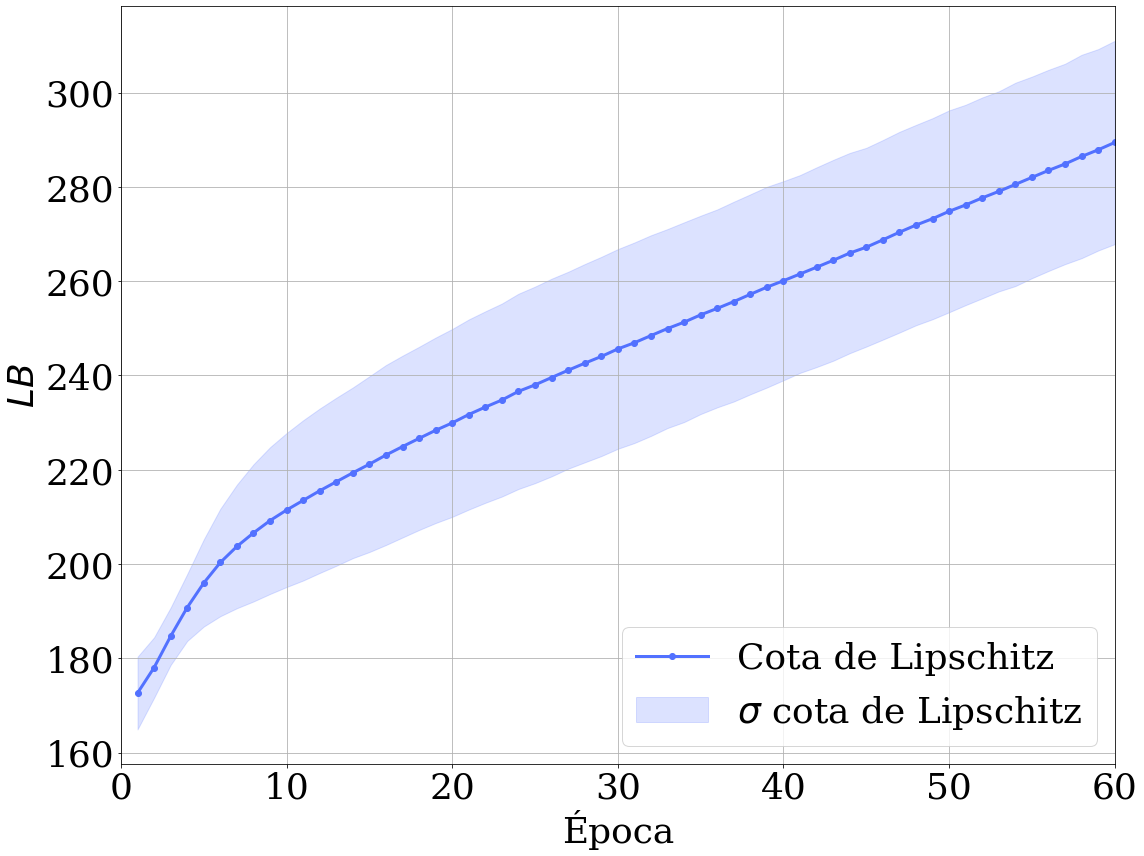

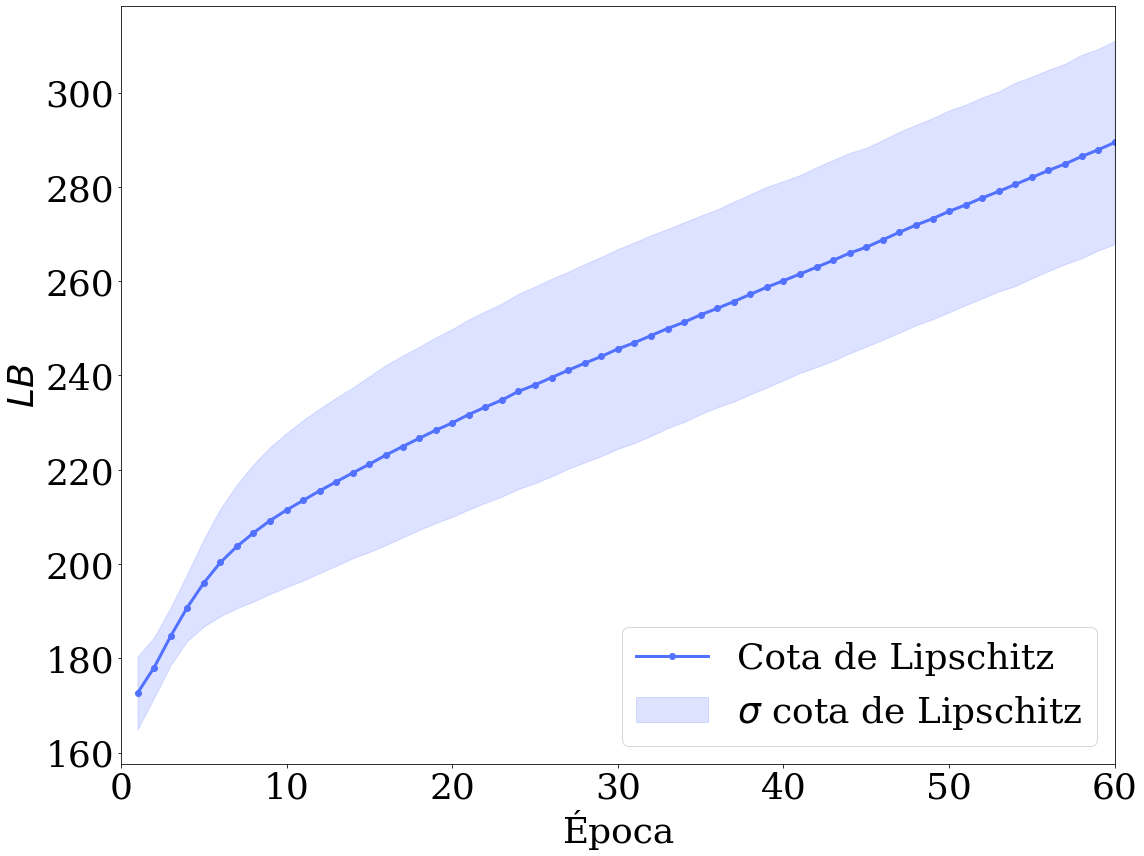

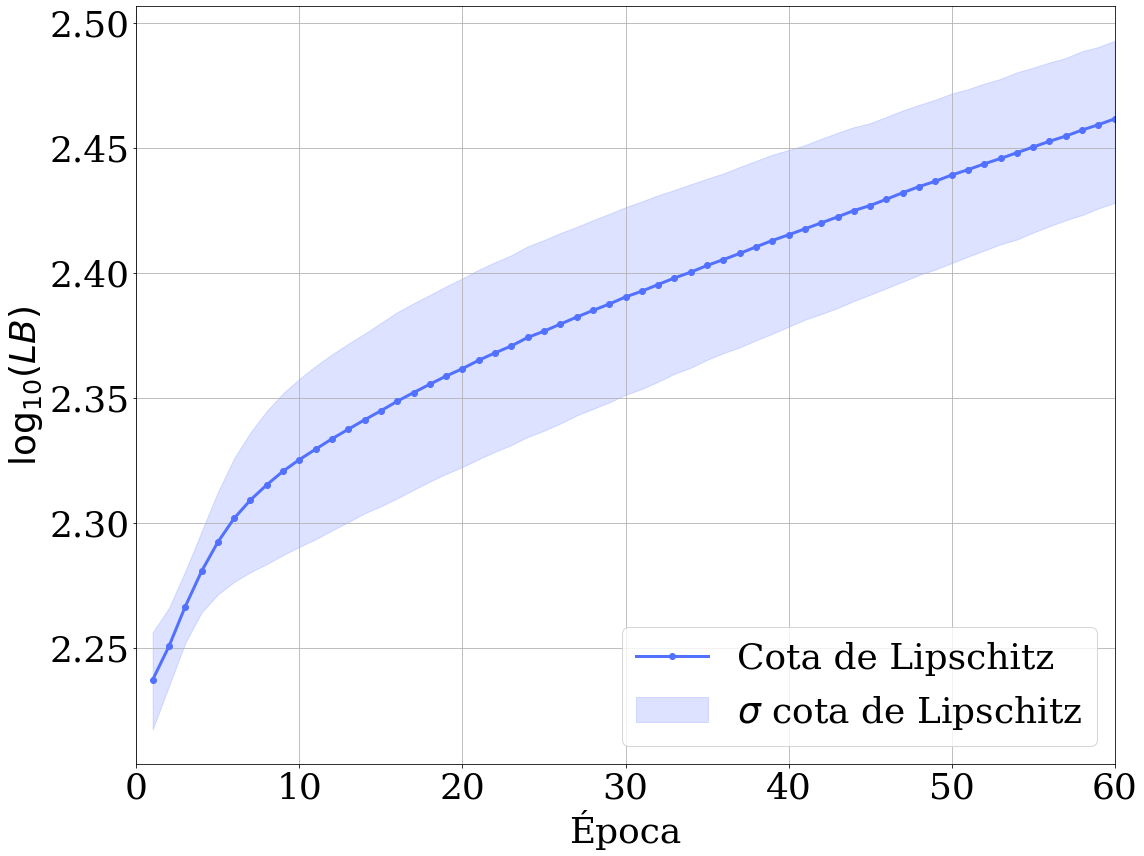

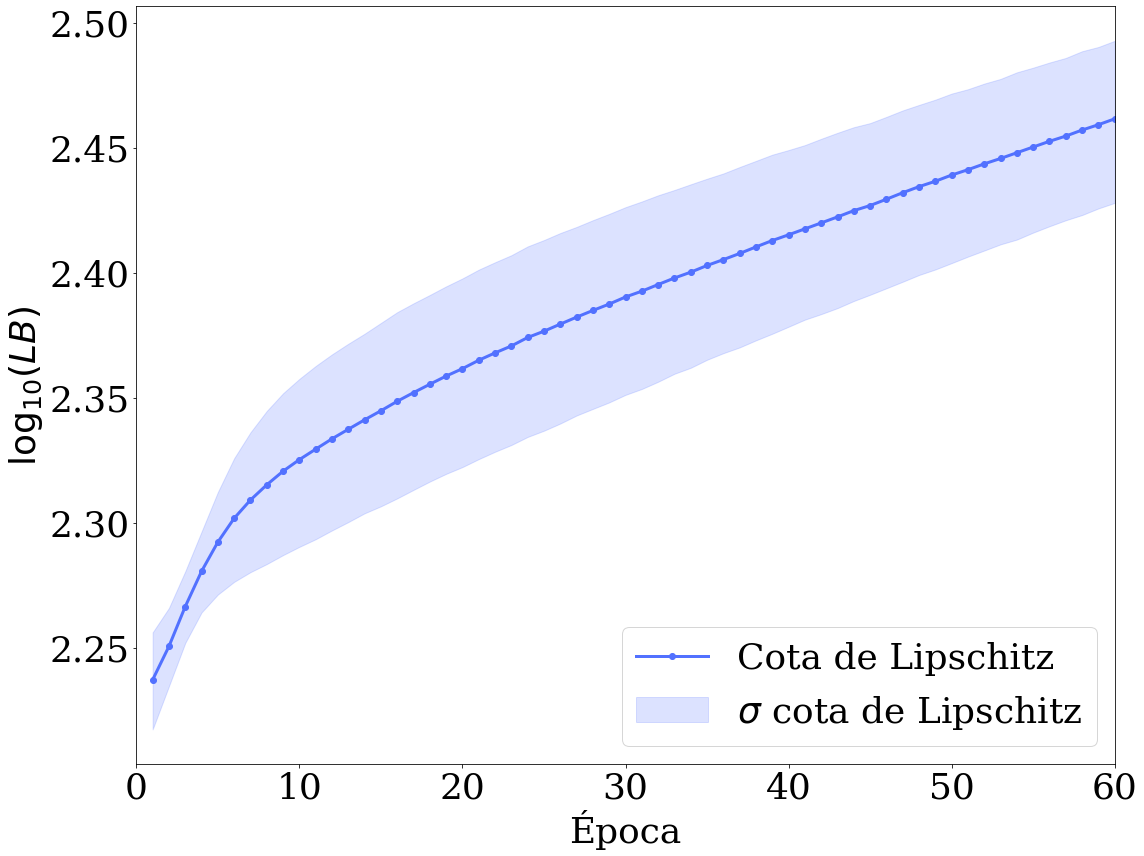

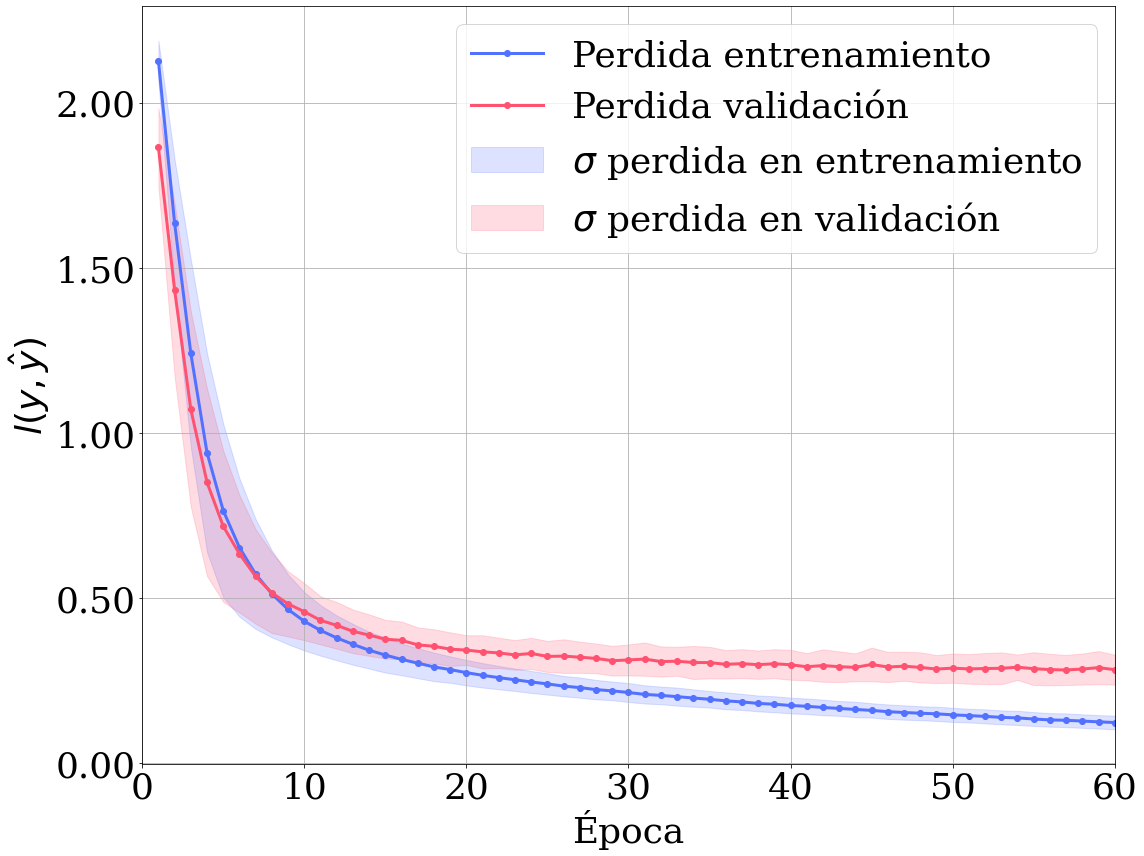

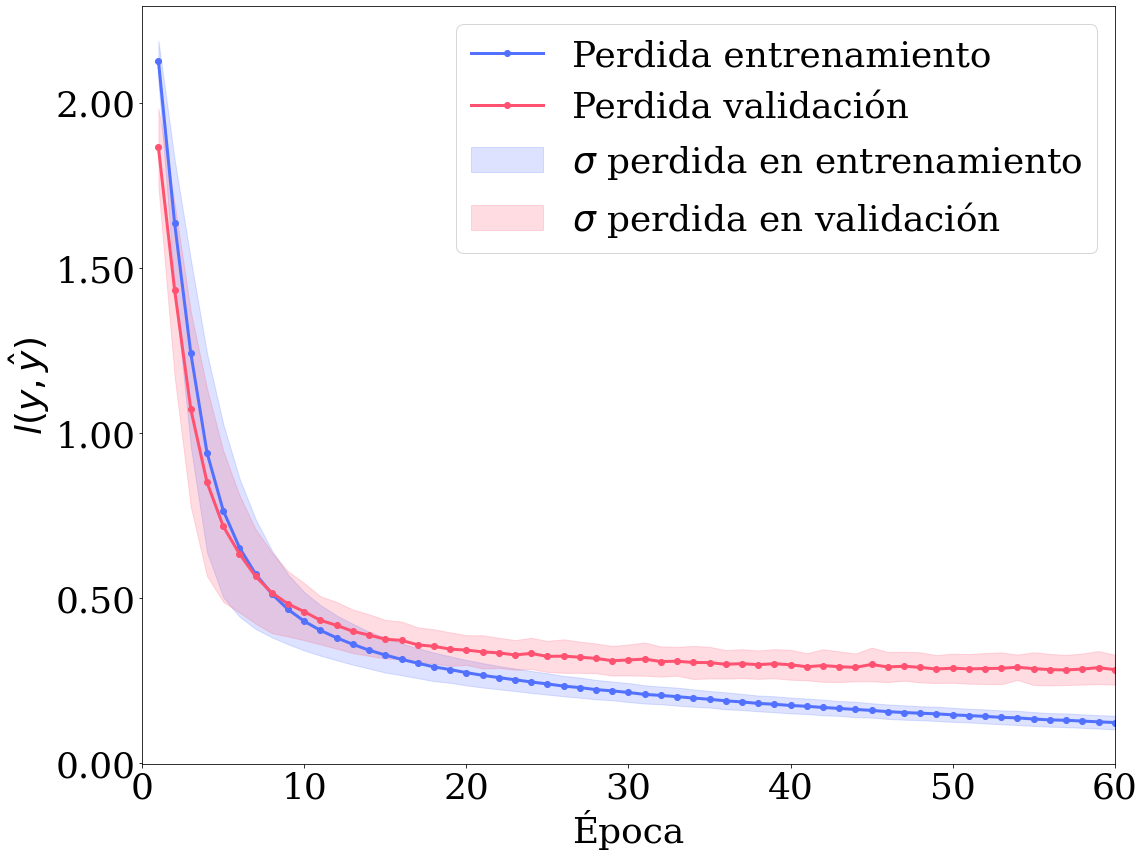

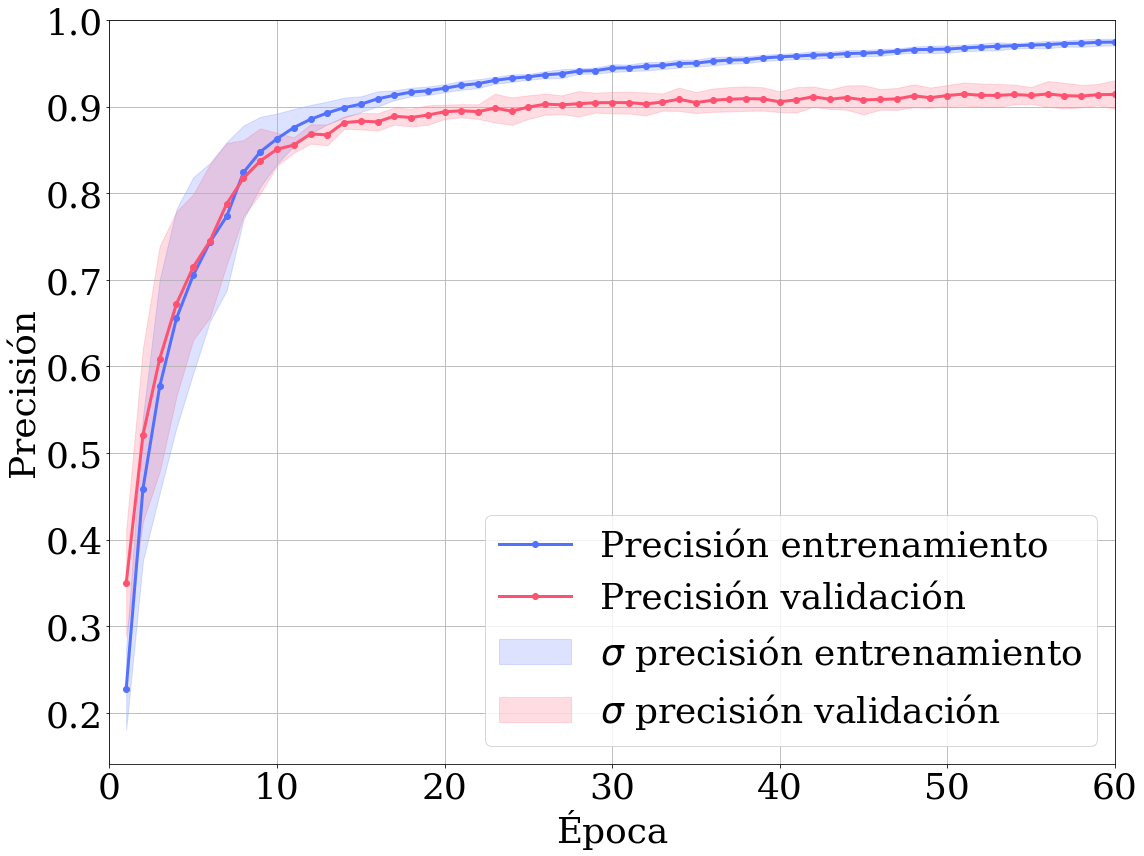

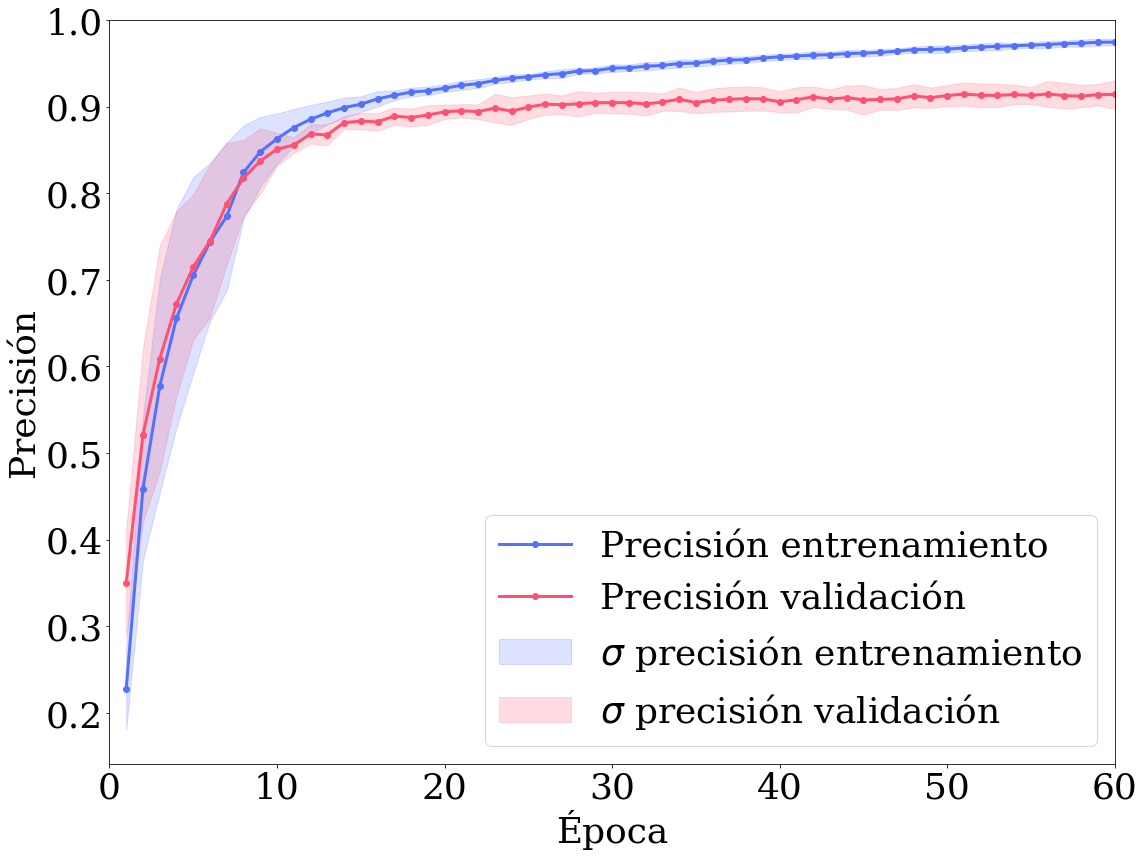

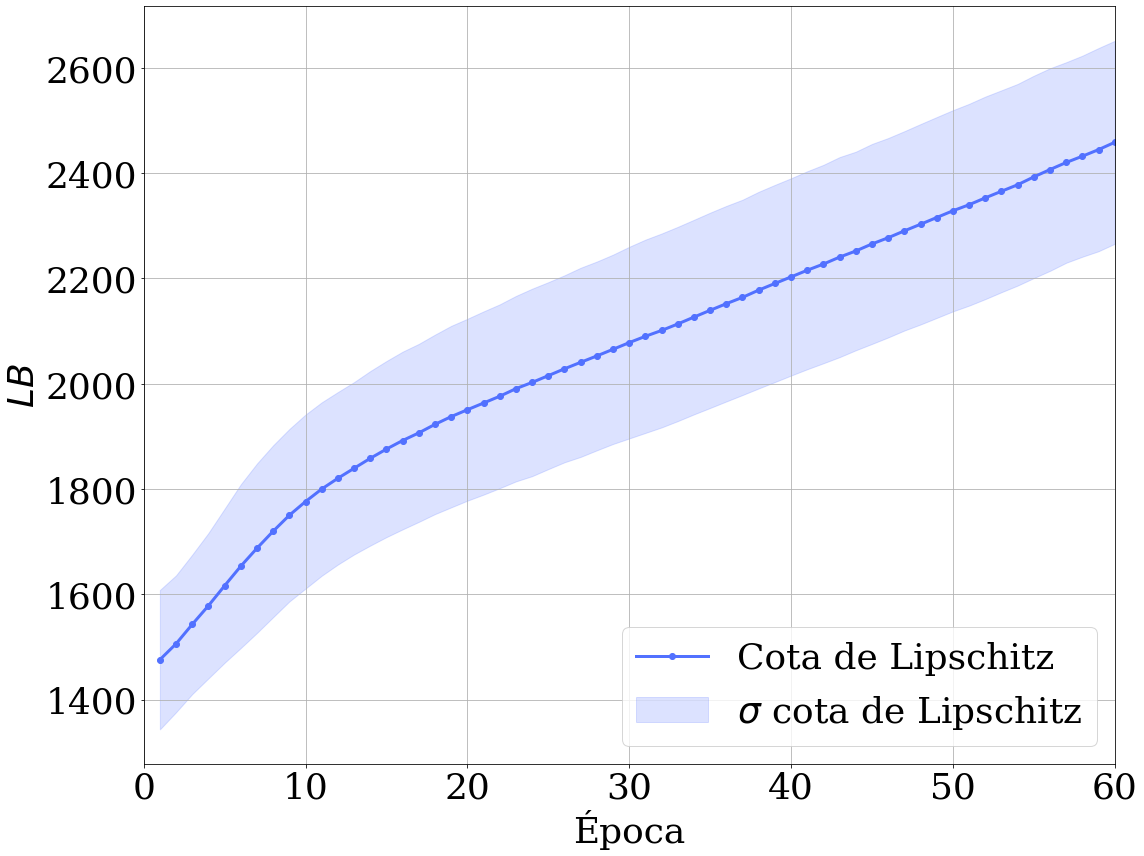

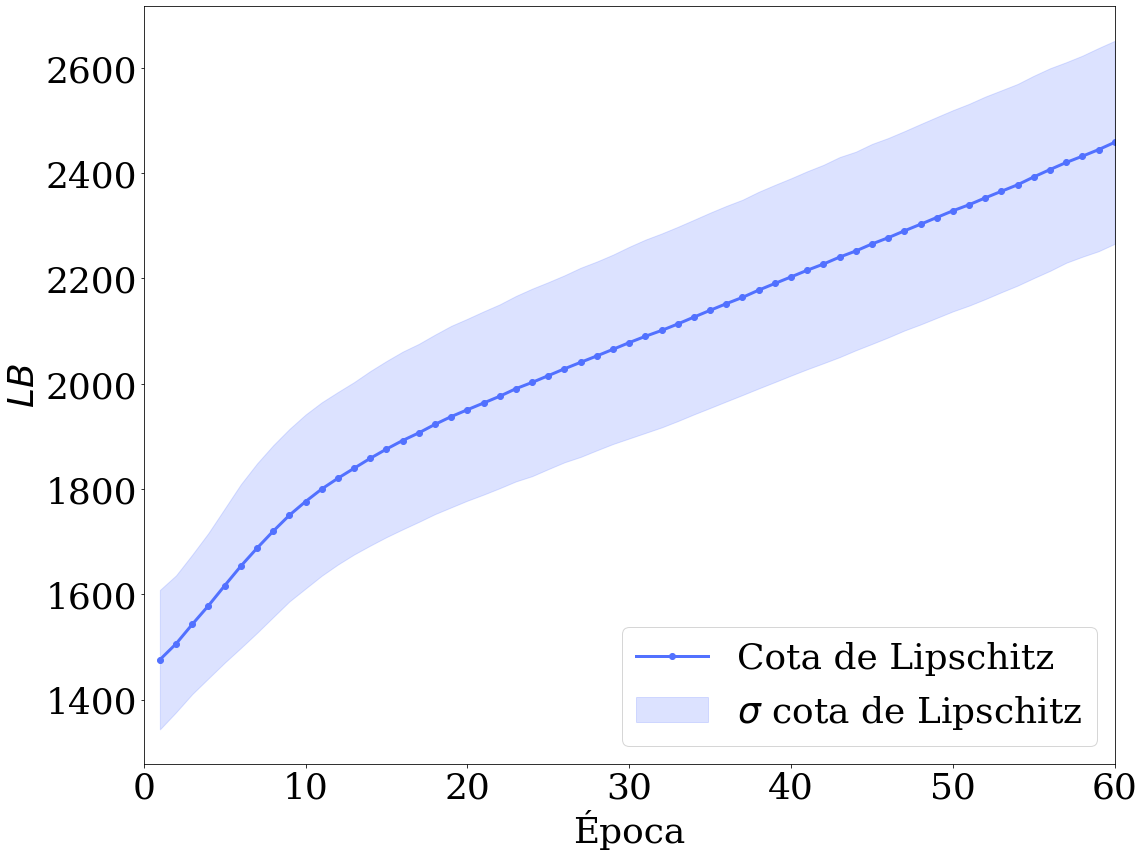

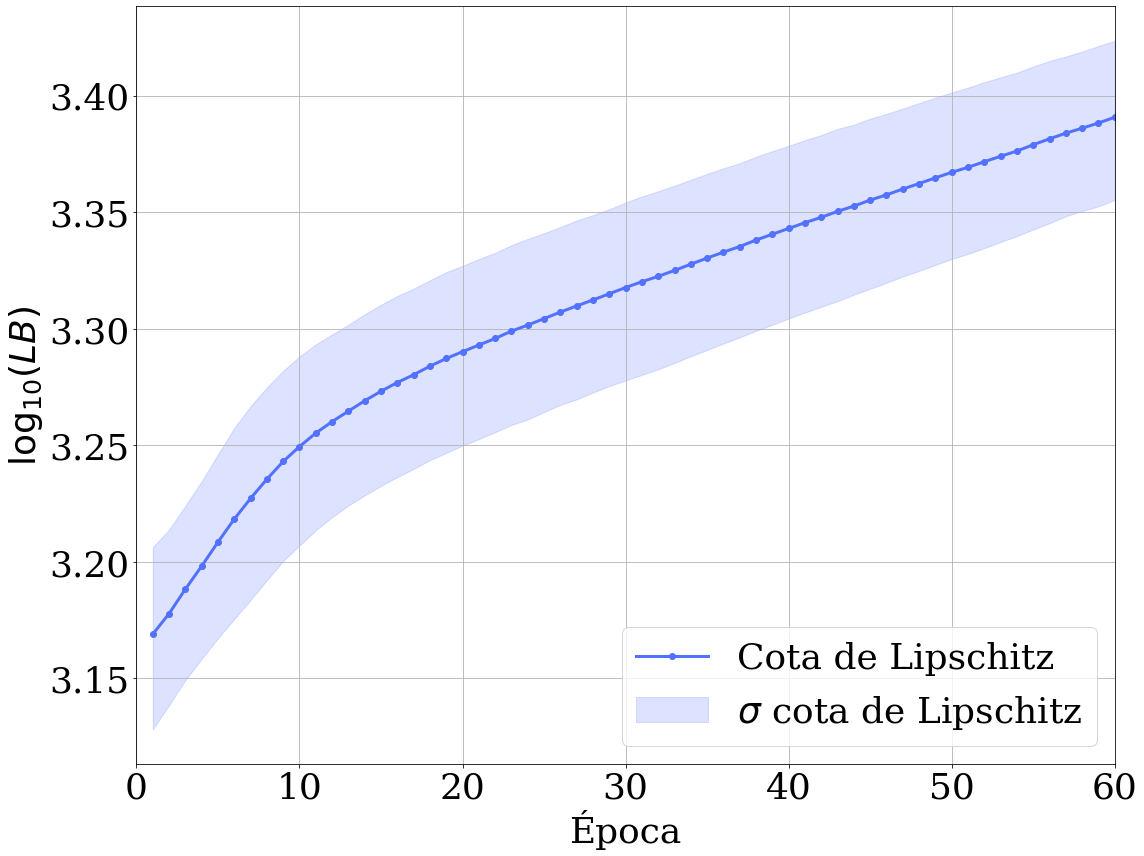

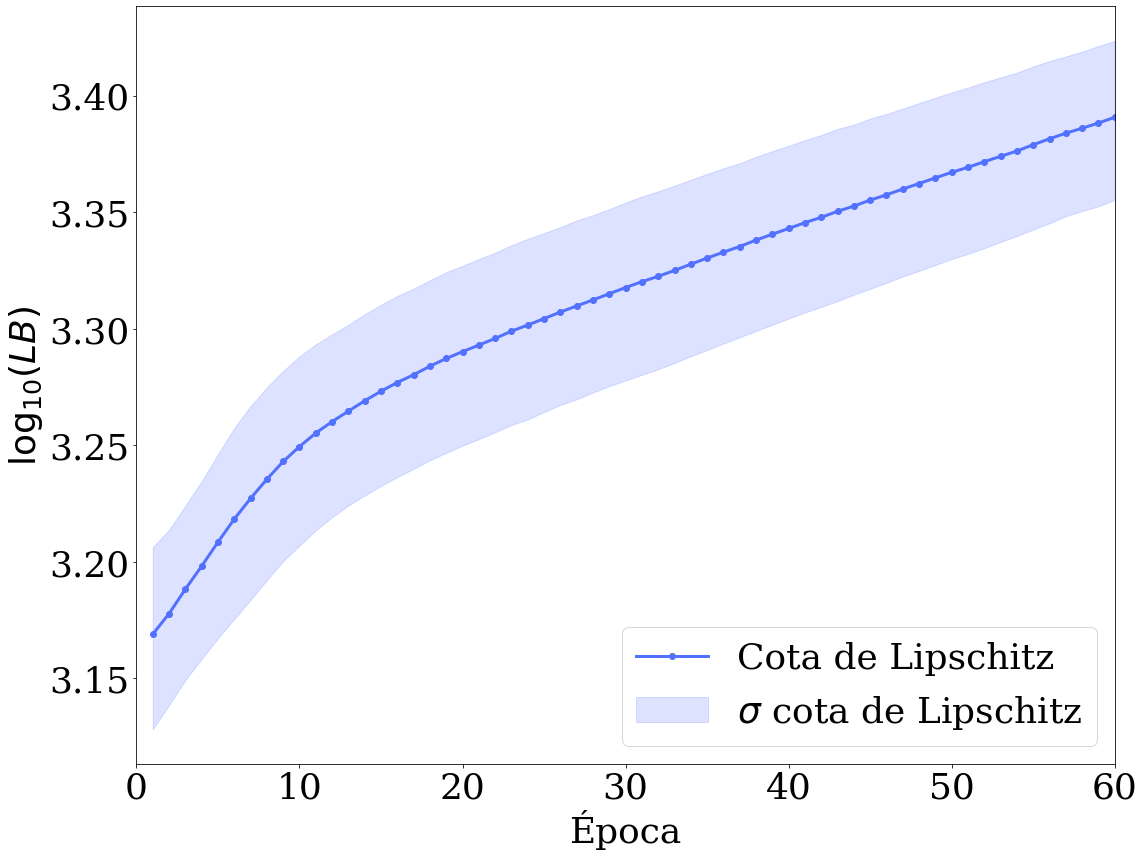

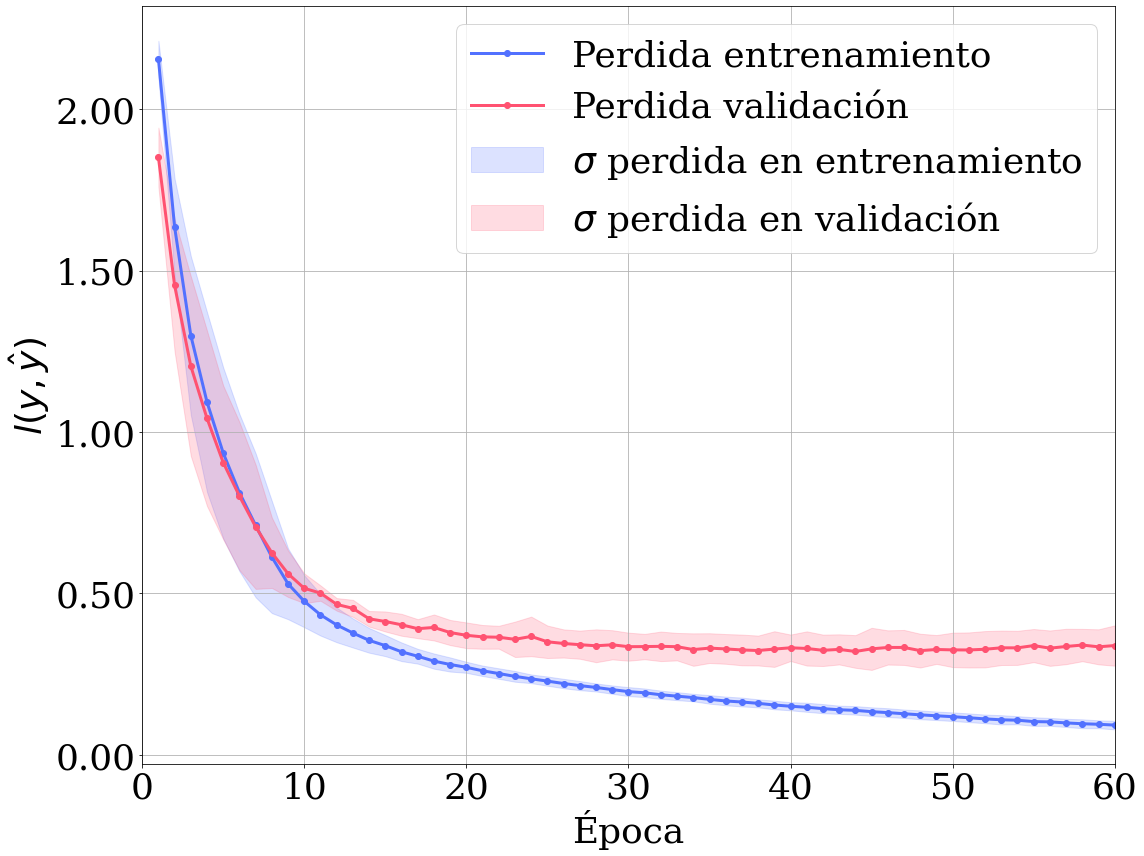

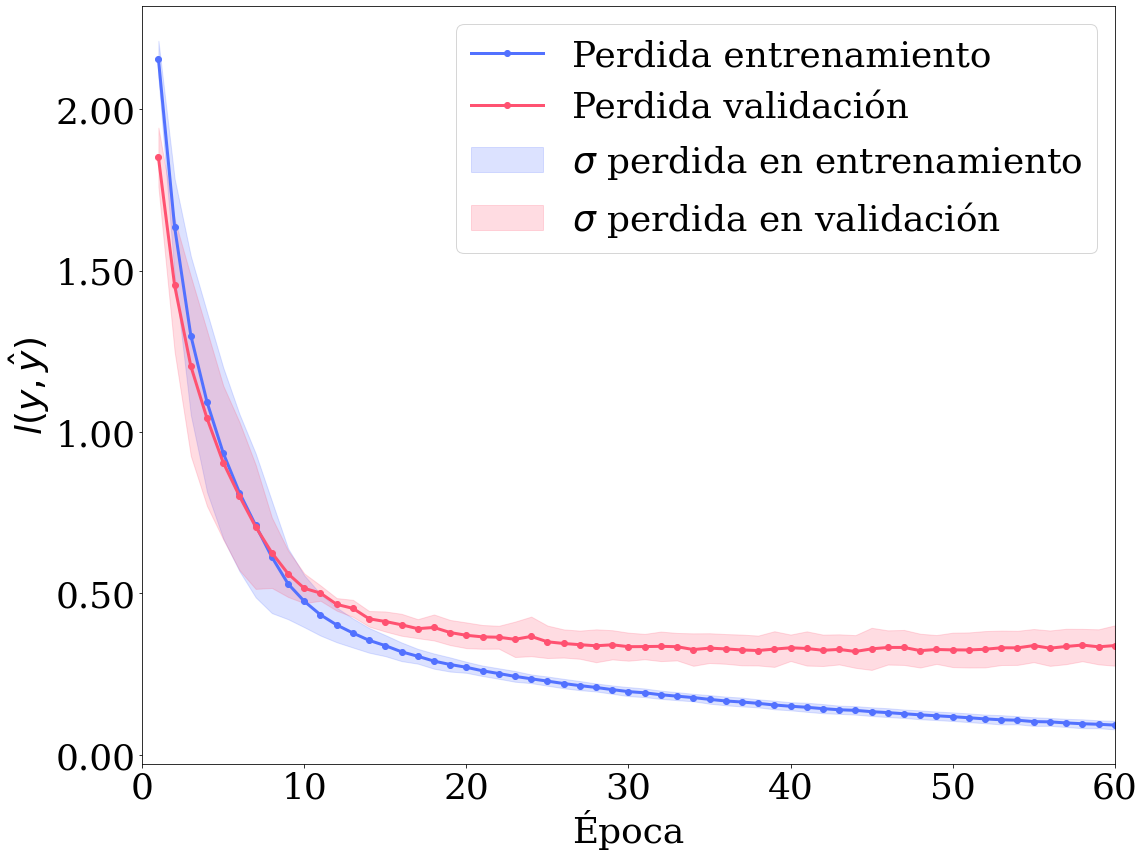

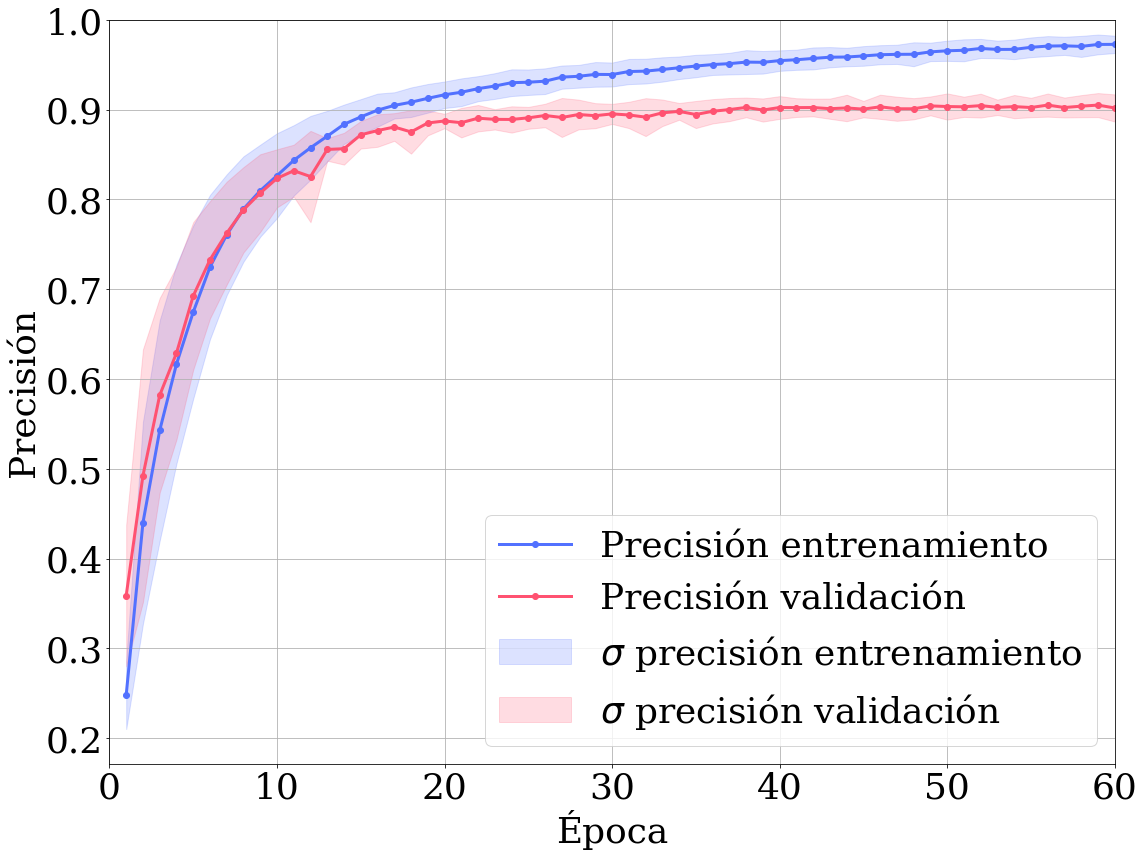

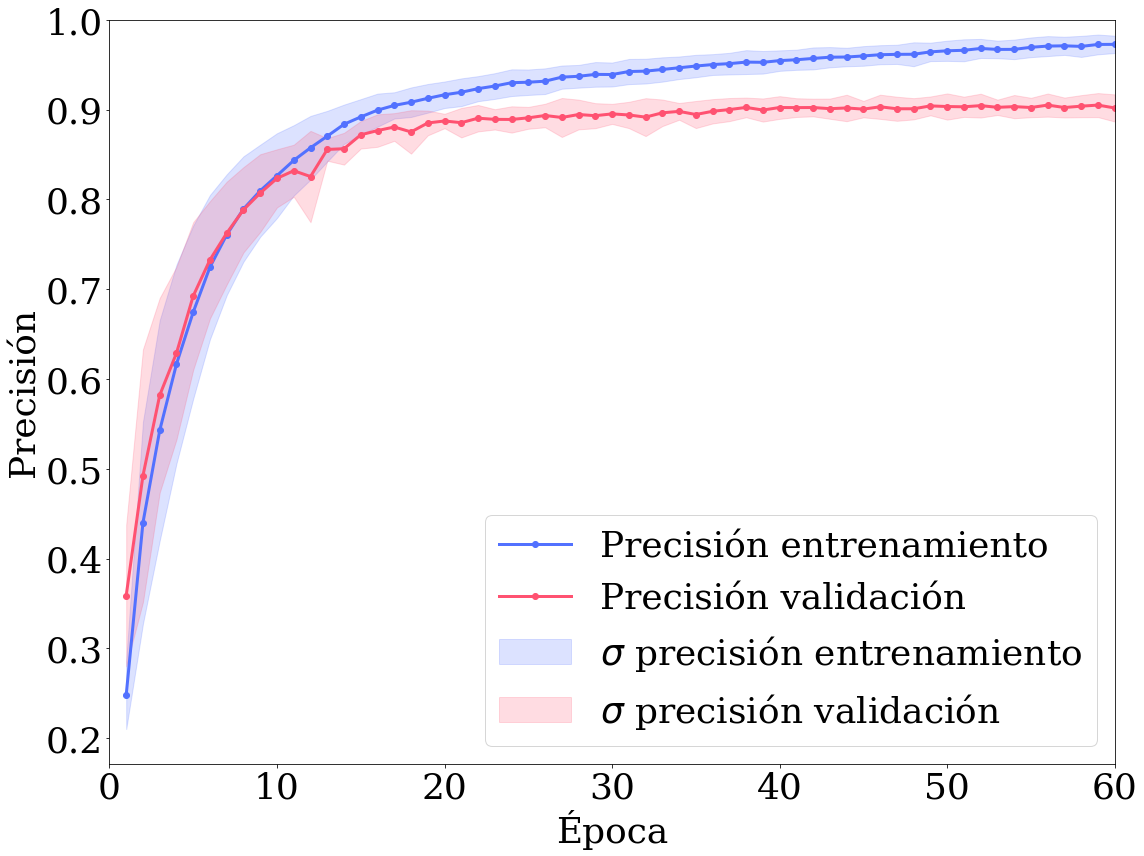

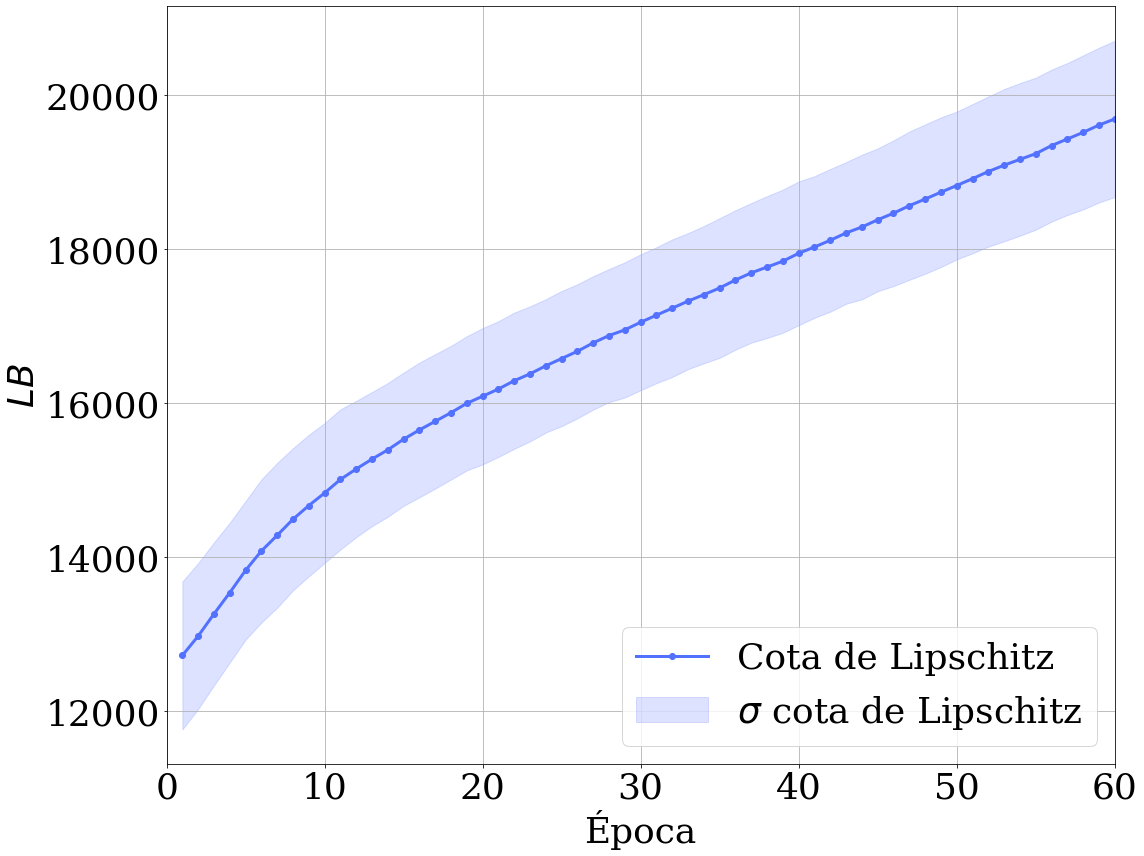

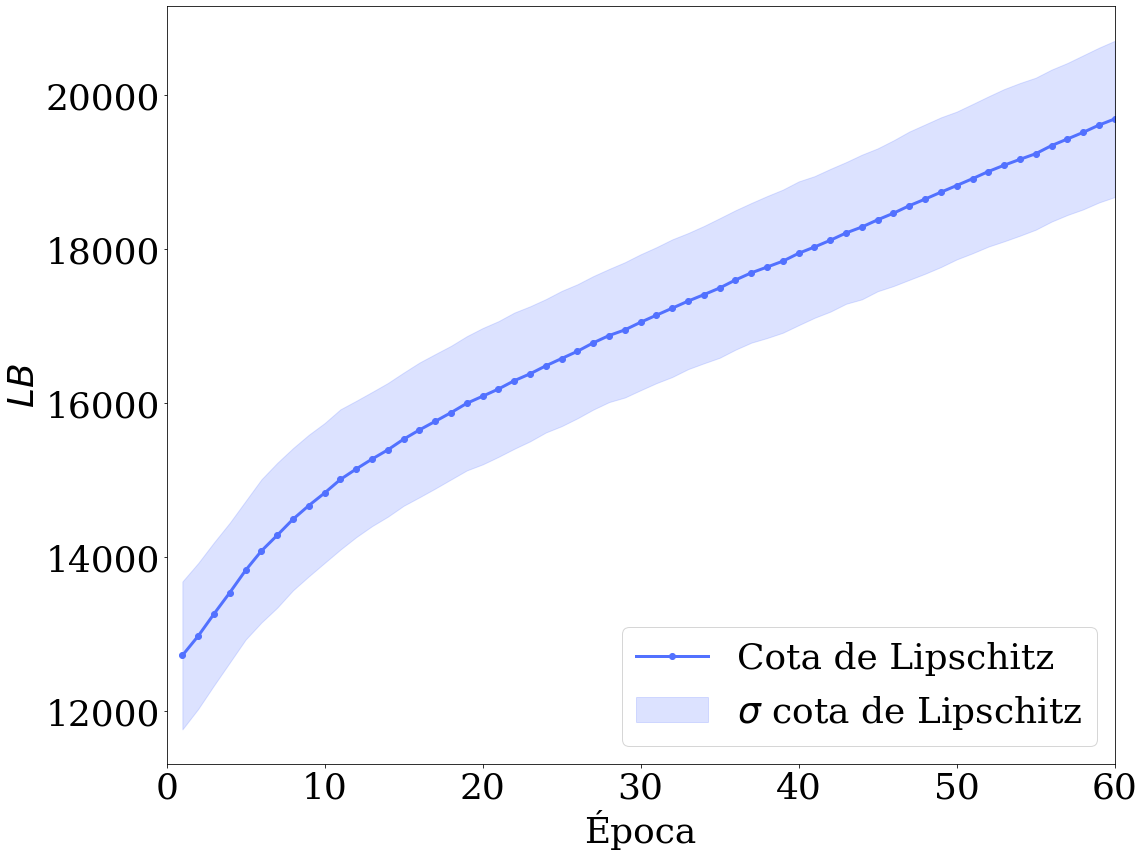

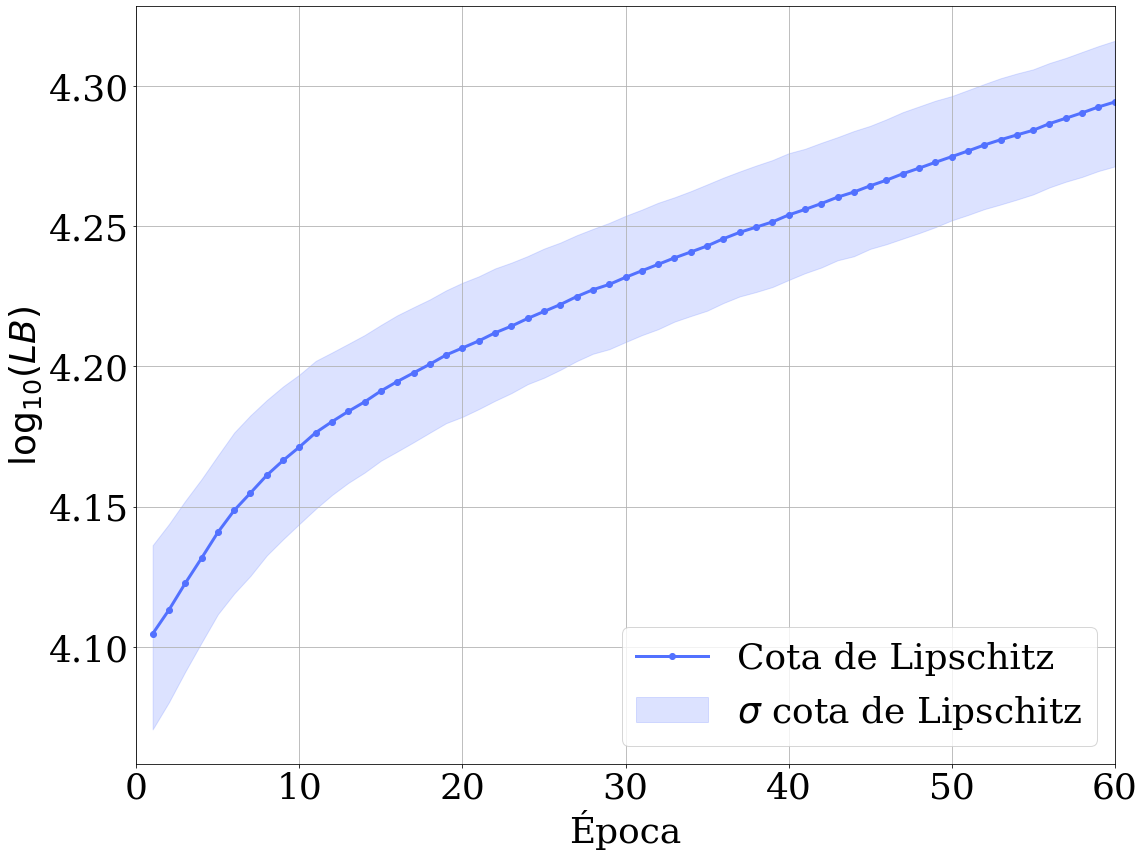

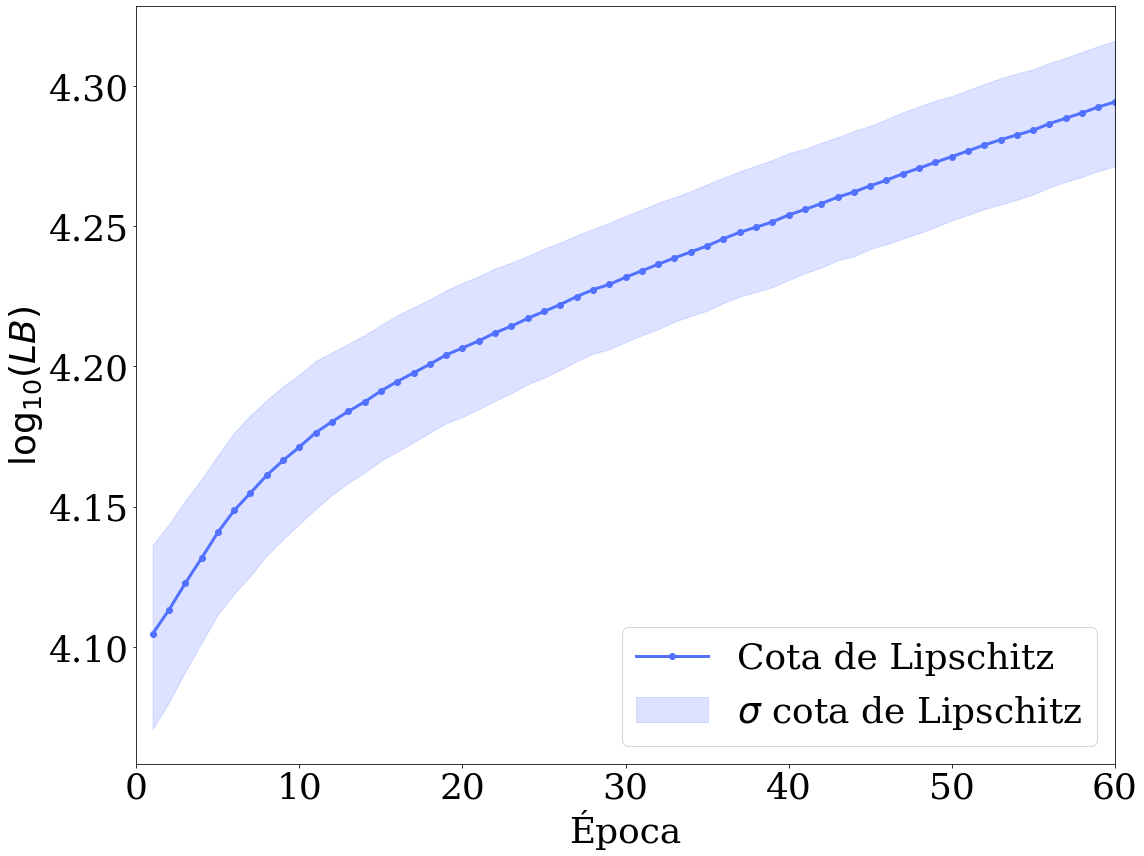

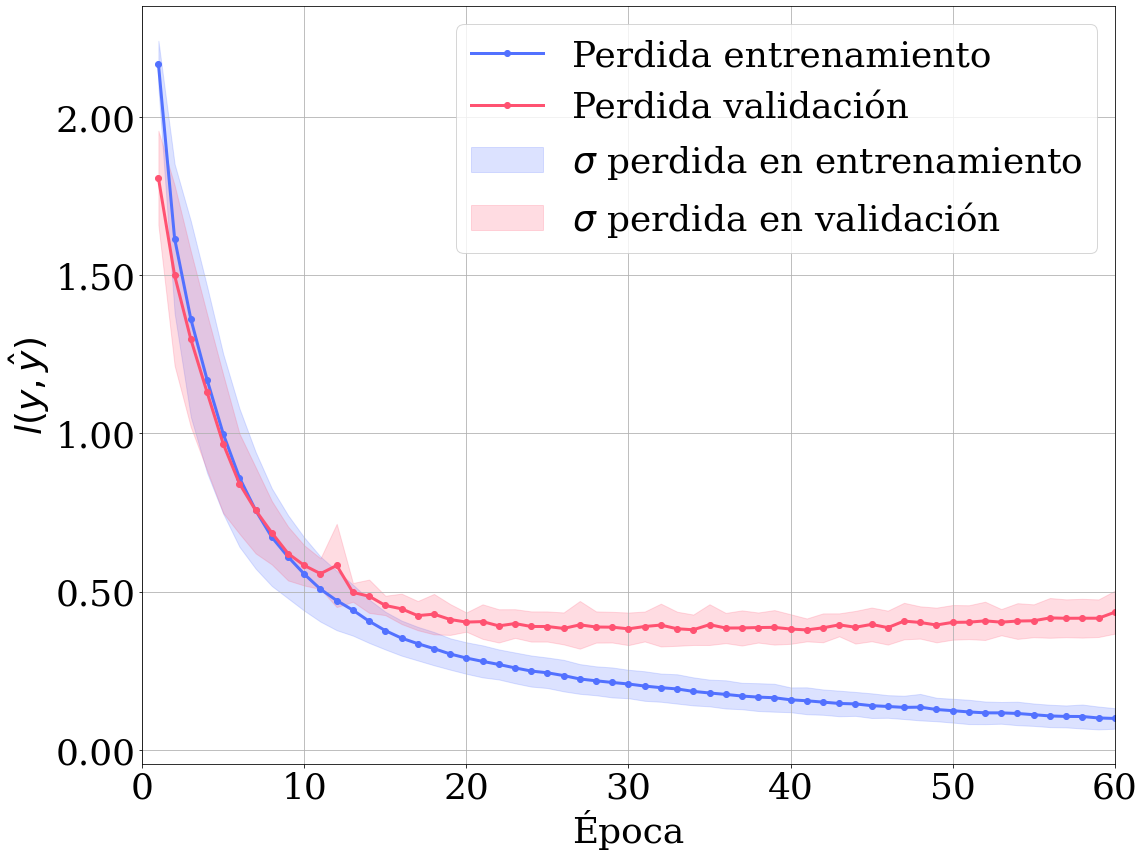

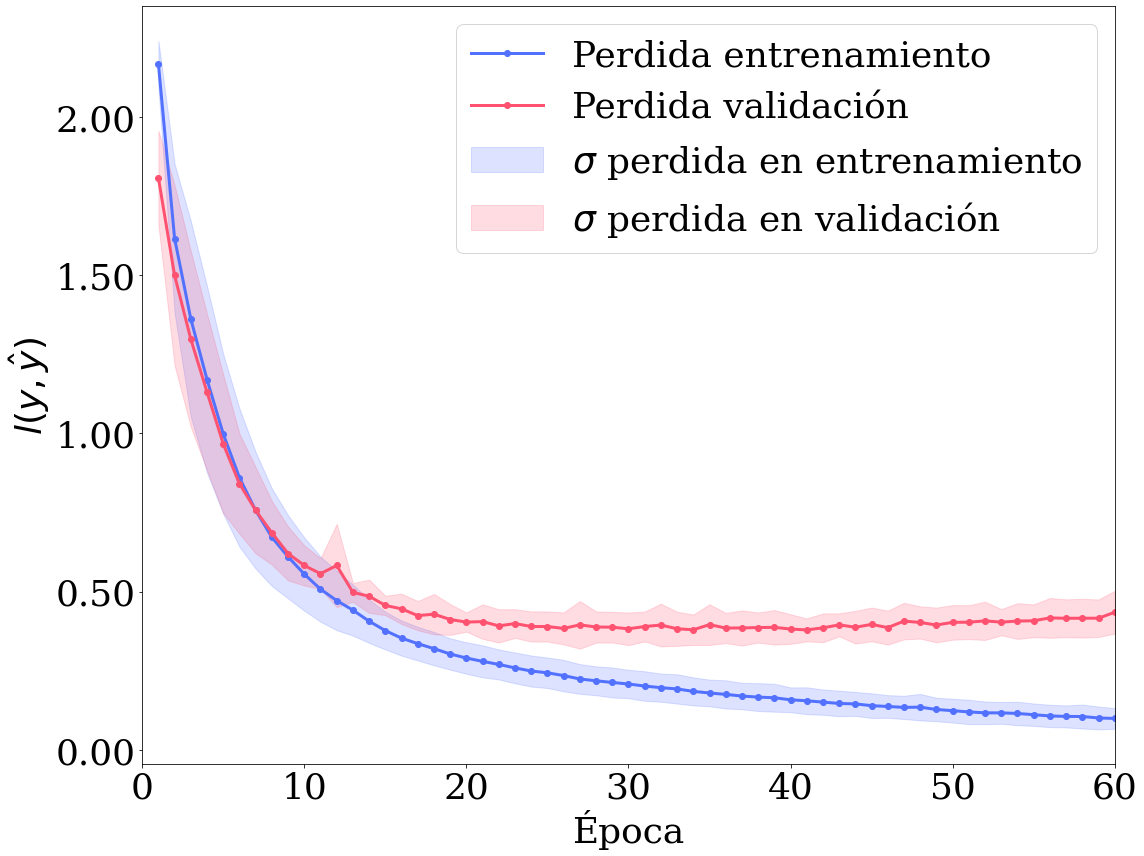

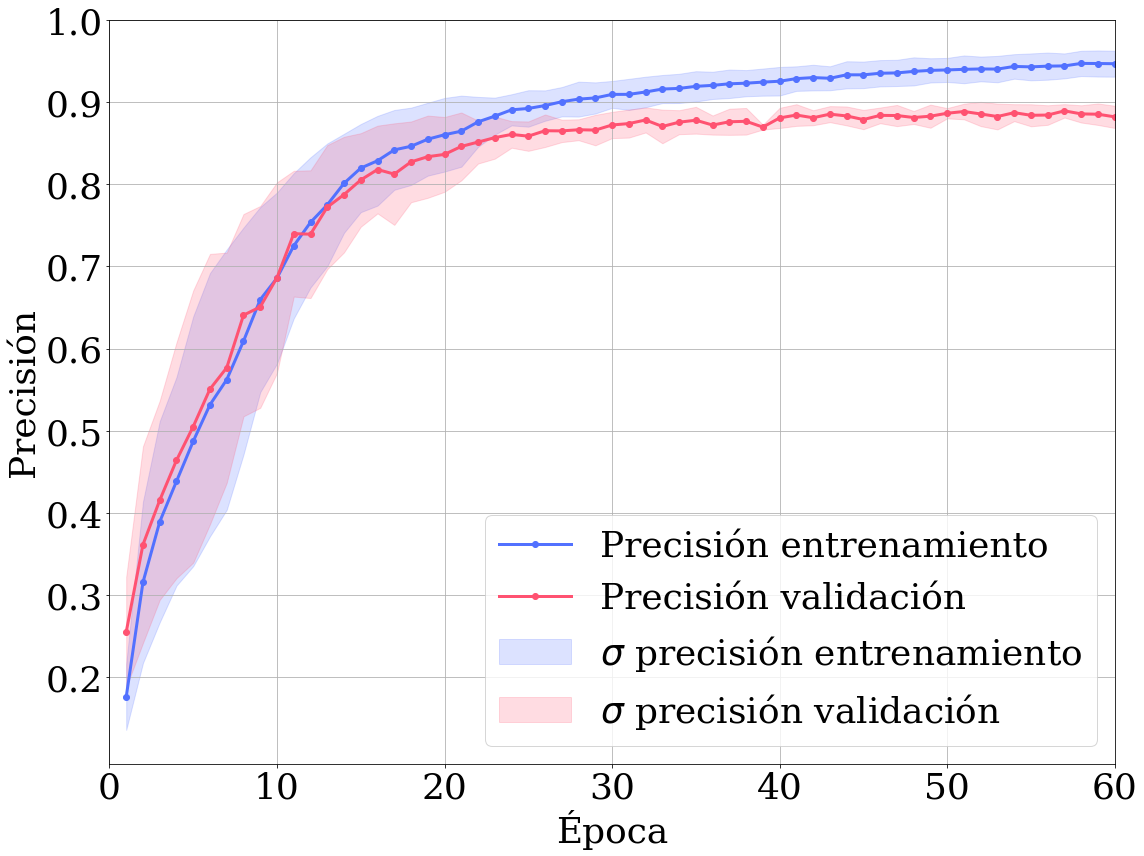

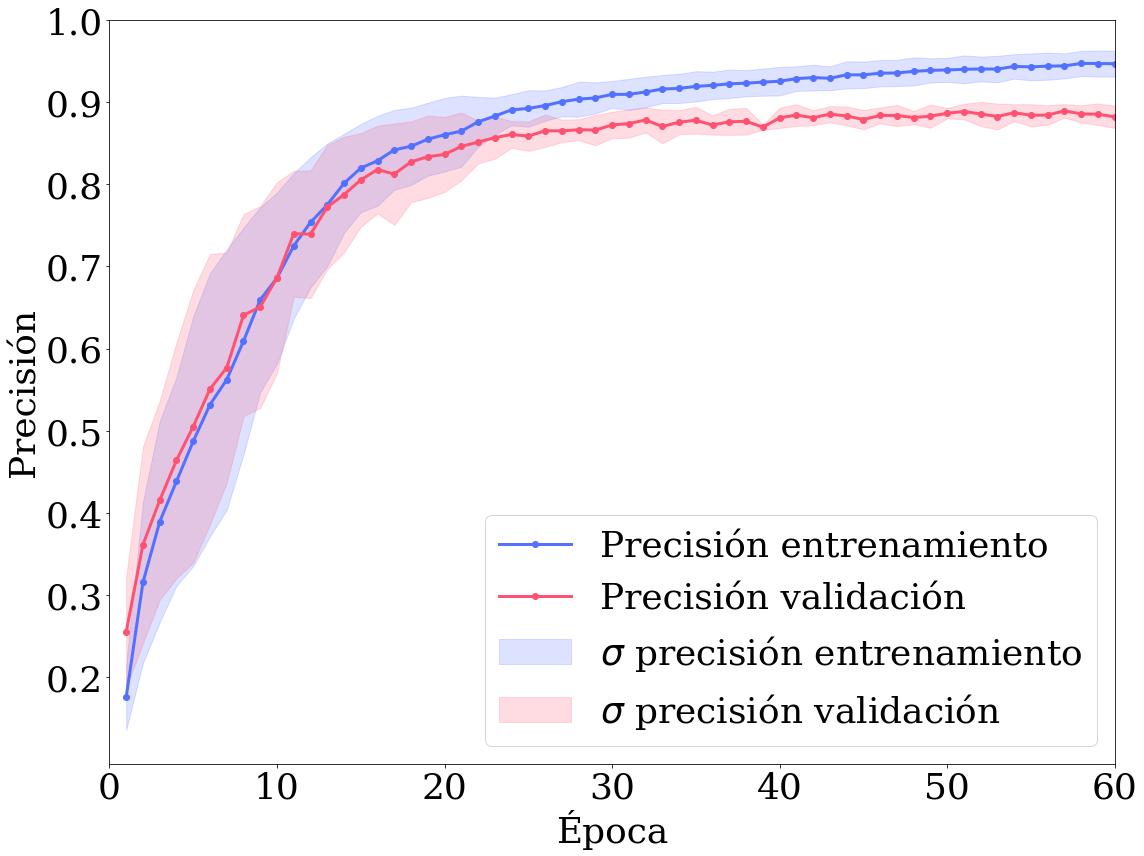

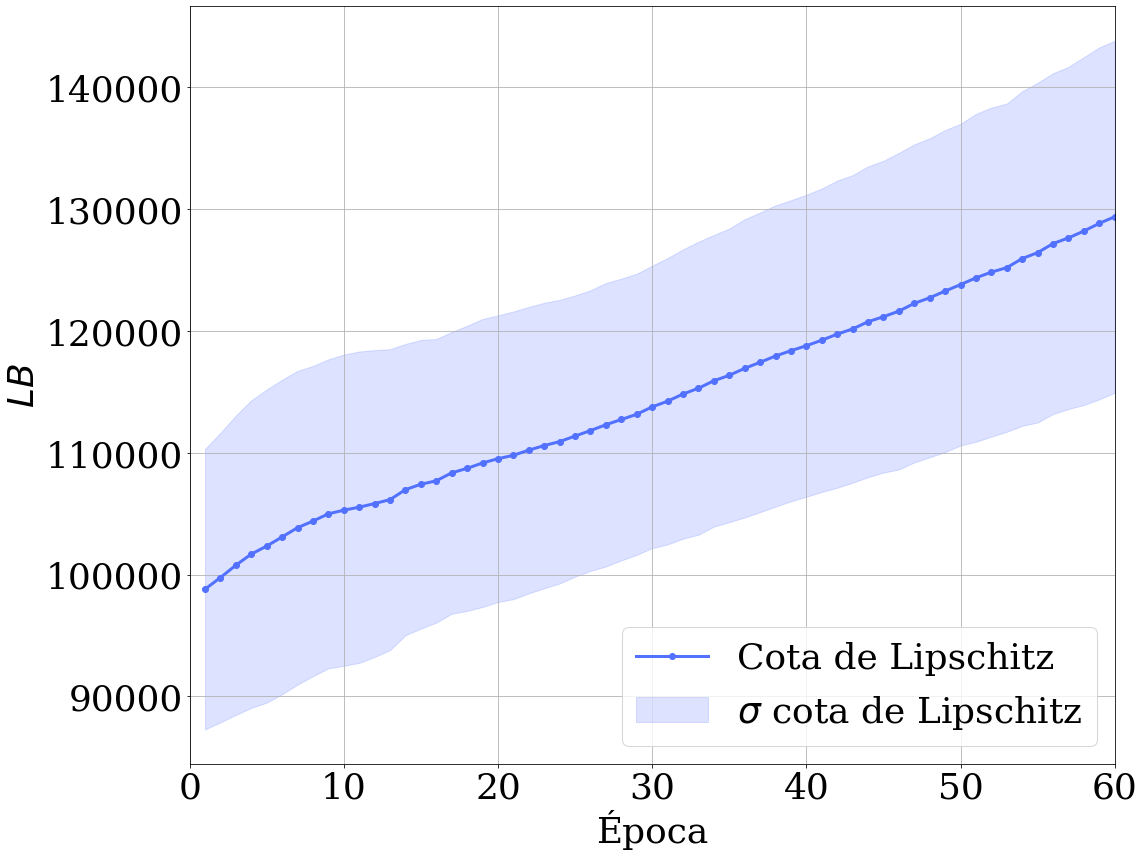

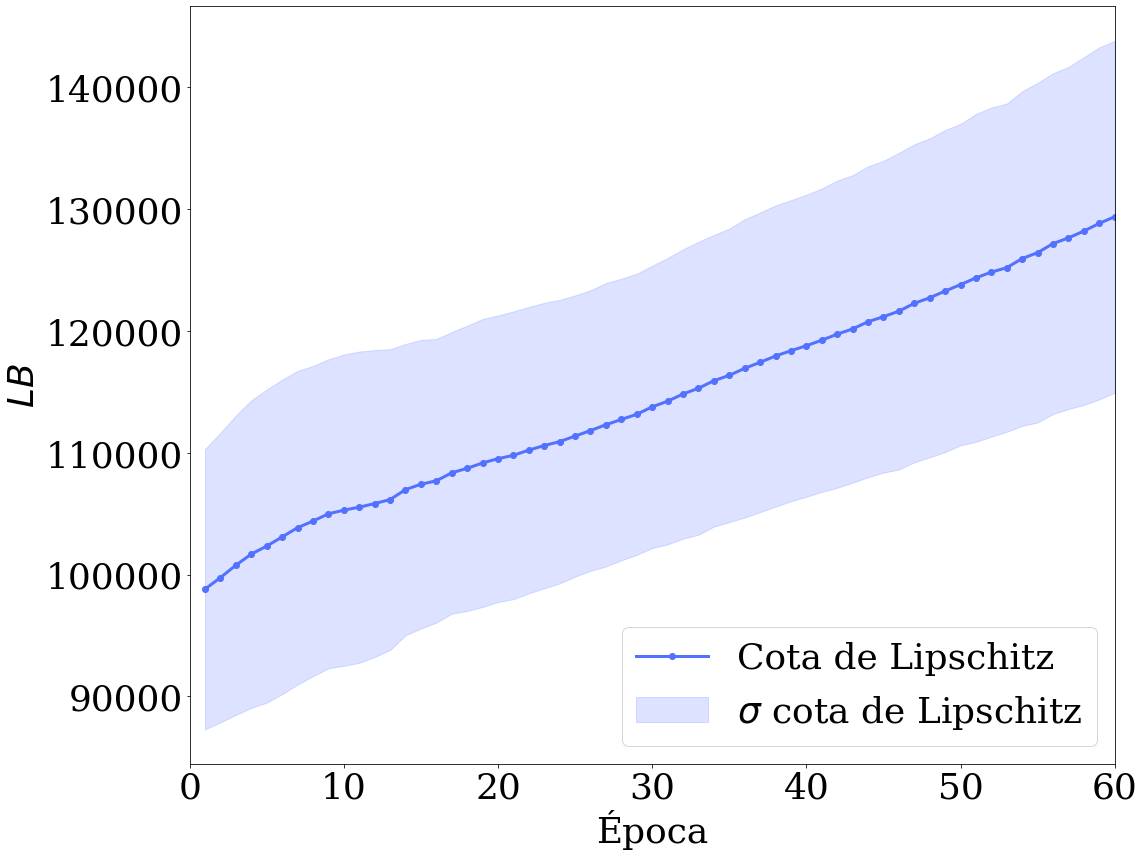

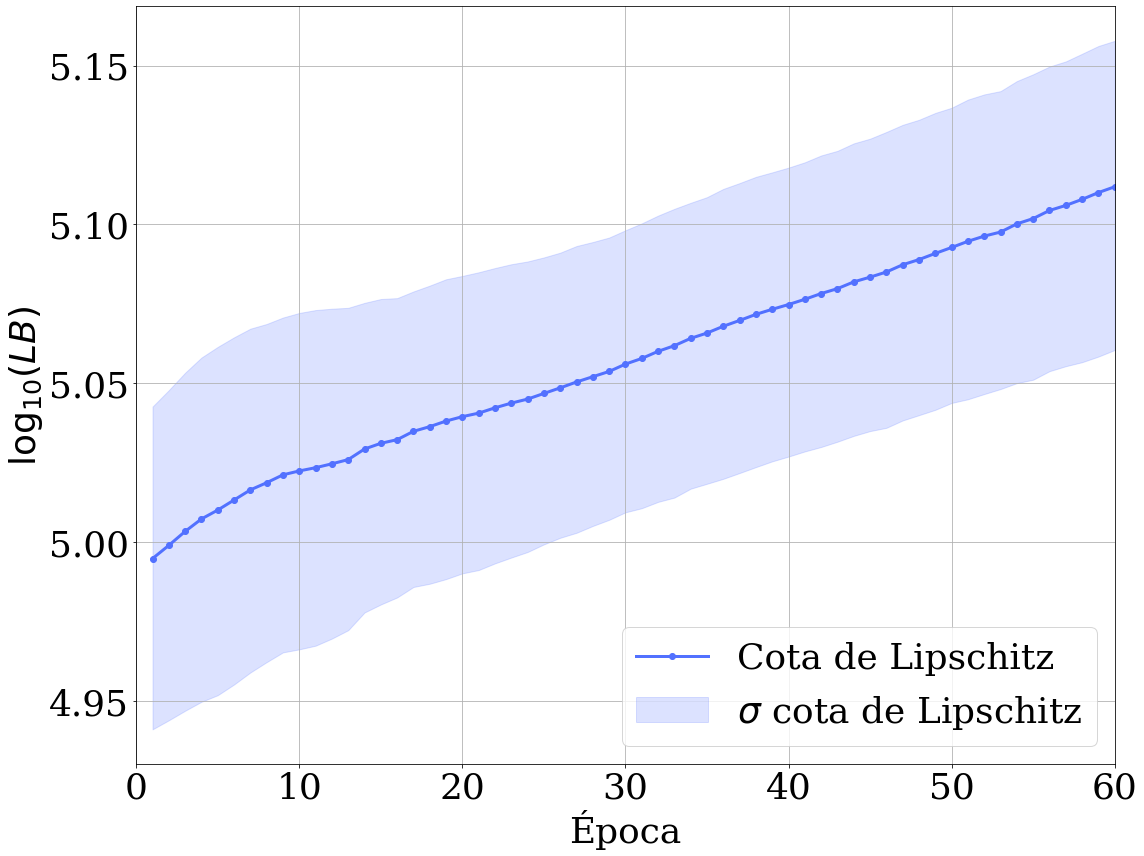

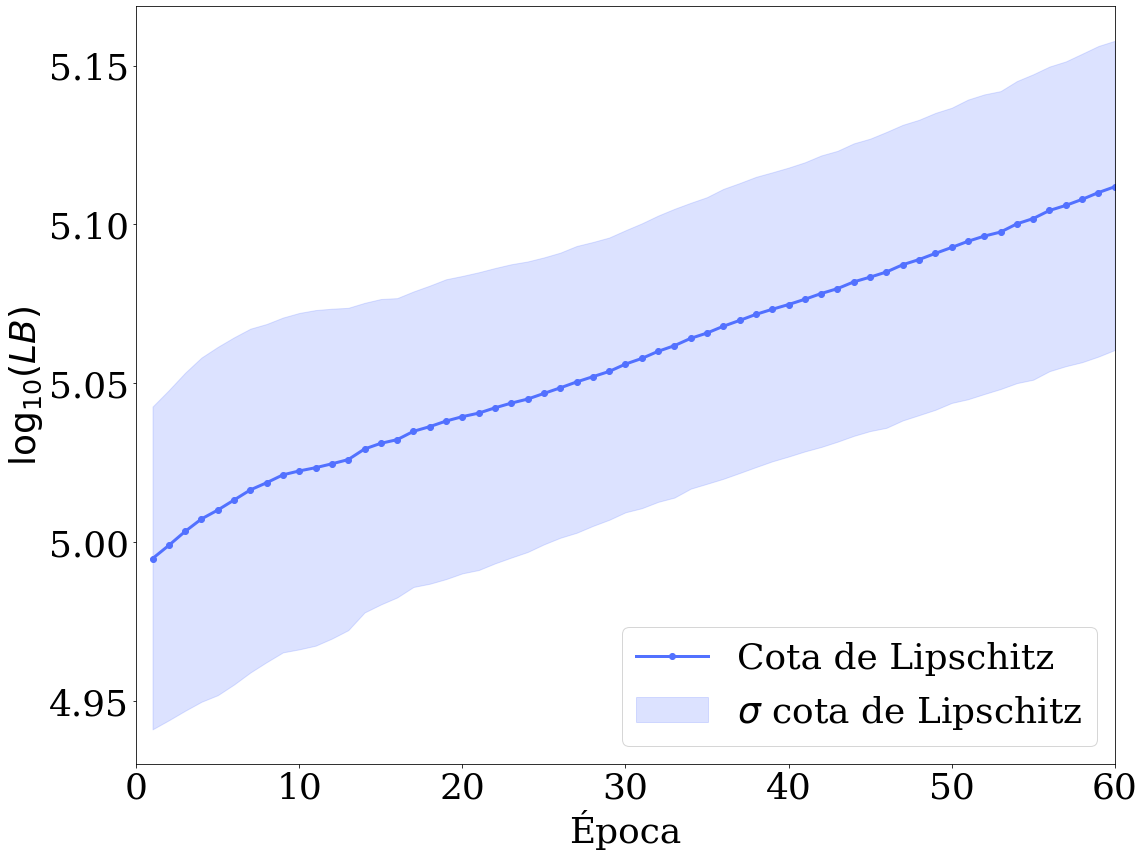

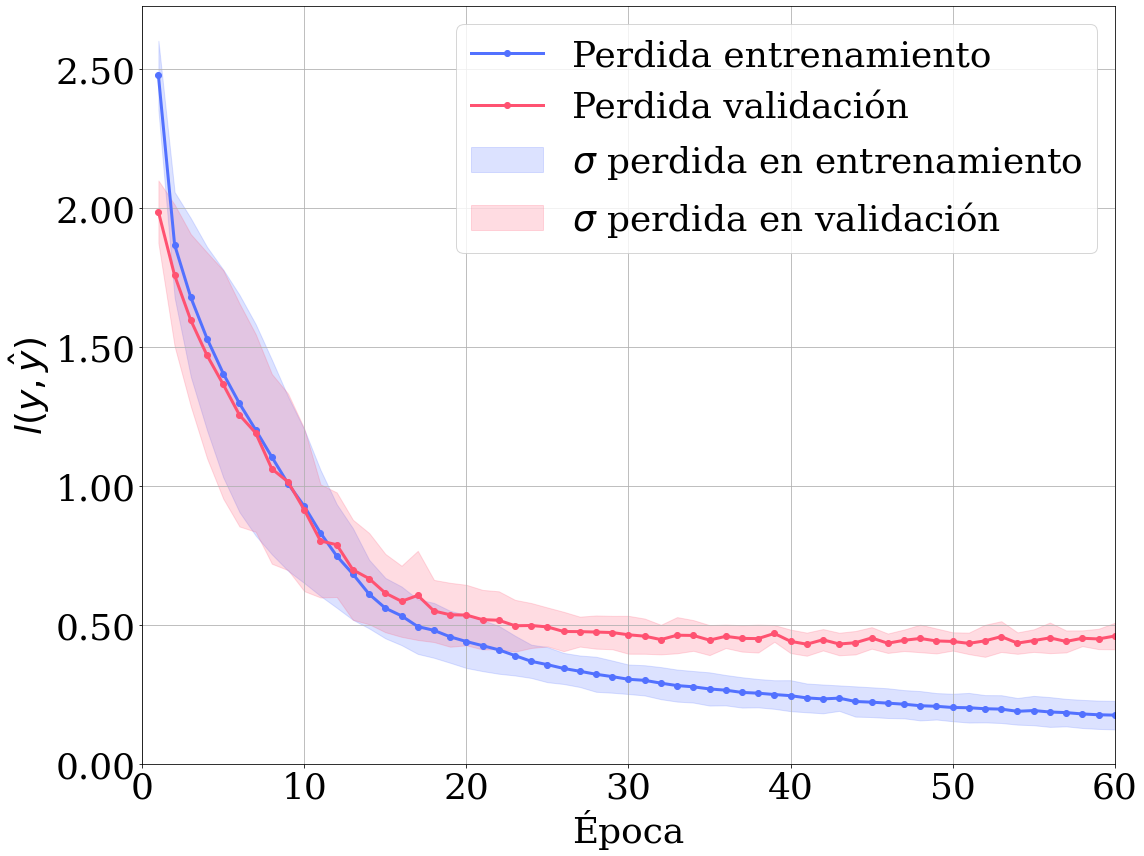

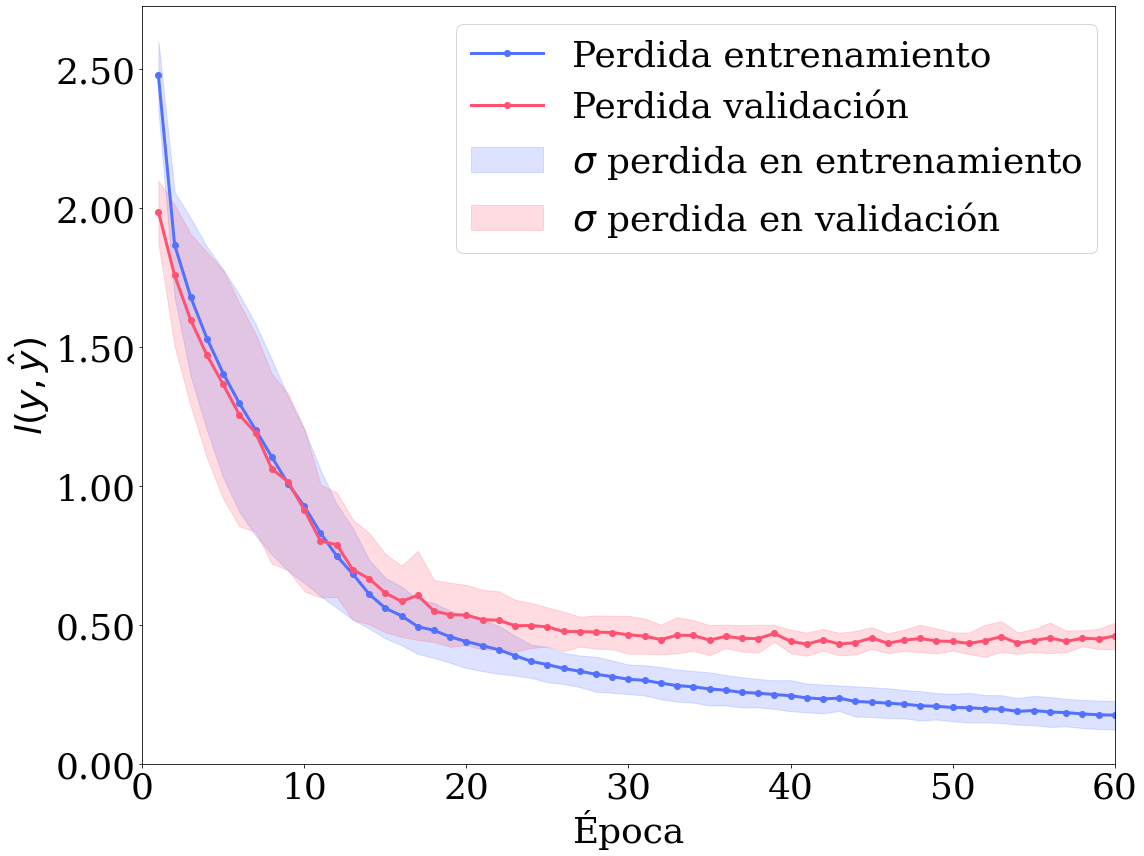

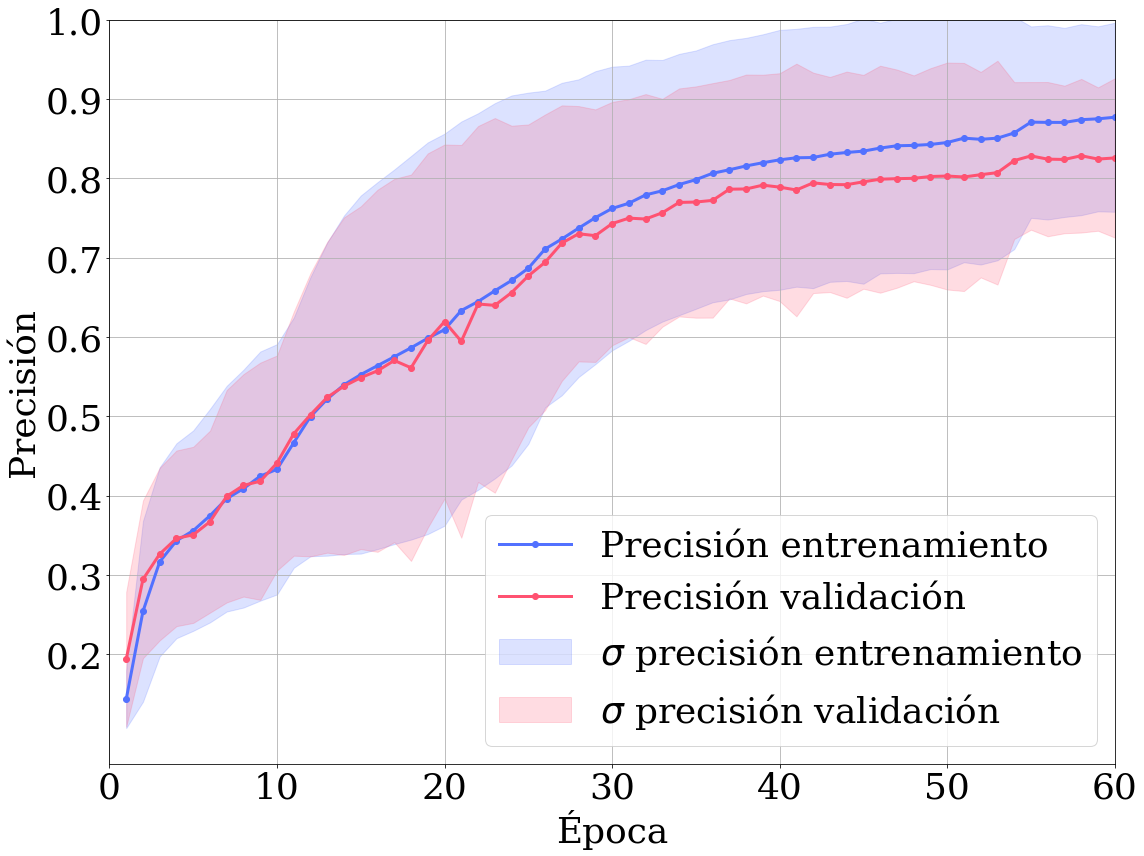

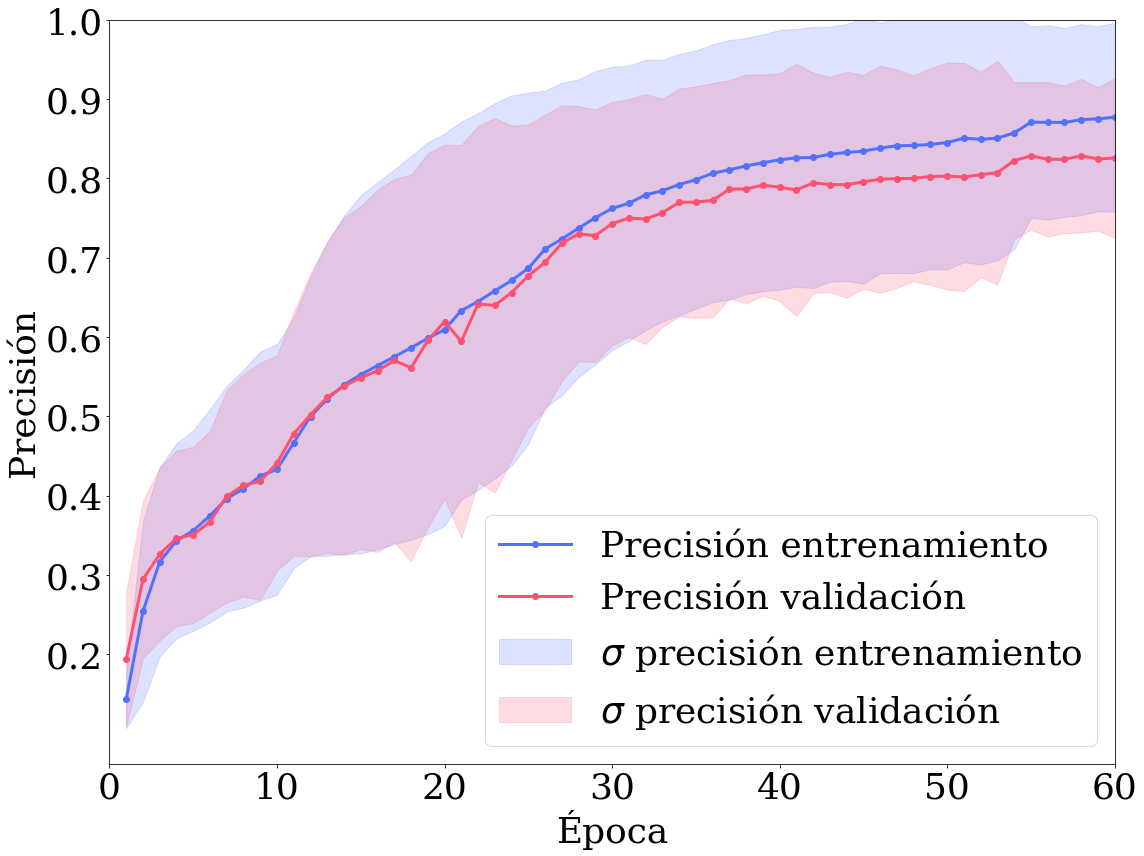

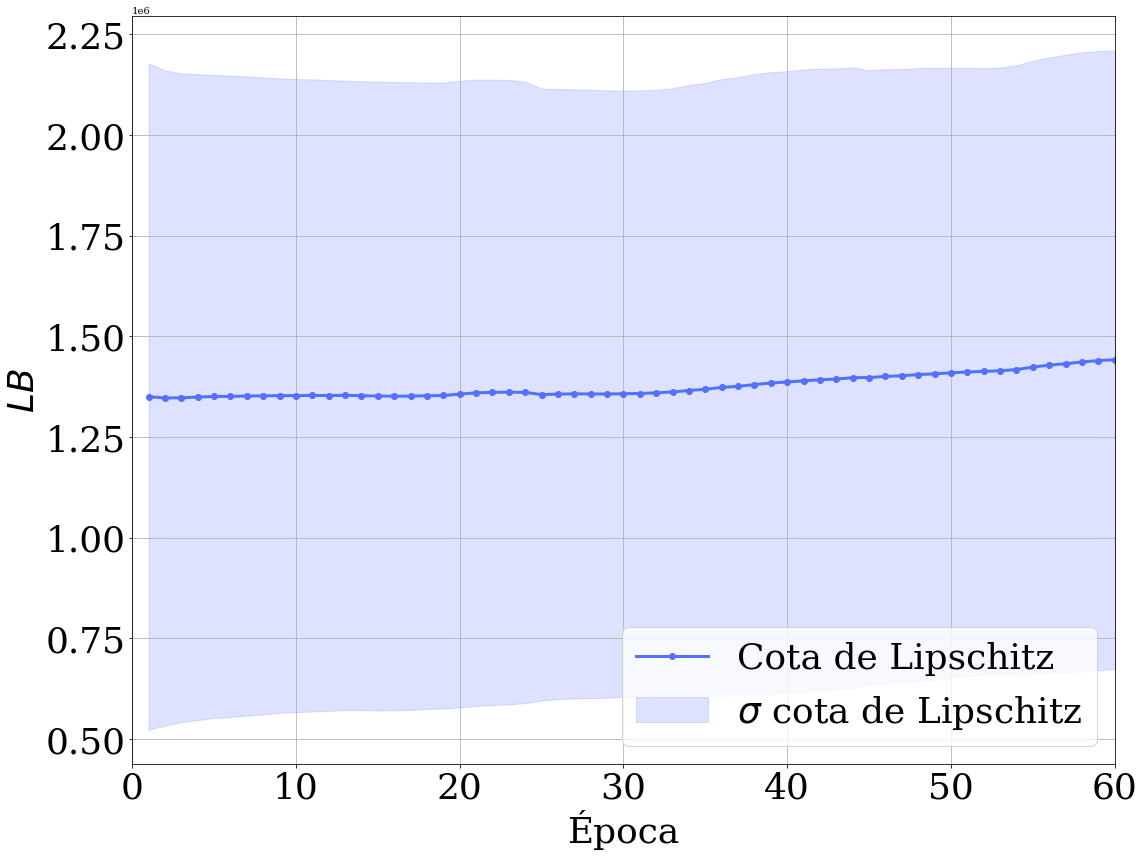

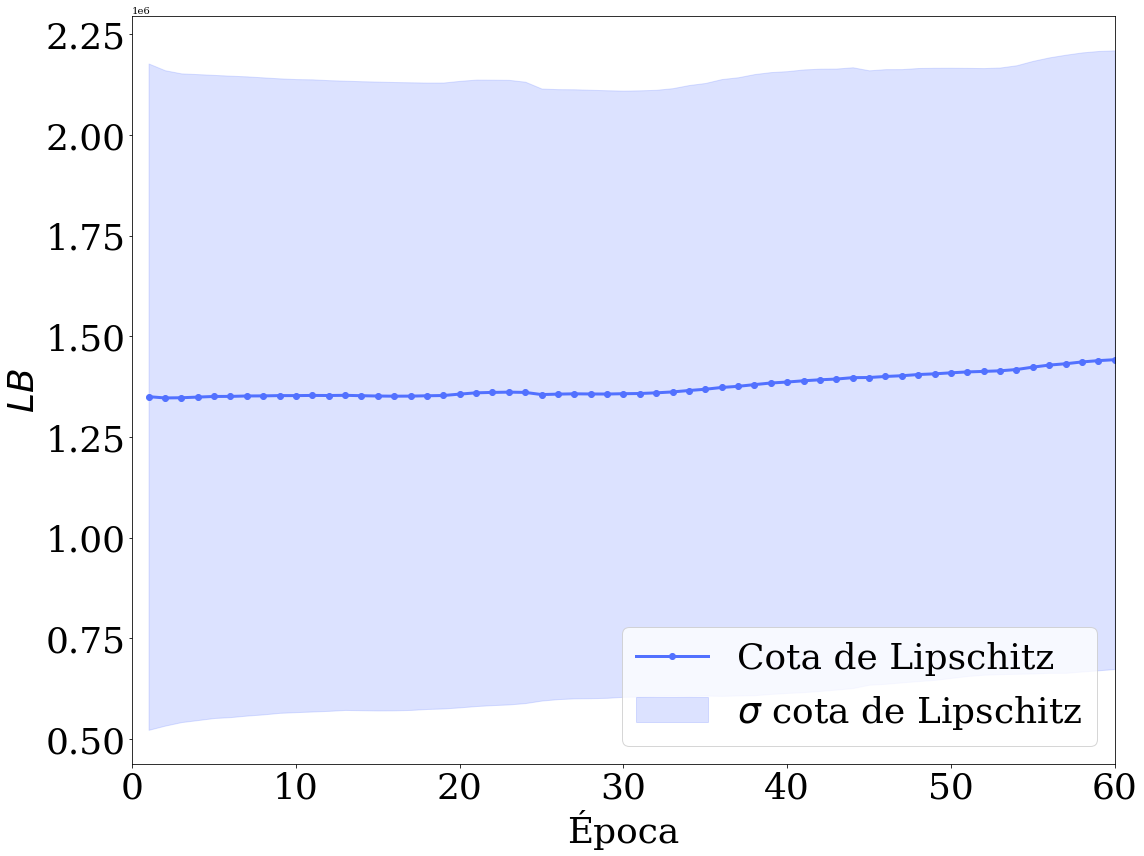

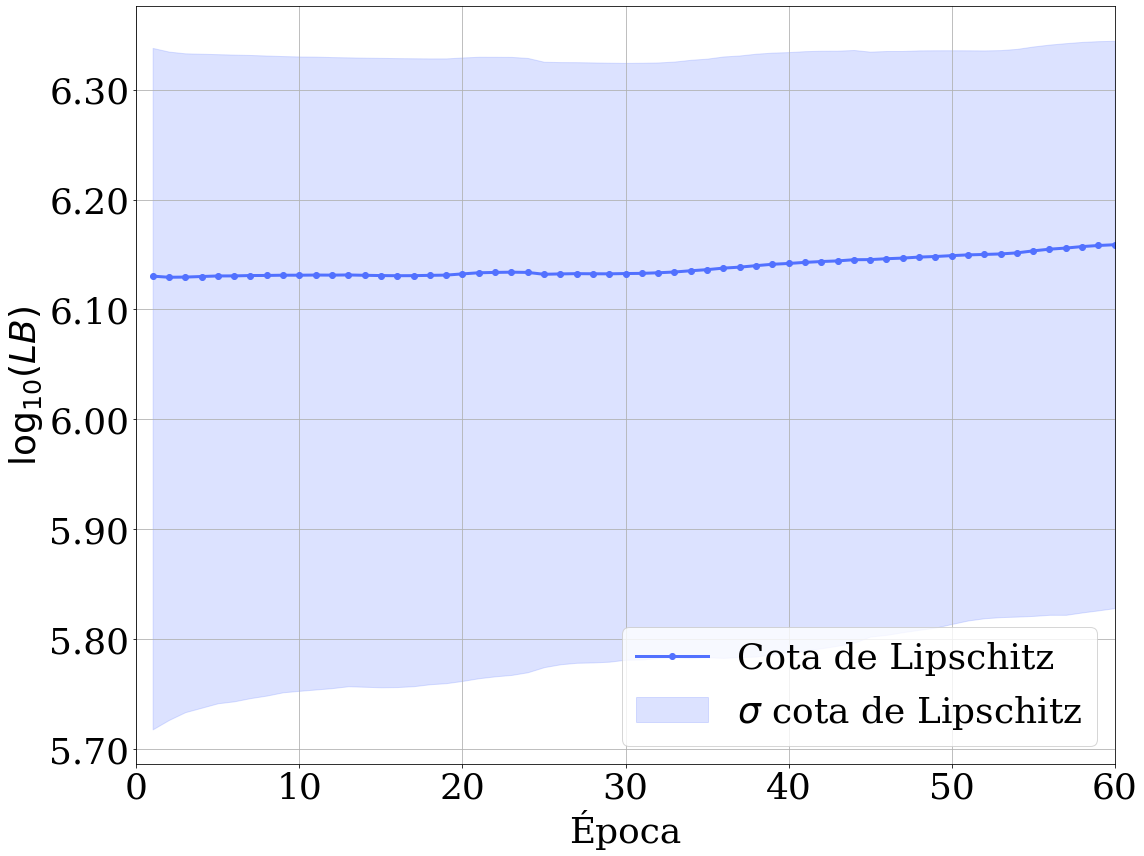

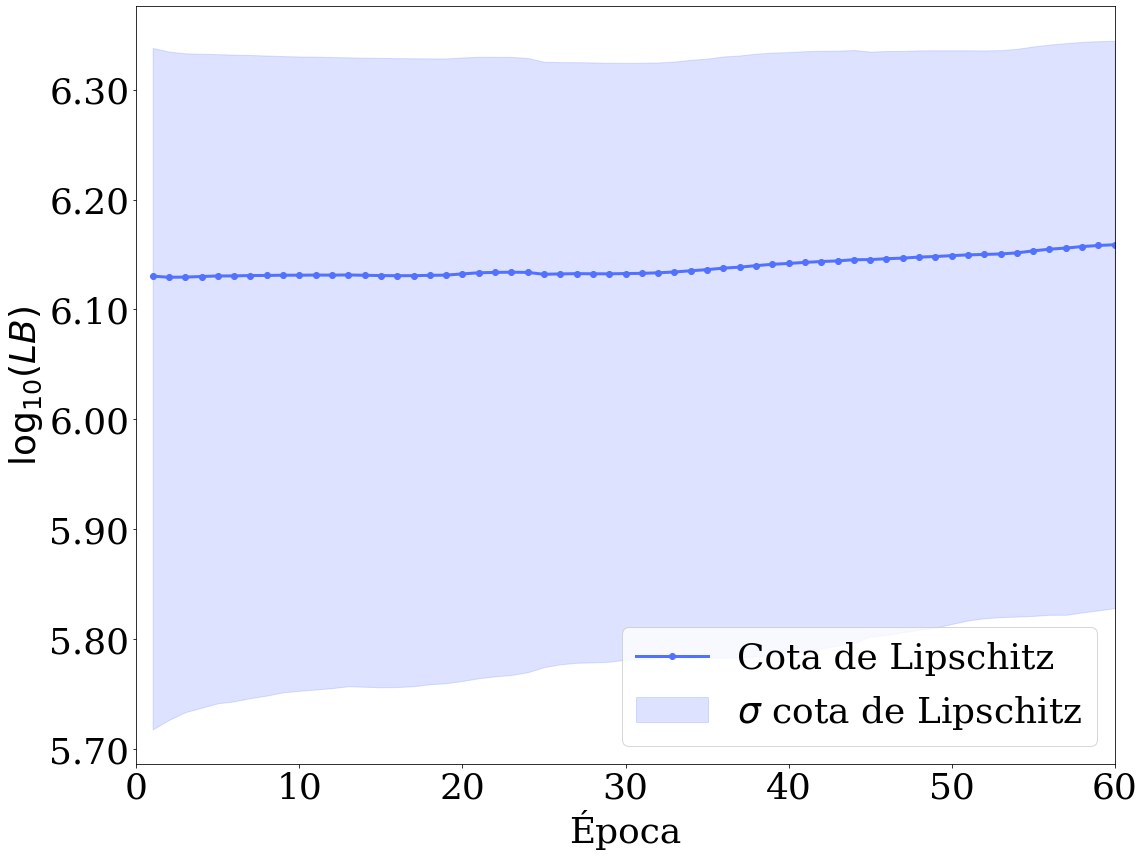

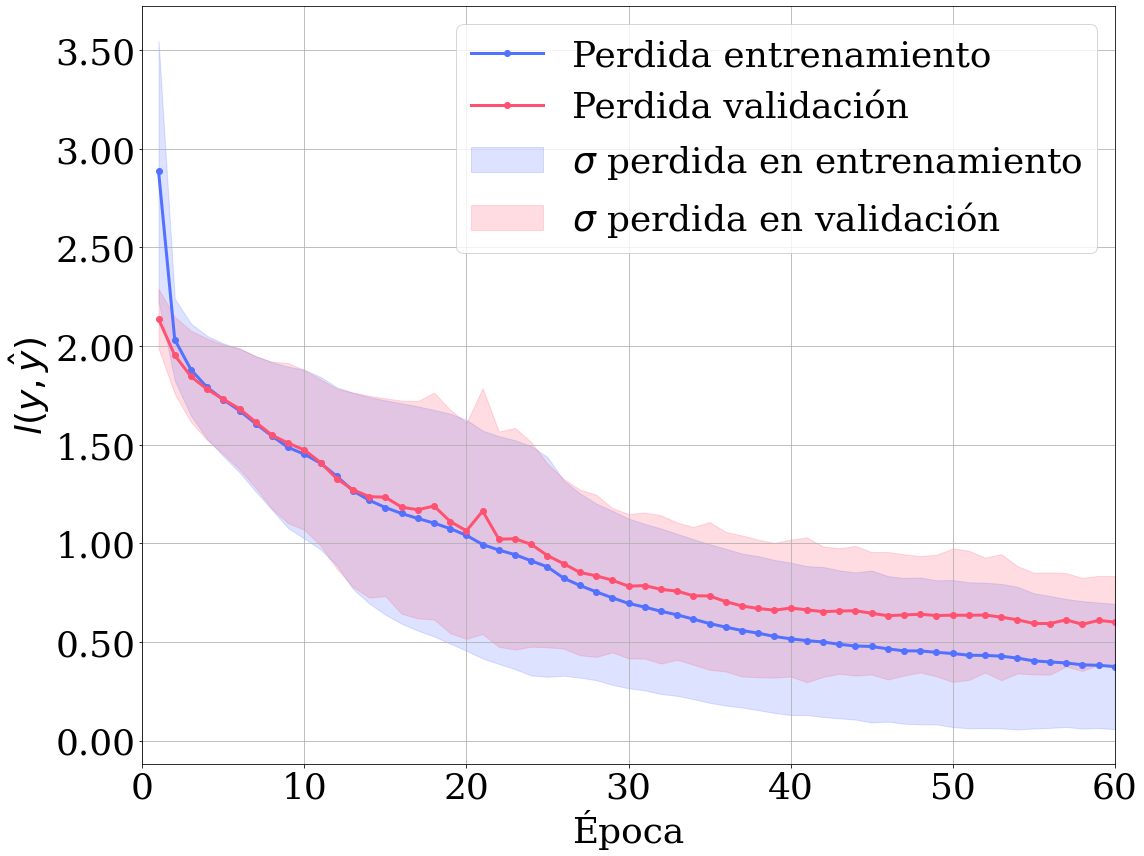

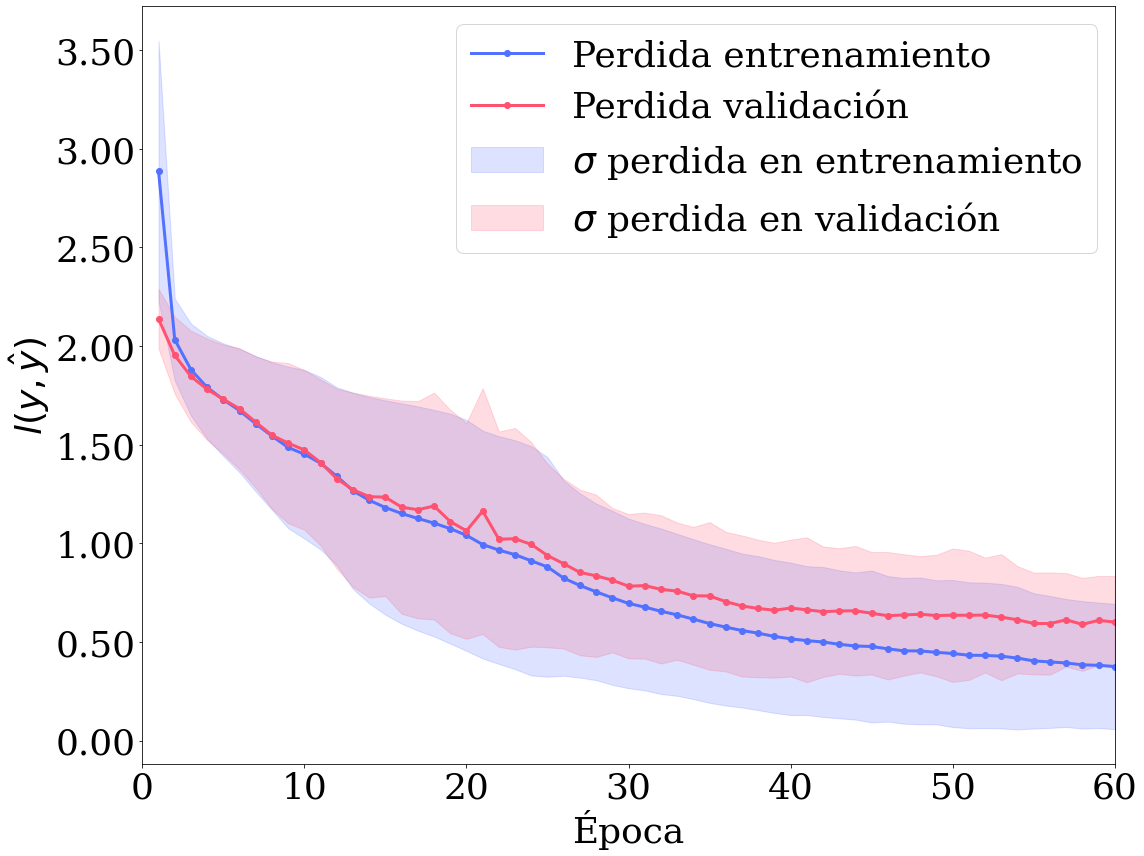

In [ ]:
skips = [2, 4, 6, 8, 10, 12]
n_epochs = 60
resultGeneral = {}
for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')

  for train_index, test_index in kf.split(X_train):
    
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,0)

    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))

    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      for batch in range(n_batches):
        x, y = generator[batch]

        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
        
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()

      y_ = model(X_train[test_index]) # Validation predictions
      loss_val[epoch] = ce_loss(y_true=y_train_onehot[test_index], y_pred=y_).numpy()
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=np.argmax(y_, axis=-1))

    
      LB = lipschitz_bound(model.get_weights())
      
      LB_1[epoch]= LB



    y_test_ = model(X_test)
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1)))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  graphGridAcc(skip)
  graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  graphGridLipschtiz(skip)
  graphLipschtiz(skip)
  graphGridLipschtizlog(skip)
  graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  graphGridLoss(skip)
  graphLoss(skip)

  resultGeneral[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, 
                         Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneral), 'ResultadosExperimentoA.csv')


## Evaluación en test de los modelos 

In [ ]:
for skip in skips:
  mean_test = np.mean(resultGeneral[skip][5])
  std_test = np.std(resultGeneral[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 2, test 91.74 +/- 0.150
Modelo 4, test 91.73 +/- 0.353
Modelo 6, test 90.96 +/- 0.469
Modelo 8, test 89.73 +/- 1.165
Modelo 10, test 88.03 +/- 0.783
Modelo 12, test 82.06 +/- 8.949


## Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = np.mean([resultGeneral[skip][0][x][-1] for x in resultGeneral[2][0]])
  std_train = np.std([resultGeneral[skip][0][x][-1] for x in resultGeneral[2][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 2, train 95.18 +/- 0.293
Modelo 4, train 96.70 +/- 0.526
Modelo 6, train 97.44 +/- 0.346
Modelo 8, train 97.28 +/- 0.865
Modelo 10, train 94.67 +/- 1.412
Modelo 12, train 87.72 +/- 10.659


## Entrenamiento de modelos vs tamaño de muestras 

In [ ]:
def graphGridAccSample(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ precisión entrenamiento',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ precisión validación',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Número de muestras',fontsize=36)
  plt.ylabel(r'Precisión',fontsize=36)
  plt.xlim([2000, 10000])
  #plt.ylim(top=1)
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(10000*np.arange(0.2,1.2,0.2), fontsize=36)
  plt.yticks(fontsize=36)
  plt.grid()
  nameFile = 'presicionModeloSample' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()


def graphAccSample(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ precisión entrenamiento',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ precisión validación',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Número de muestras',fontsize=36)
  plt.ylabel(r'Precisión',fontsize=36)
  plt.xlim([2000, 10000])
  #plt.ylim(top=1)
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(10000*np.arange(0.2,1.2,0.2), fontsize=36)
  plt.yticks(fontsize=36)
  nameFile = 'presicionModeloSample' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

In [ ]:
def graphGridLipschtizSample(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Número de muestras',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([2000, 10000])
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(10000*np.arange(0.2,1.2,0.2), fontsize=36)
  plt.yticks(fontsize=36)
  #plt.ticklabel_format(axis = 'y', style = 'scientific')
  plt.grid()
  nameFile = 'cotaLipschitzModeloSample' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLipschtizSample(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Número de muestras',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([2000, 10000])
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(10000*np.arange(0.2,1.2,0.2), fontsize=36)
  plt.yticks(fontsize=36)
  #plt.ticklabel_format(axis = 'y', style = 'scientific')
  plt.grid()
  nameFile = 'cotaLipschitzModeloSample' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

In [ ]:
def graphGridLossSample(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ perdida en entrenamiento', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([2000, 10000])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(10000*np.arange(0.2,1.2,0.2), fontsize=36)
  plt.yticks(fontsize=36)
  #plt.ticklabel_format(axis = 'y', style = 'scientific')
  plt.grid()
  nameFile = 'funcionPerdidaModeloSample' + str(skip) + 'G' + '.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLossSample(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = 'Desviación estandar perdida en entrenamiento', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = 'Desviación estandar perdida en entrenamiento',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([2000, 10000])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(10000*np.arange(0.2,1.2,0.2), fontsize=36)
  plt.yticks(fontsize=36)
  #plt.ticklabel_format(axis = 'y', style = 'scientific')
  nameFile = 'funcionPerdidaModeloSample' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

Modelo : 2 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 2 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 2 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 2 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 2 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 4 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 4 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=F

<ipython-input-53-169058977222>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-53-169058977222>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-54-1ff660d16733>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.f

Modelo : 10 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 10 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 10 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 10 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 10 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----


<ipython-input-52-aa8607b6a1ce>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-52-aa8607b6a1ce>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-53-169058977222>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.f

Modelo : 12 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 12 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 12 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 12 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
Modelo : 12 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----


<ipython-input-52-aa8607b6a1ce>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-52-aa8607b6a1ce>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-53-169058977222>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.f

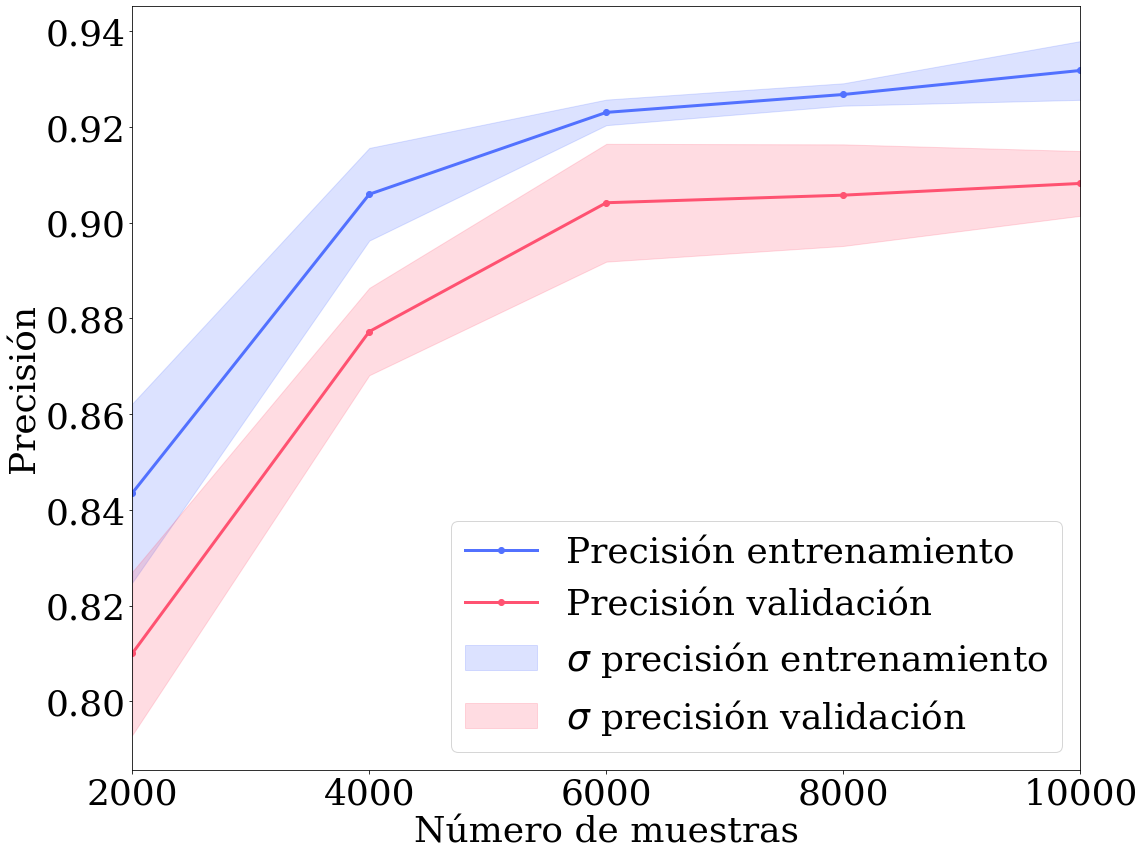

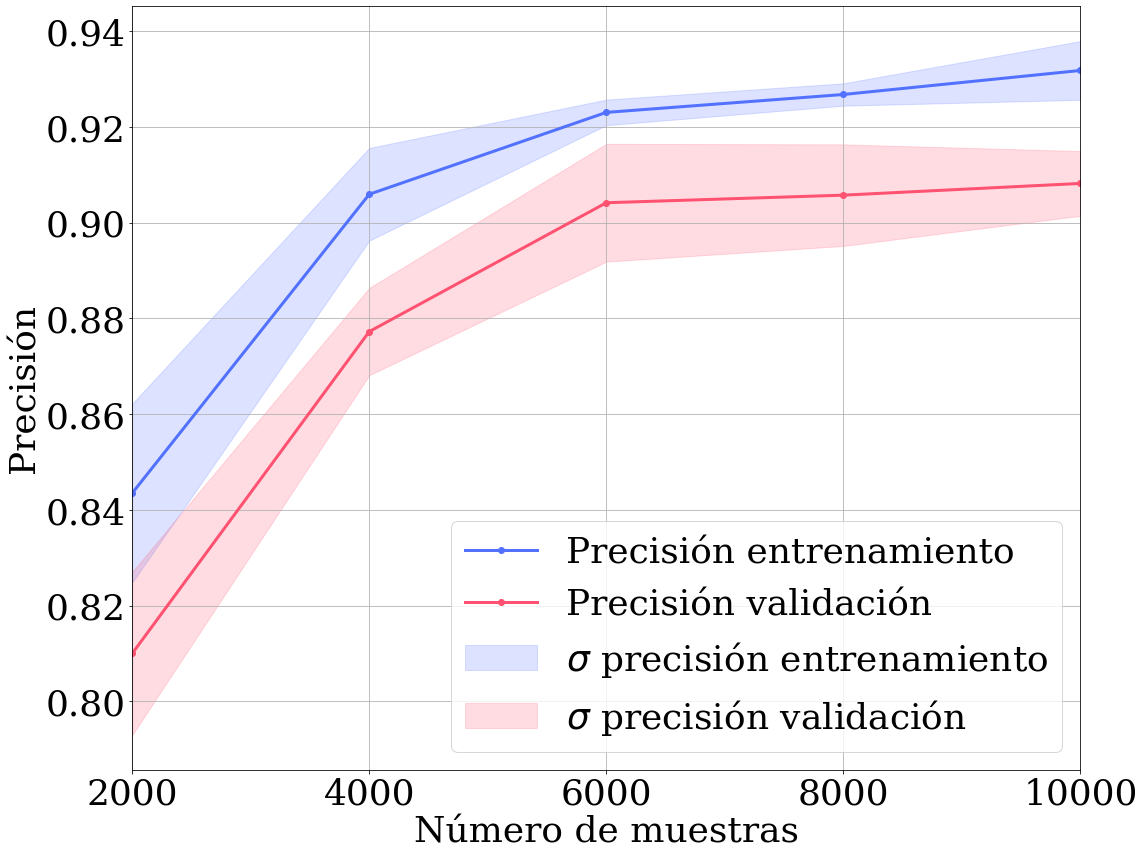

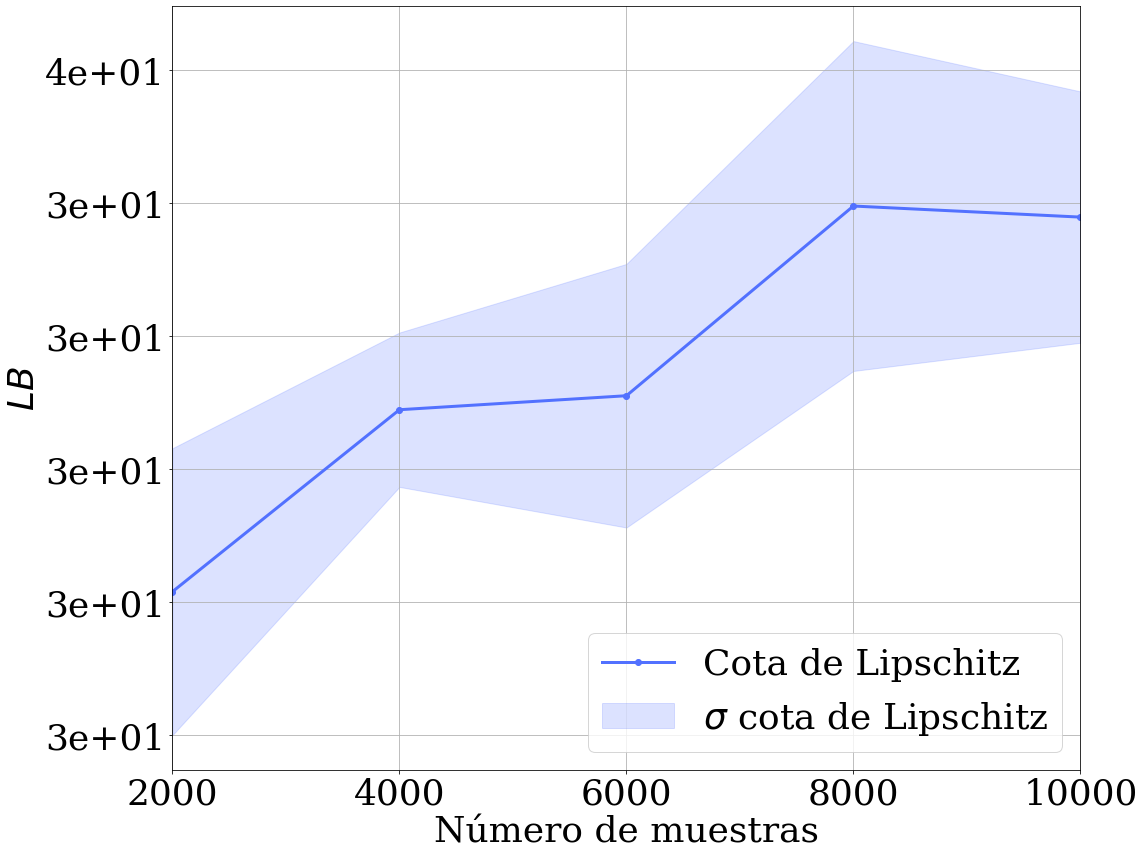

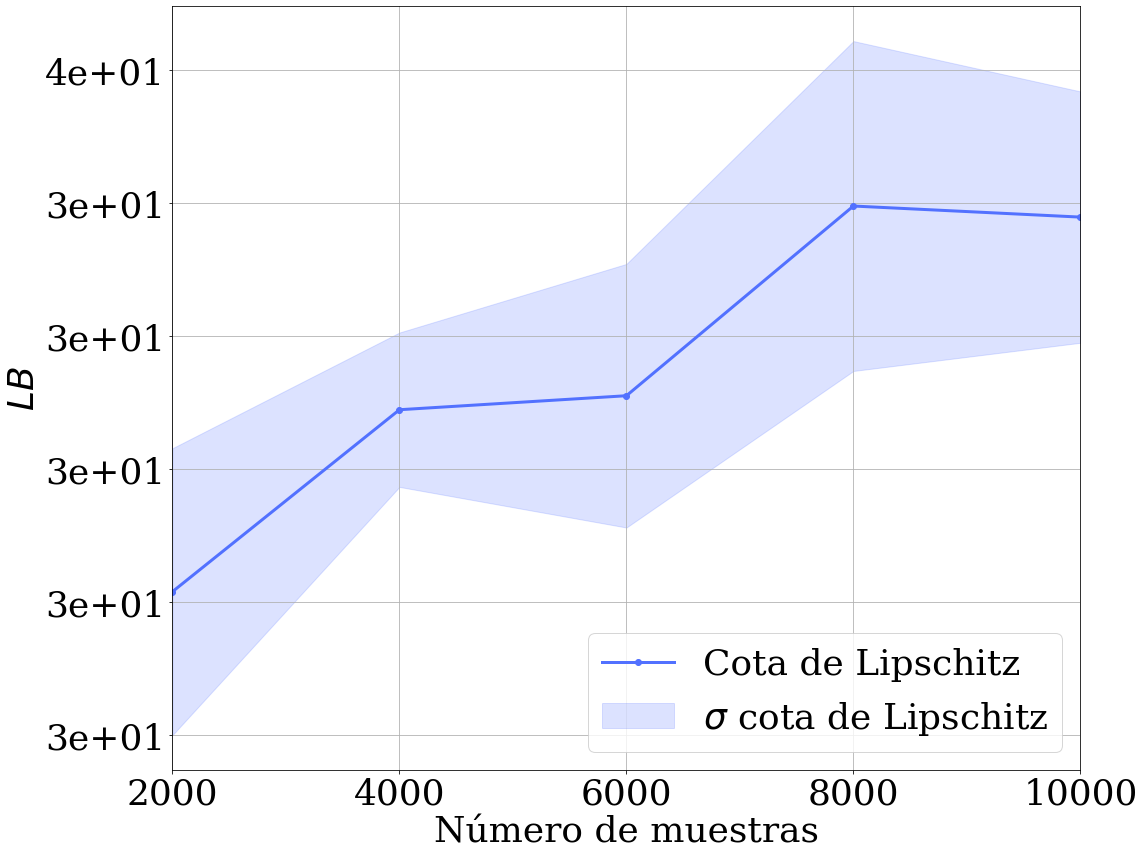

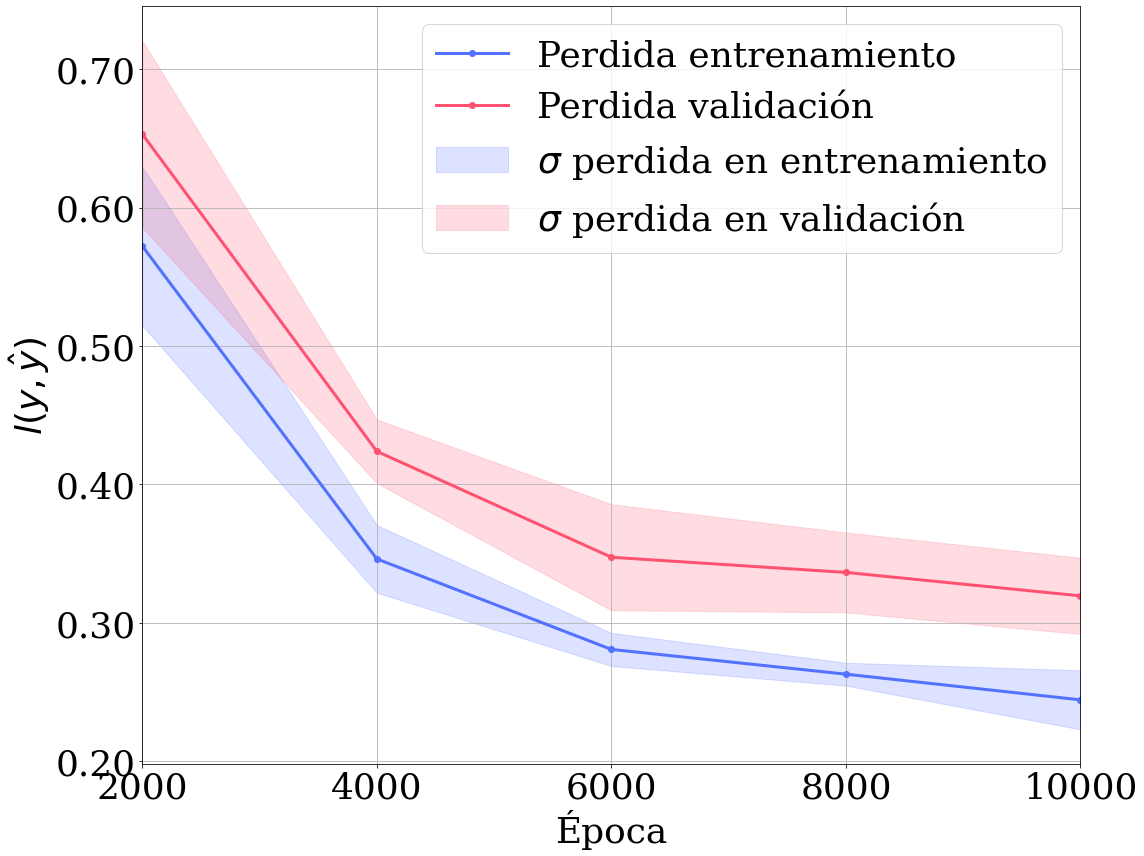

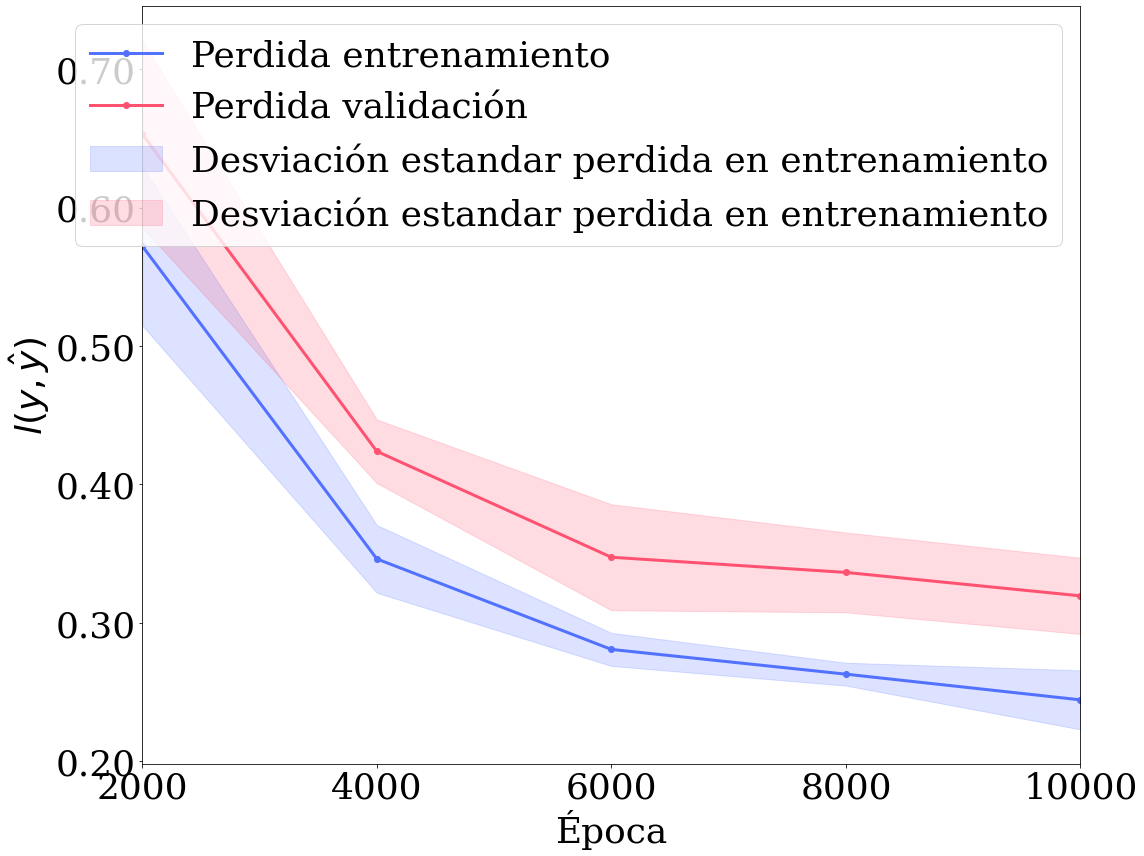

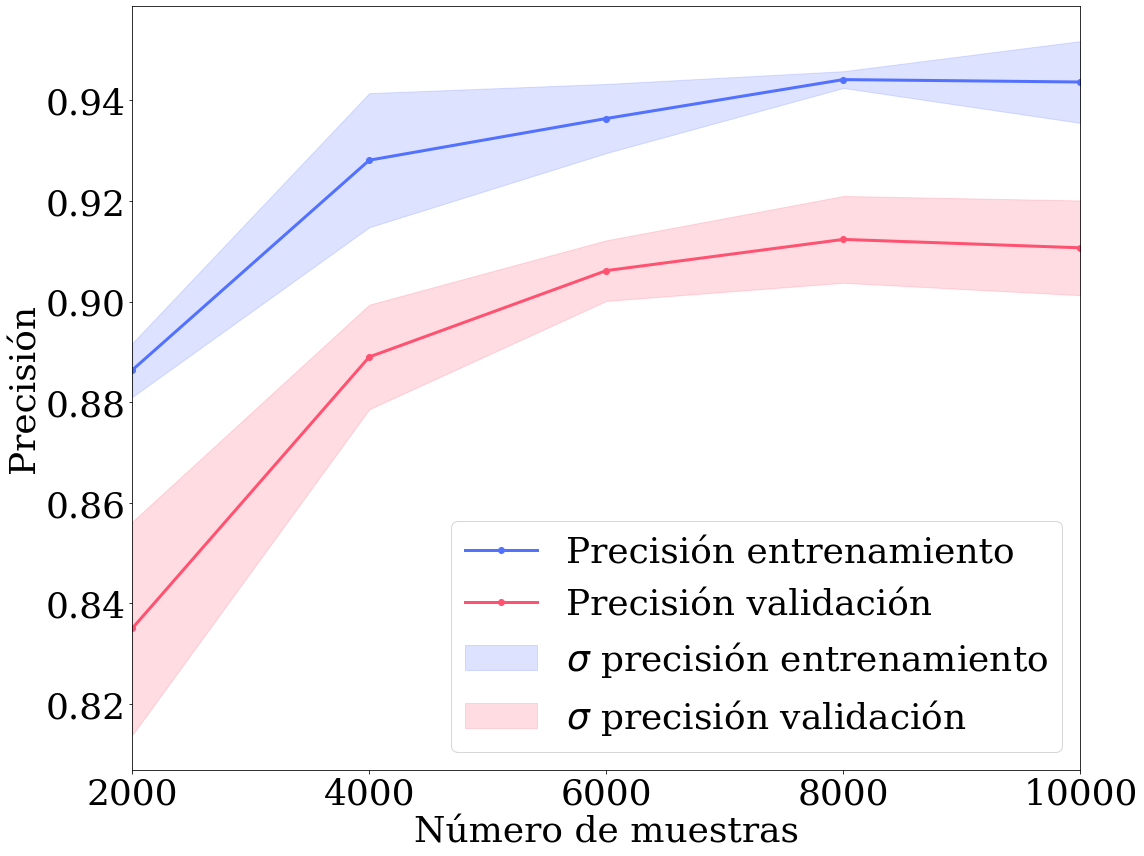

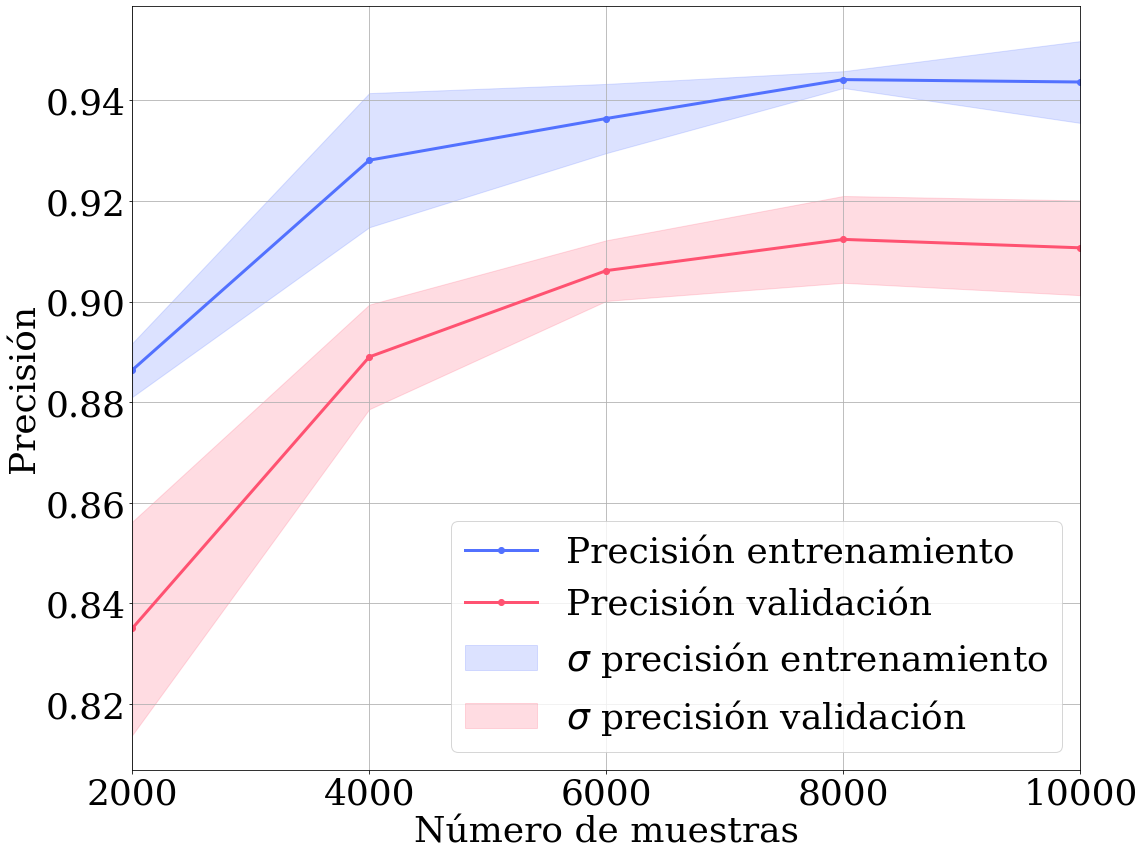

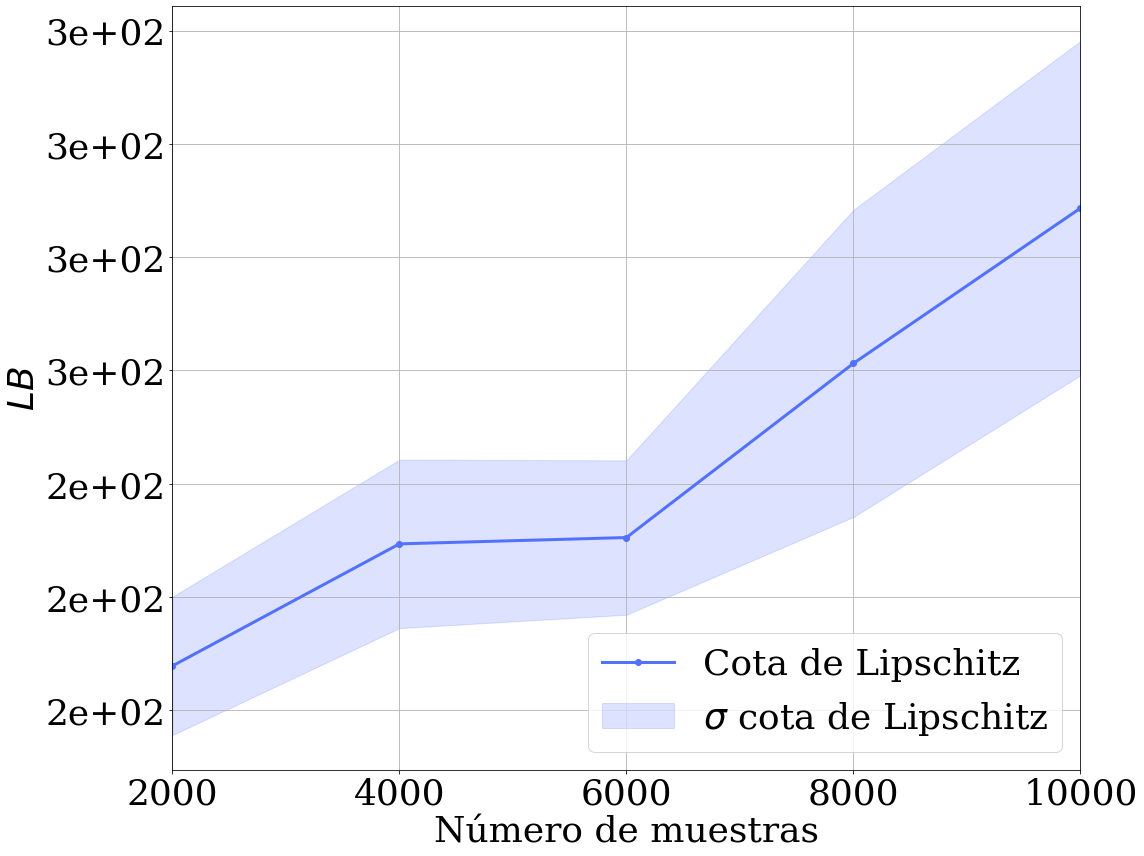

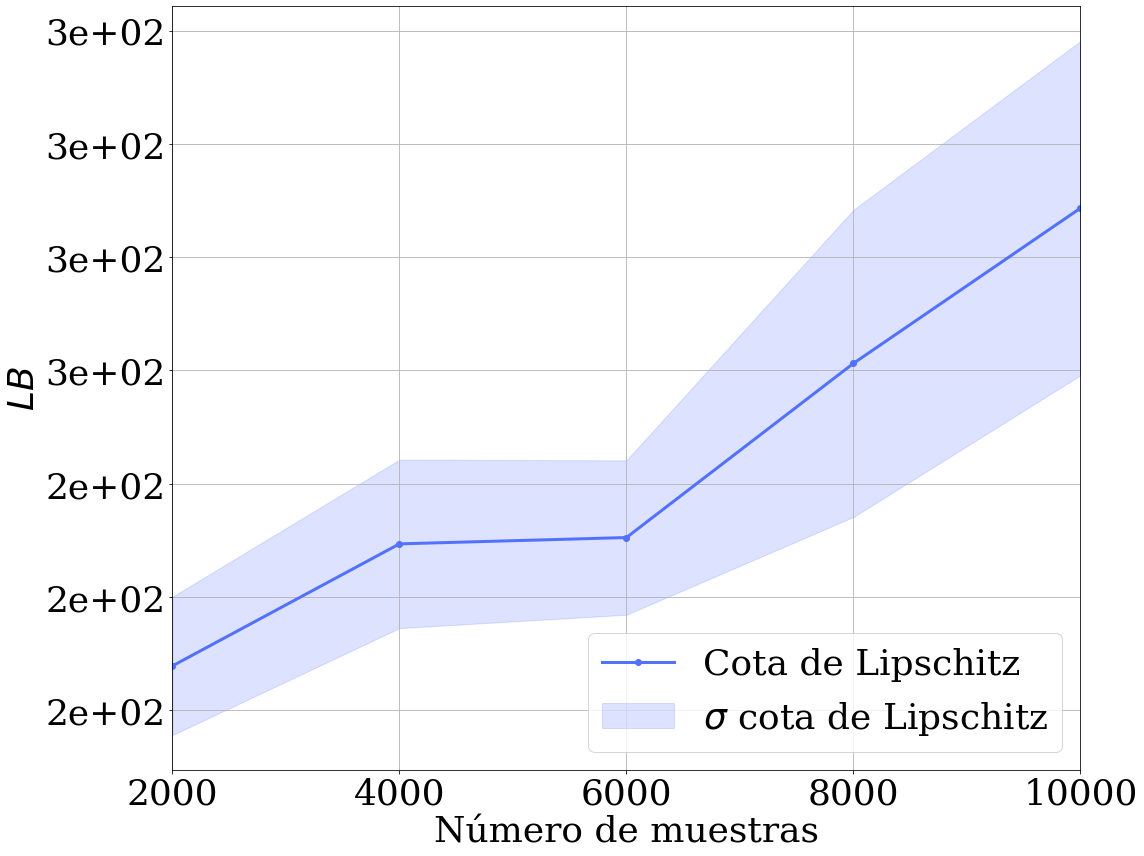

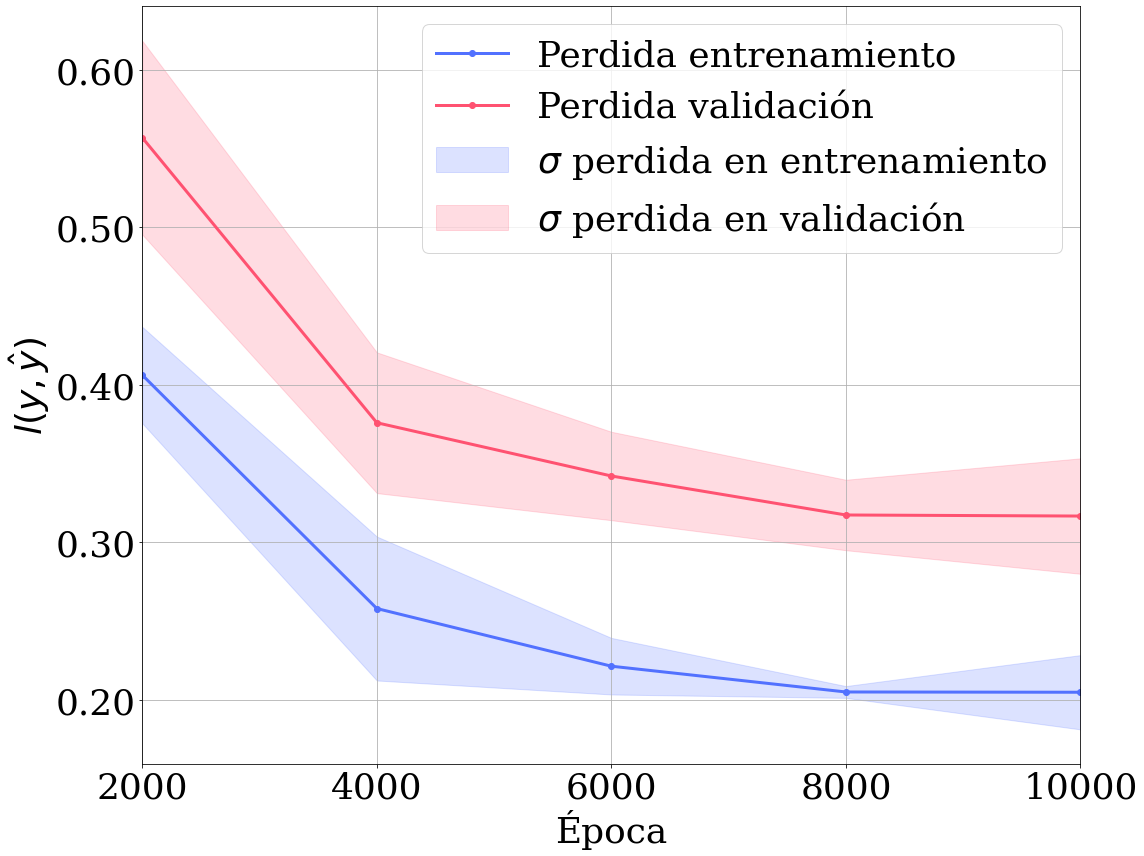

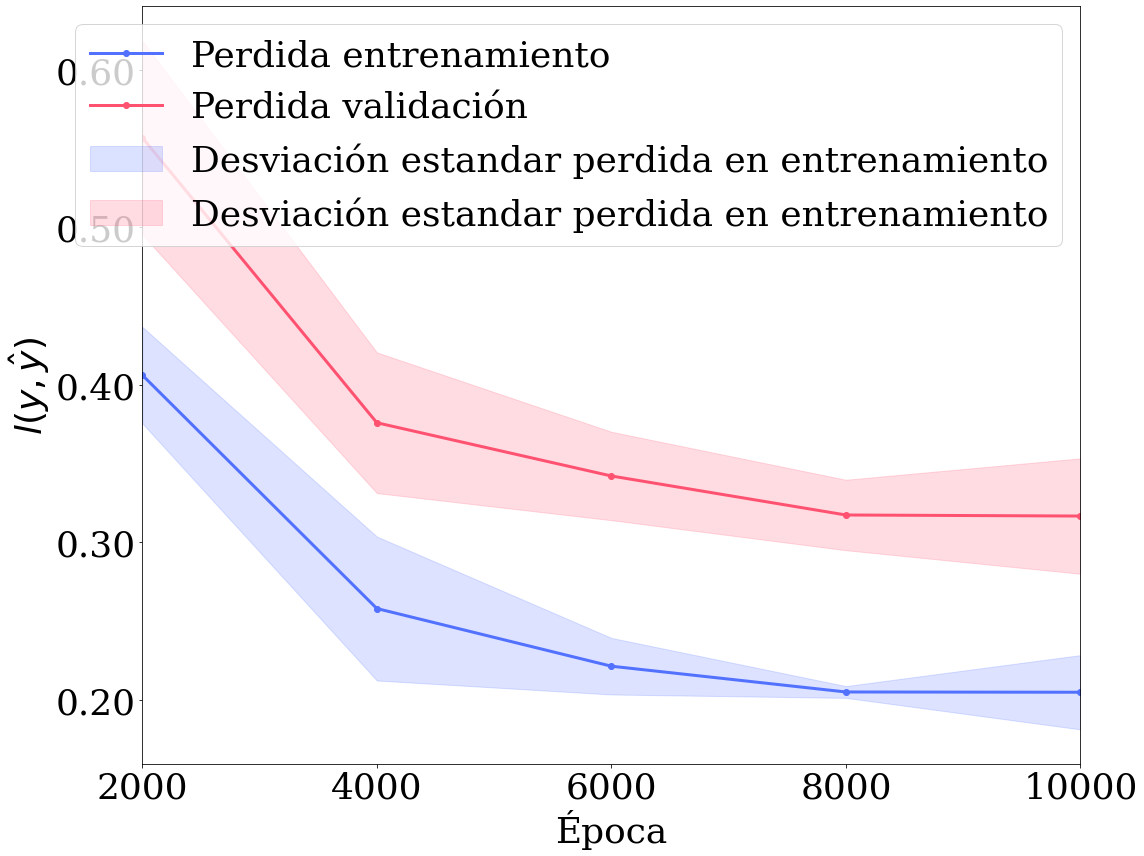

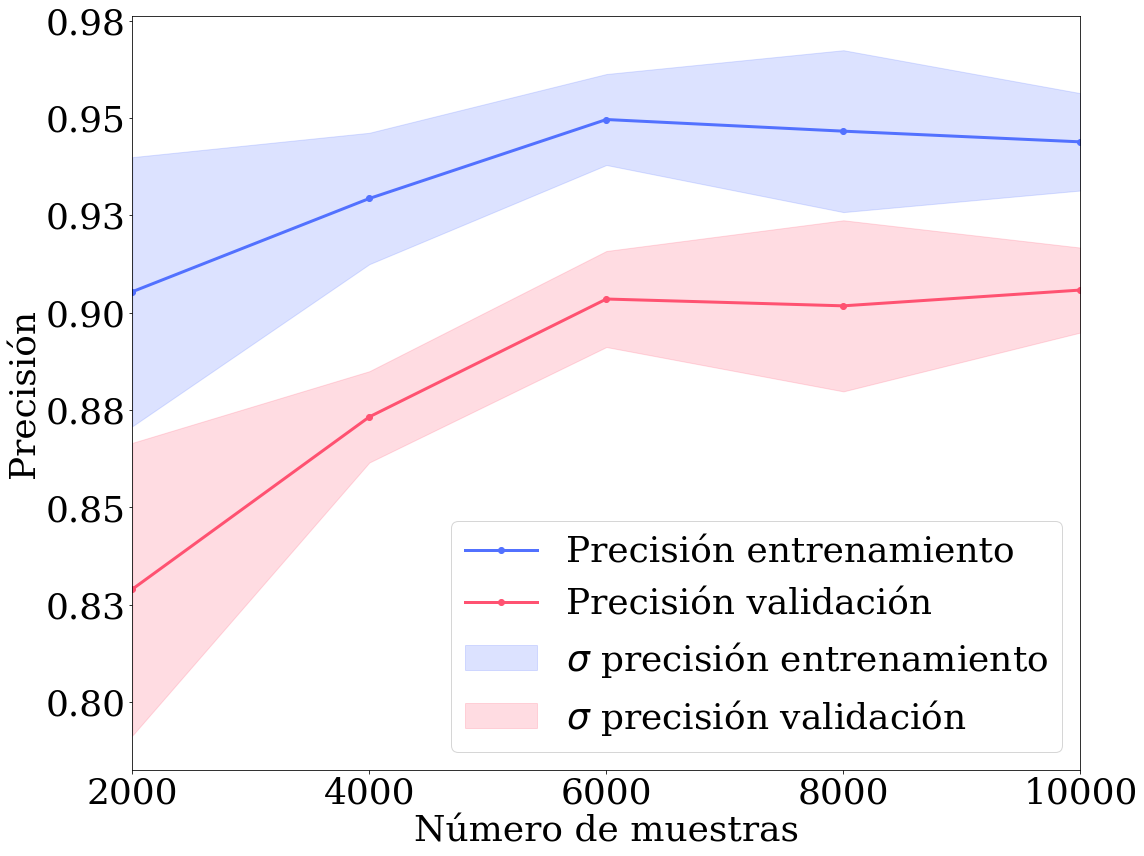

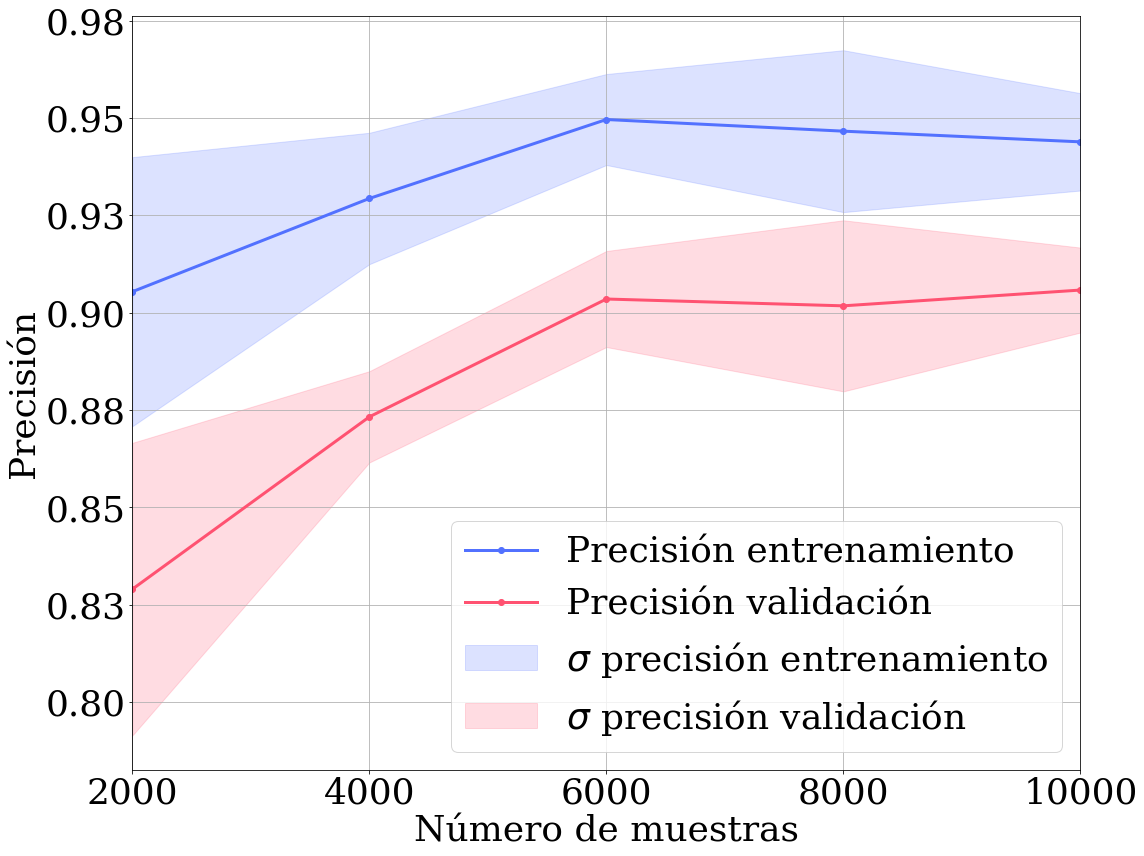

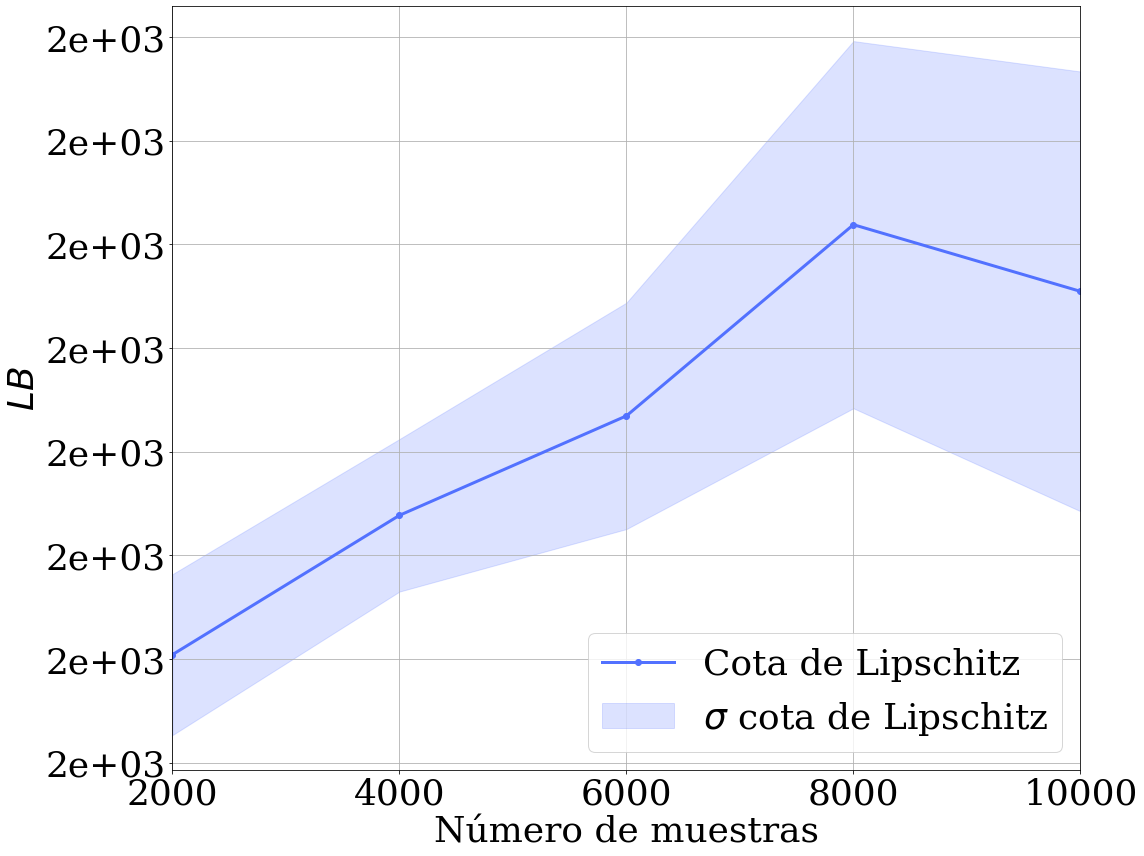

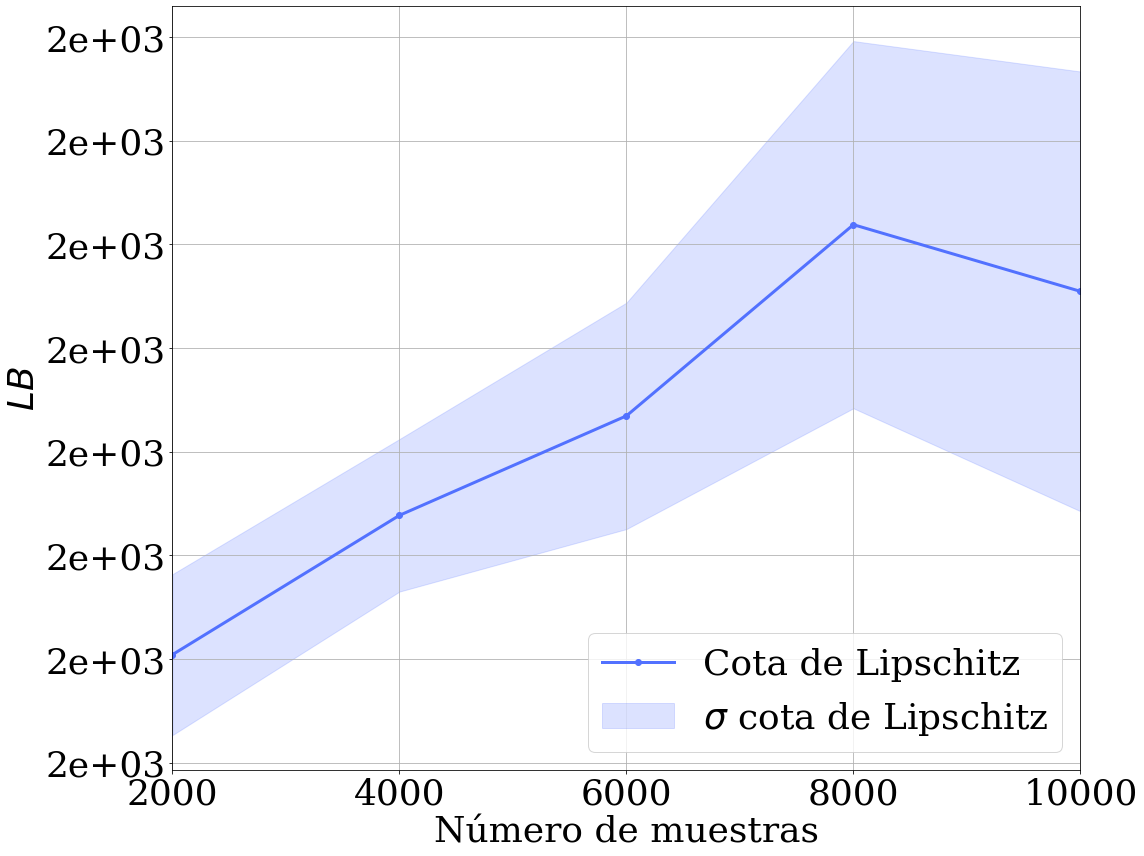

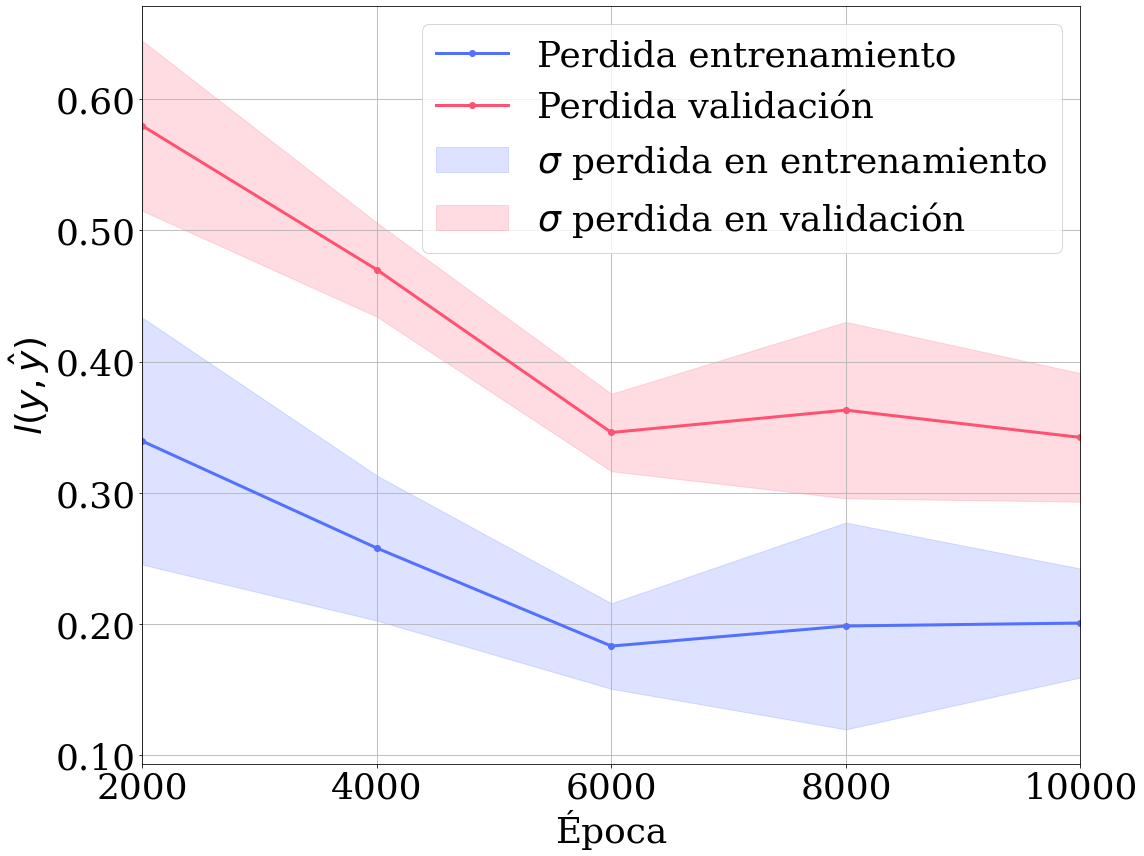

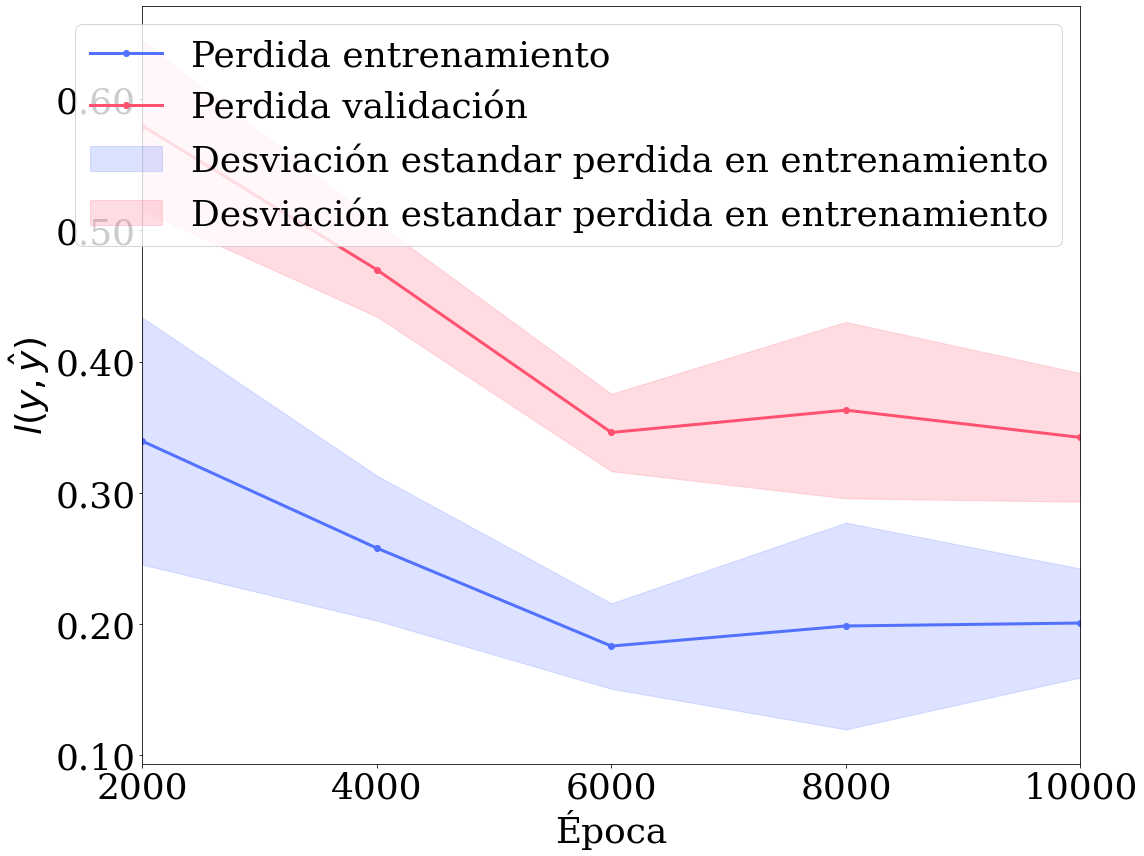

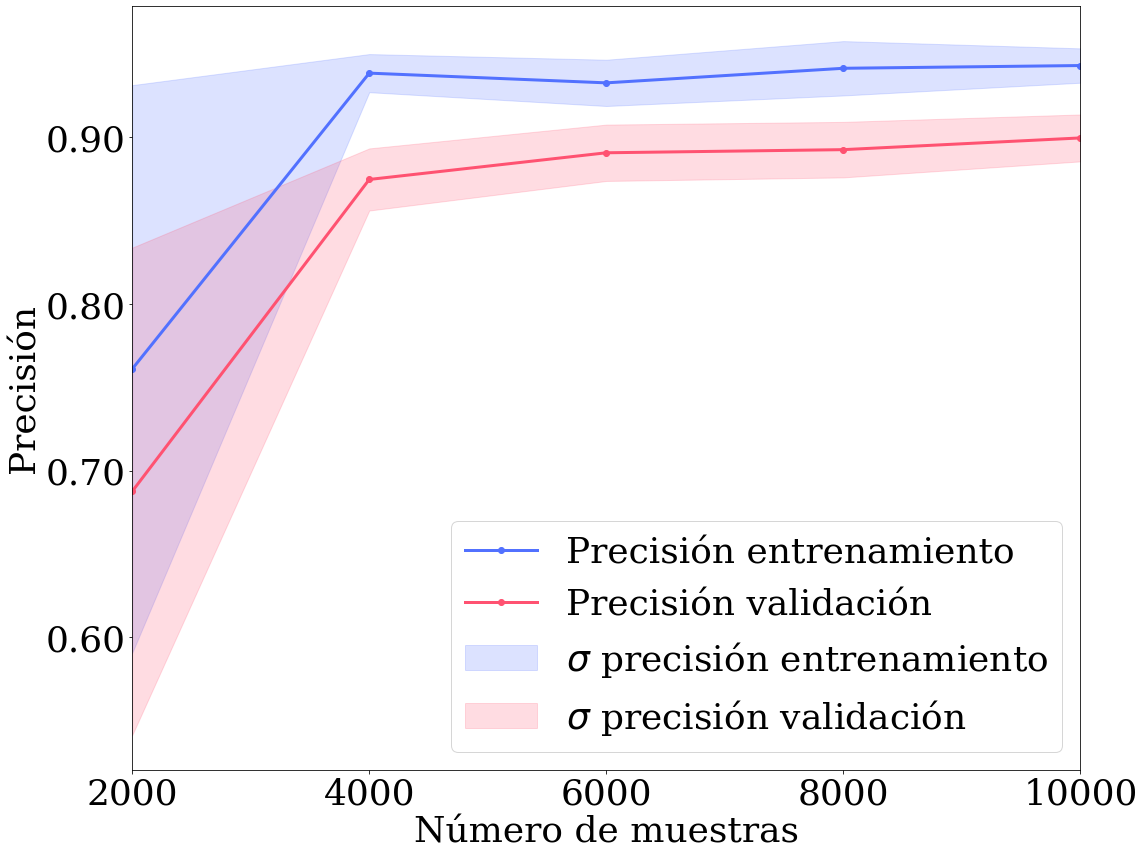

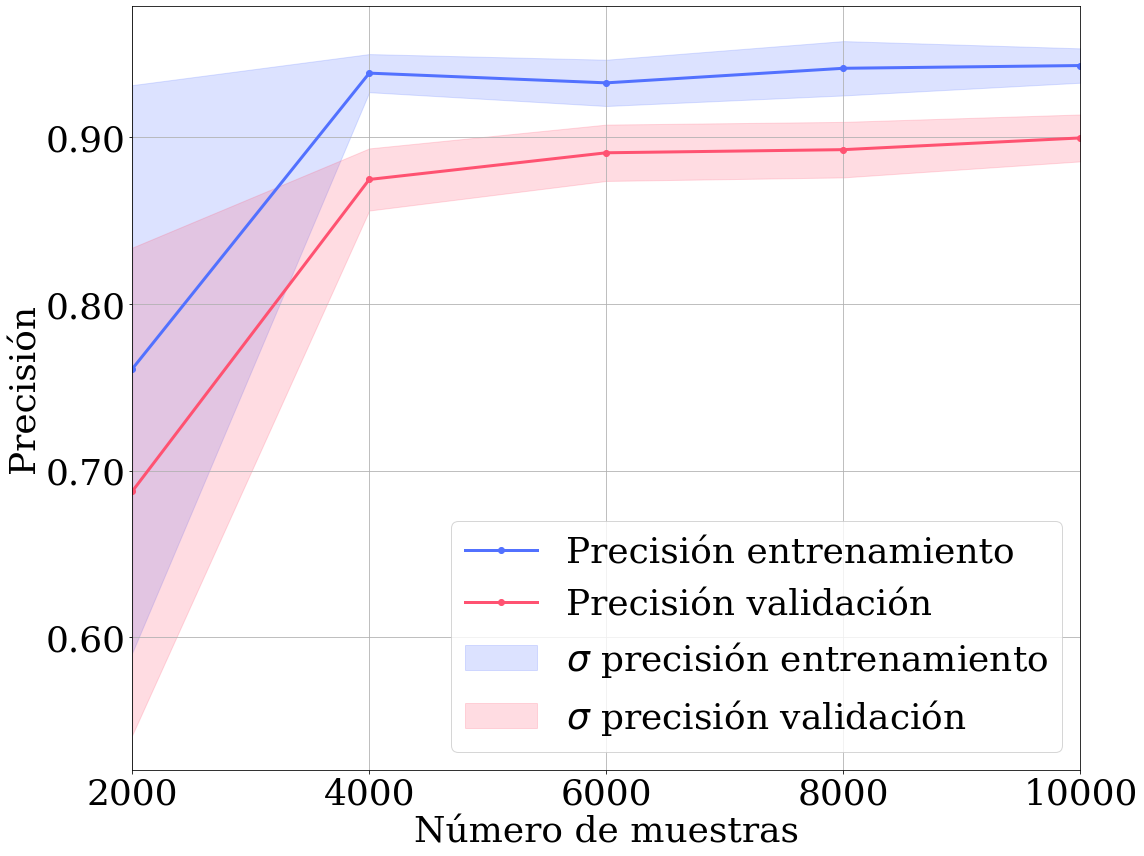

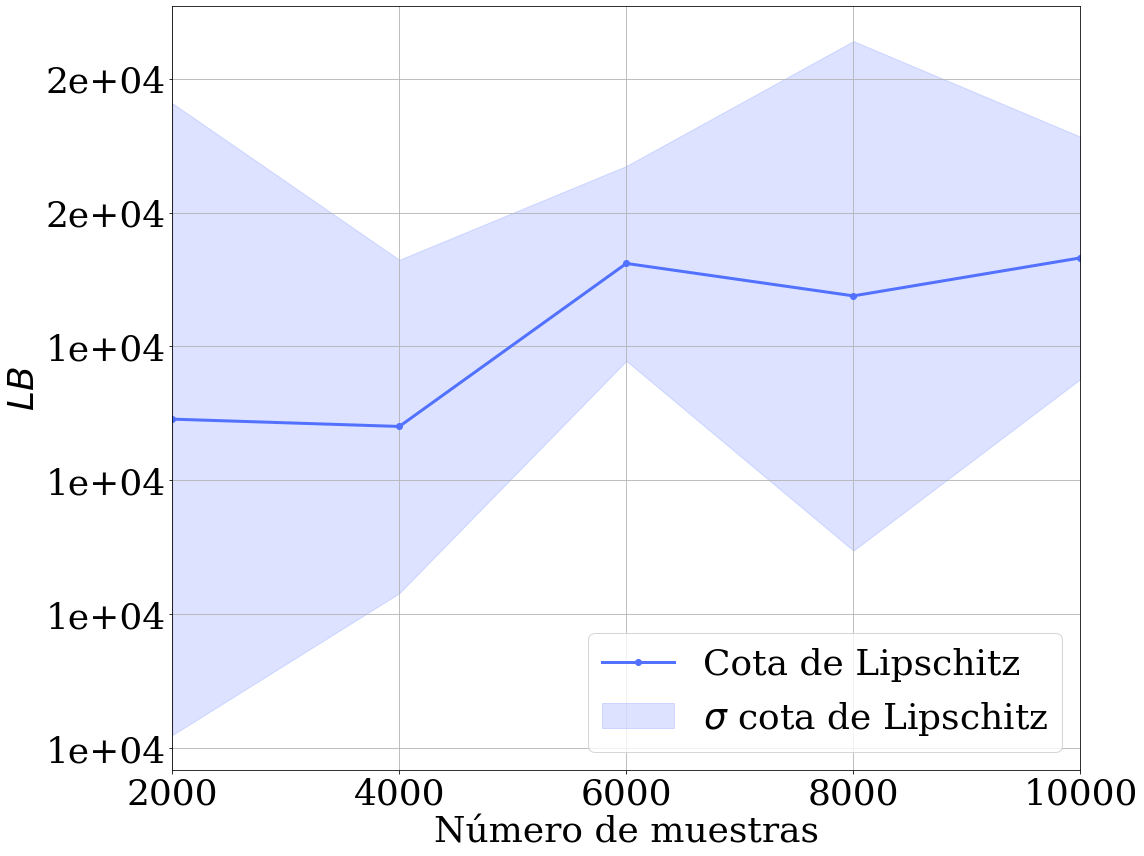

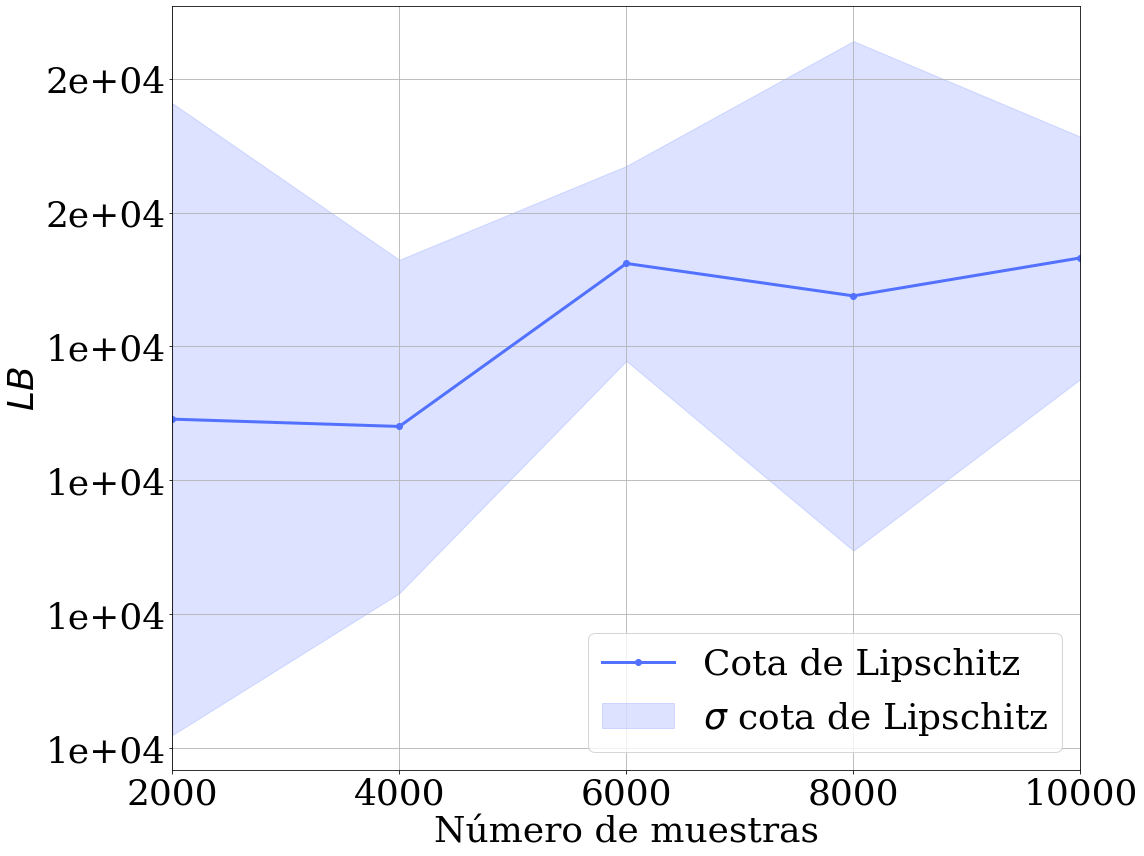

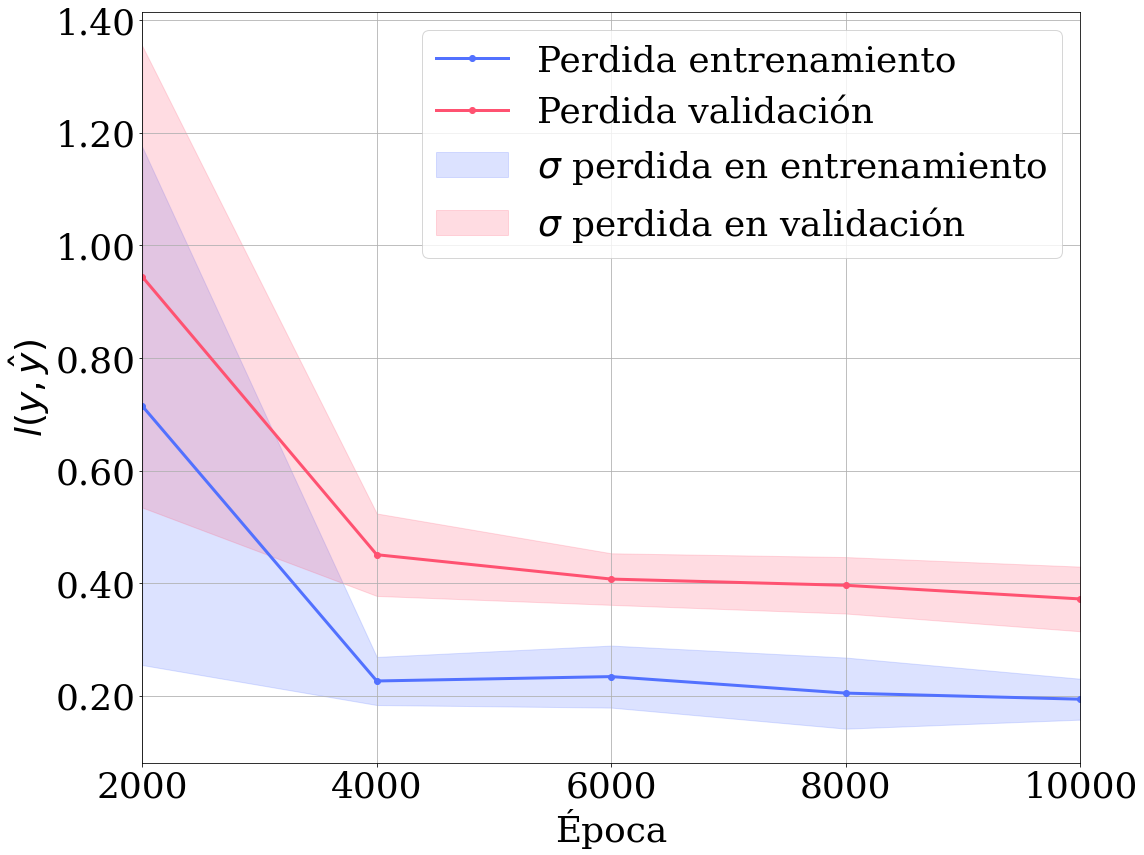

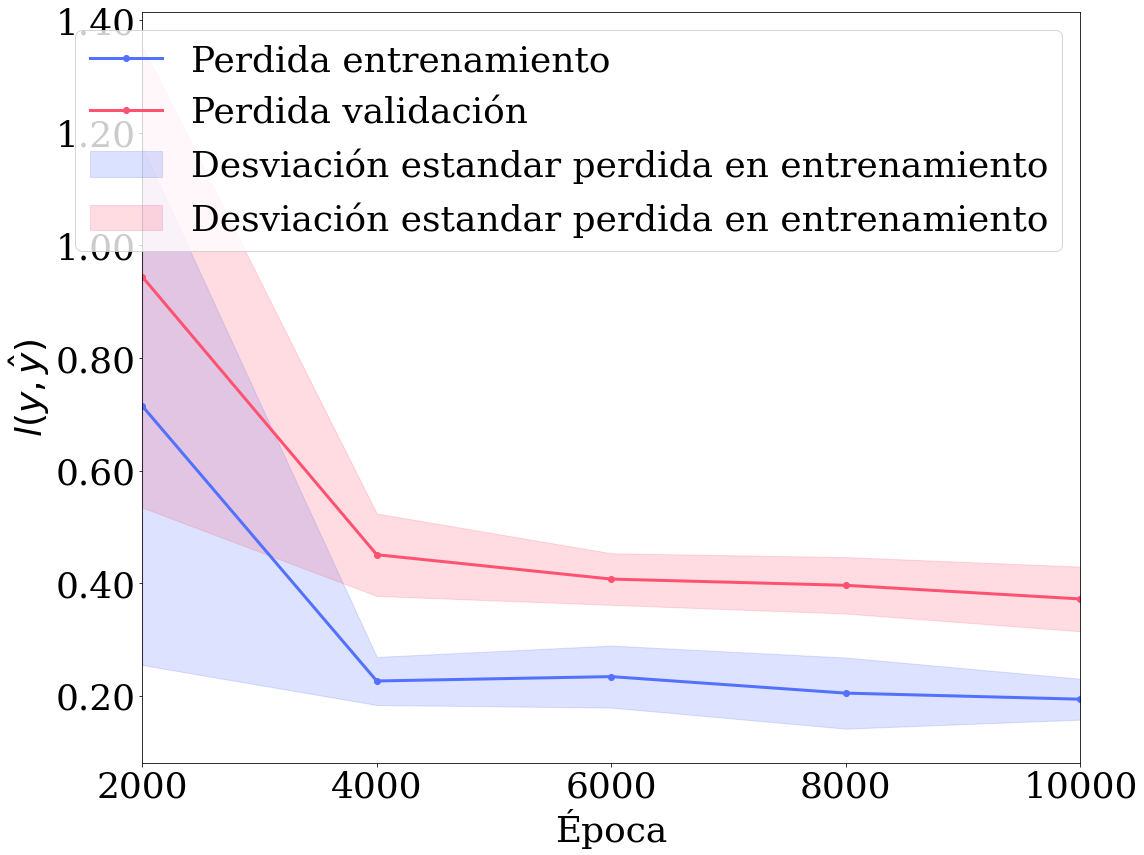

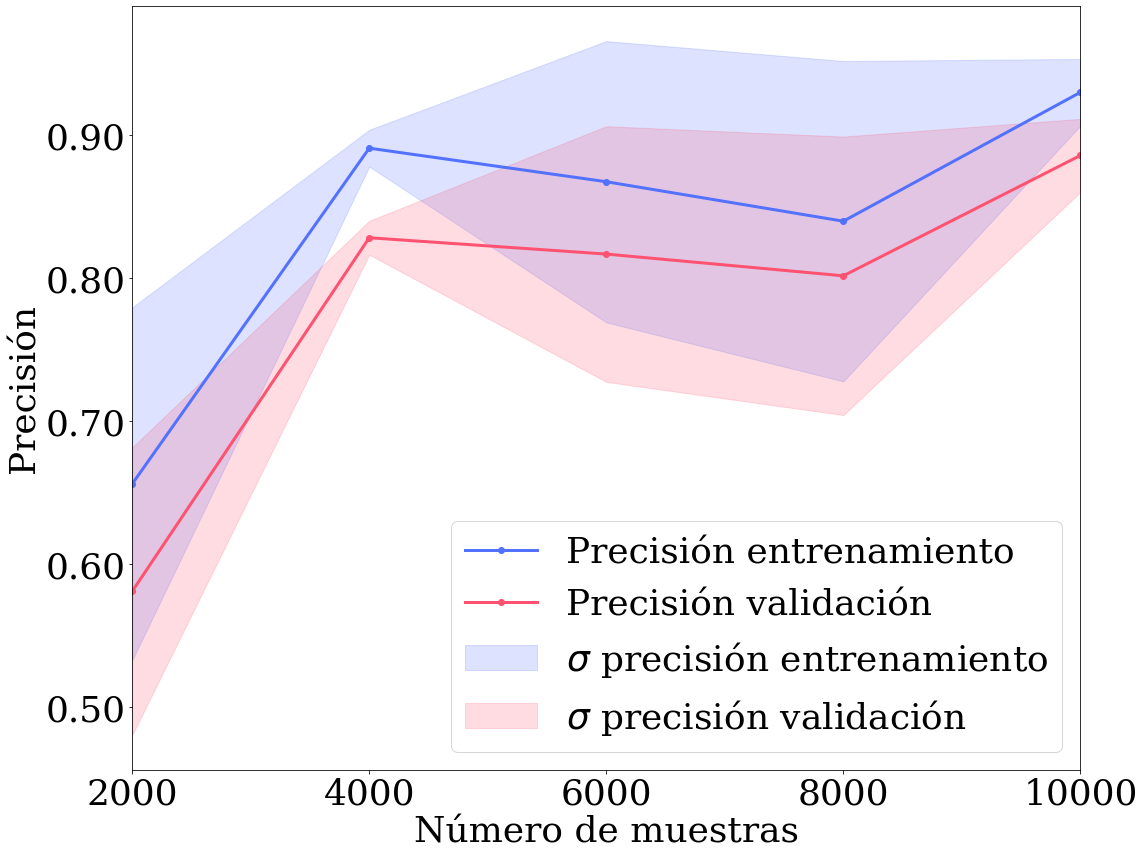

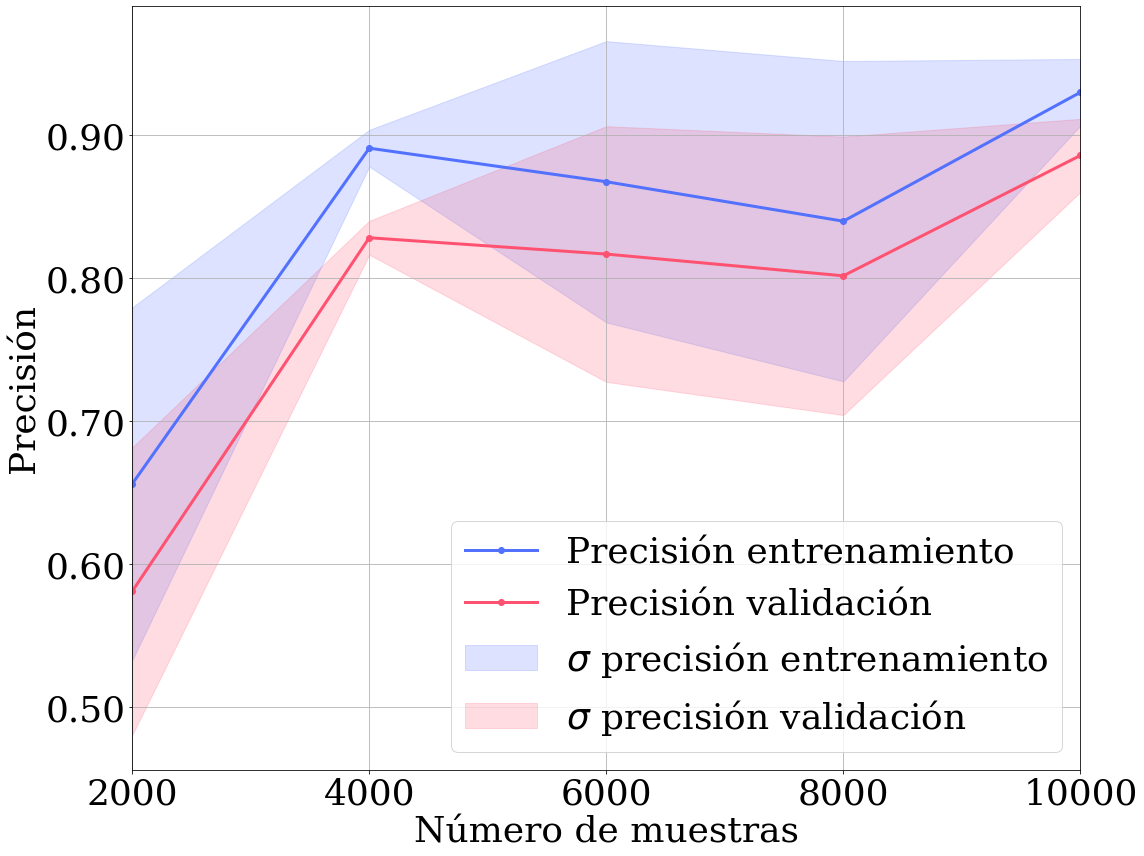

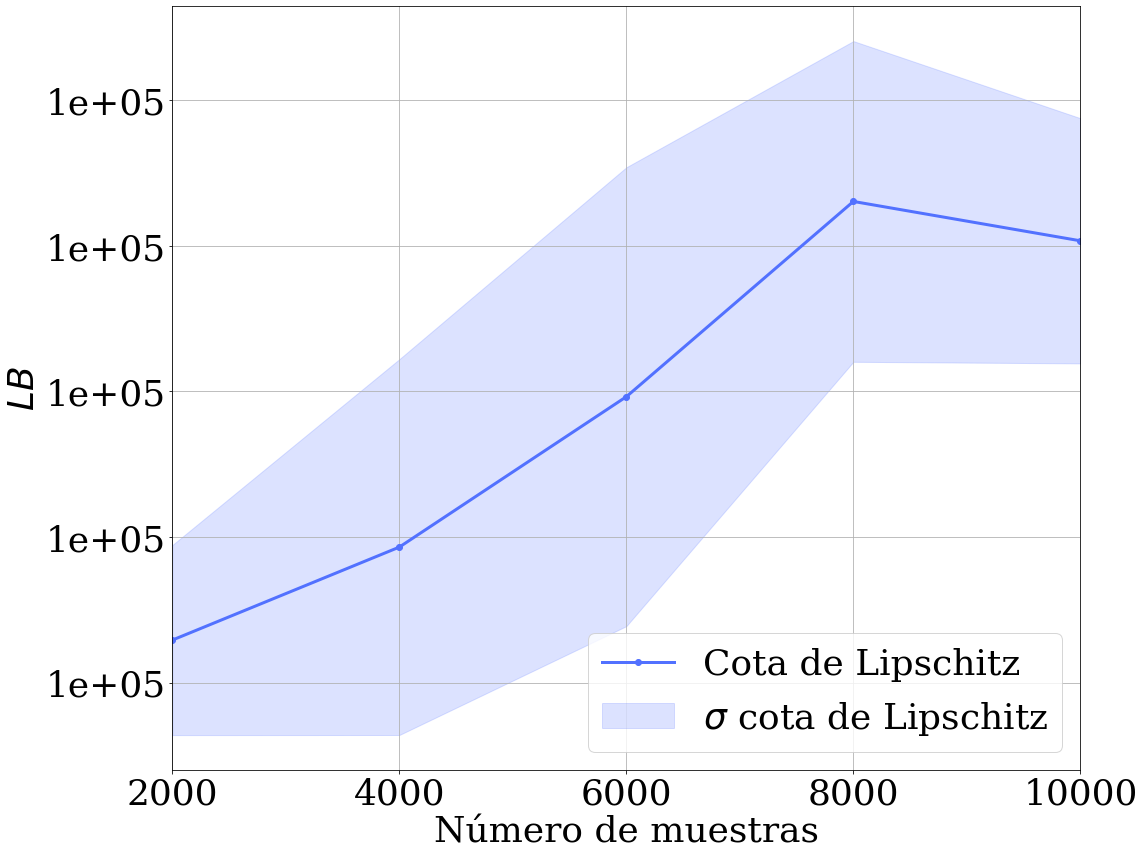

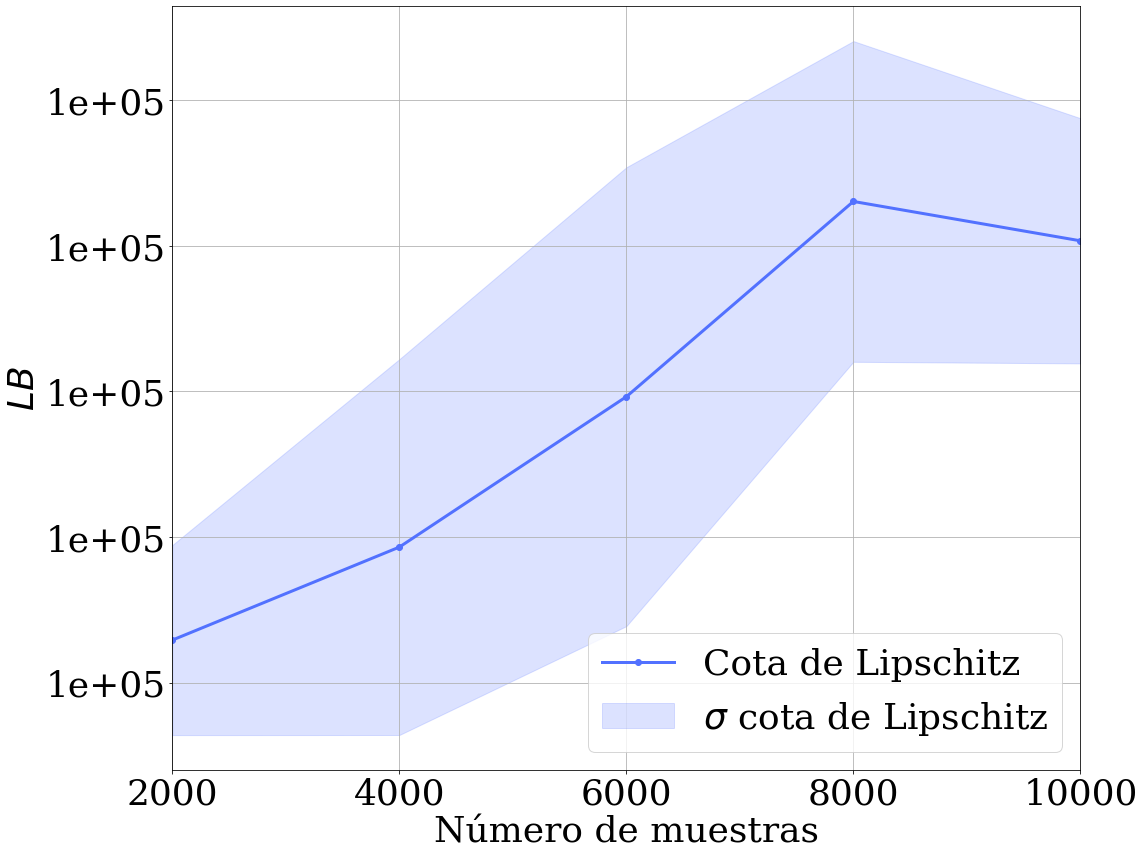

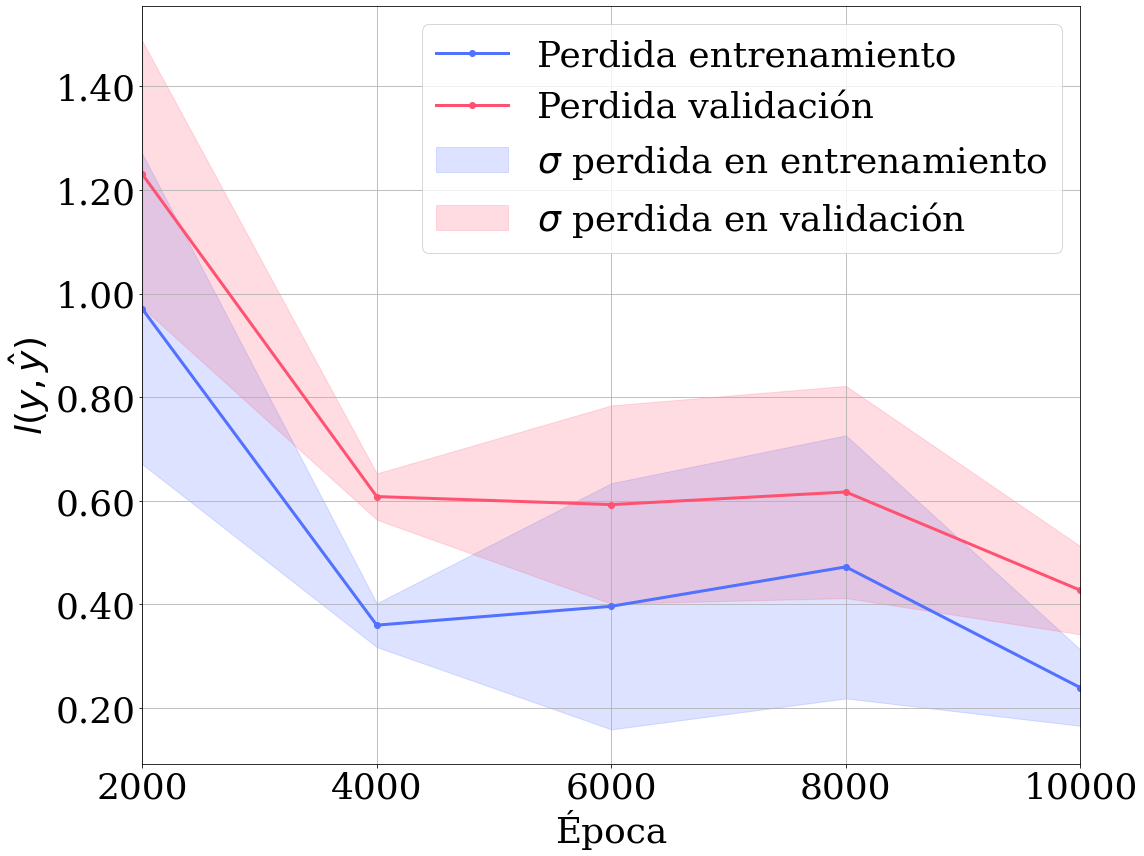

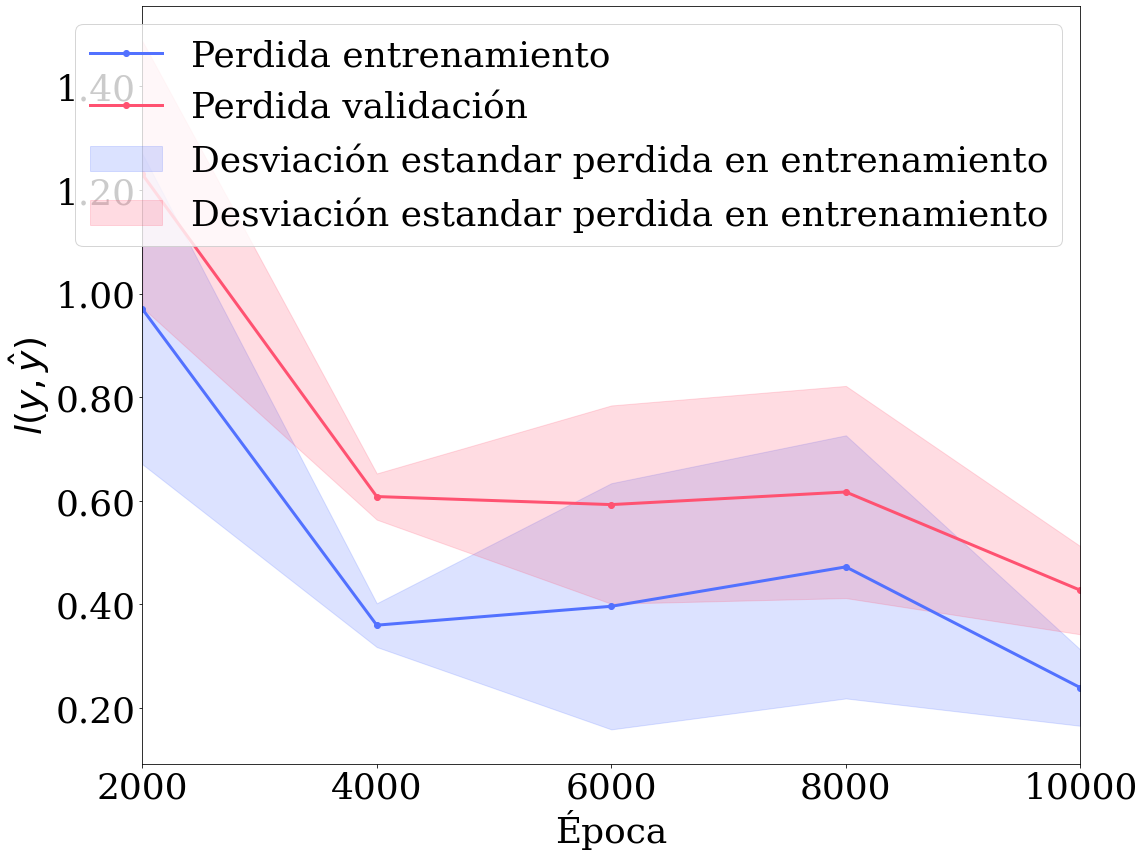

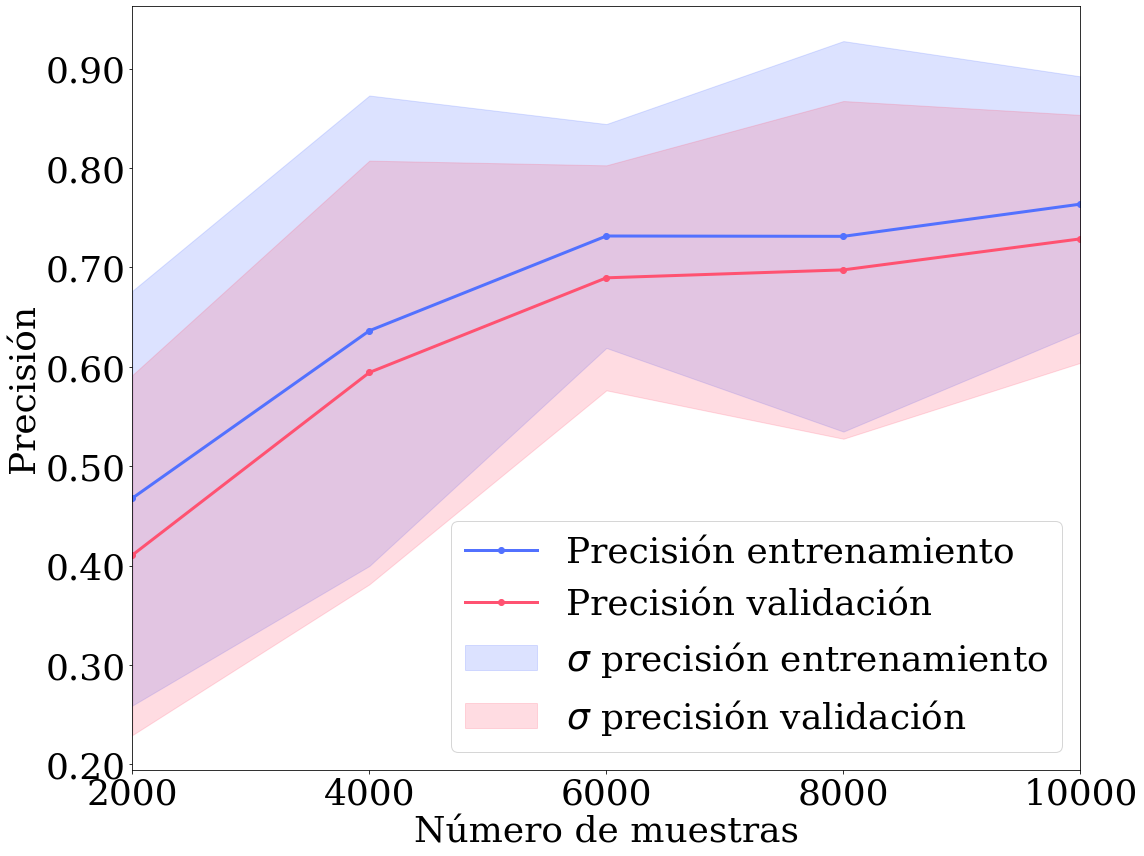

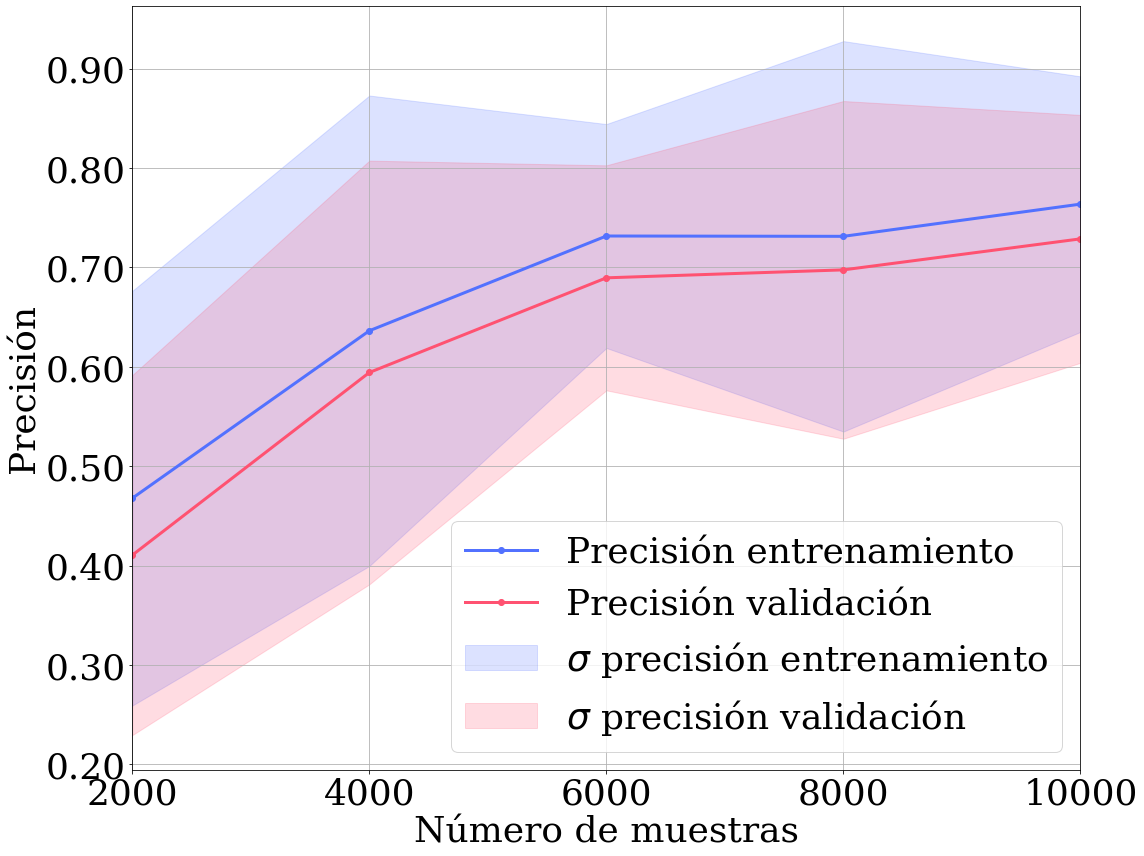

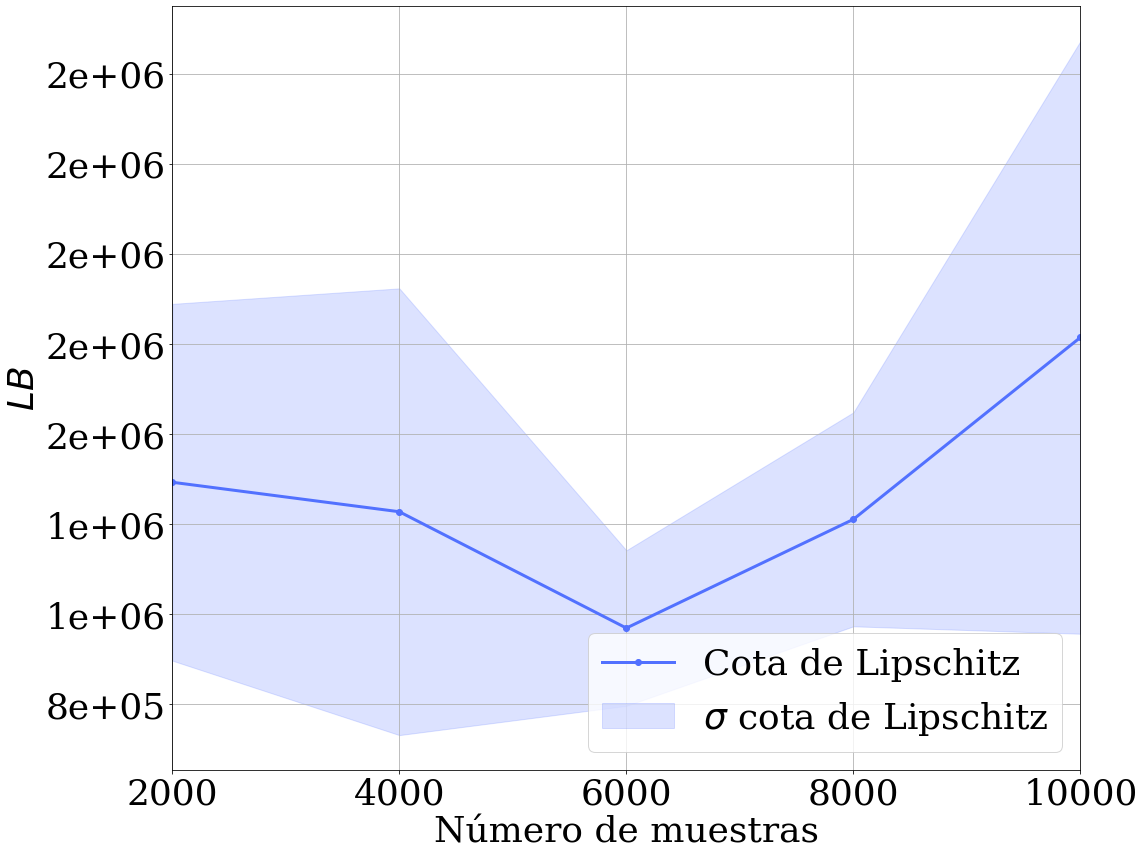

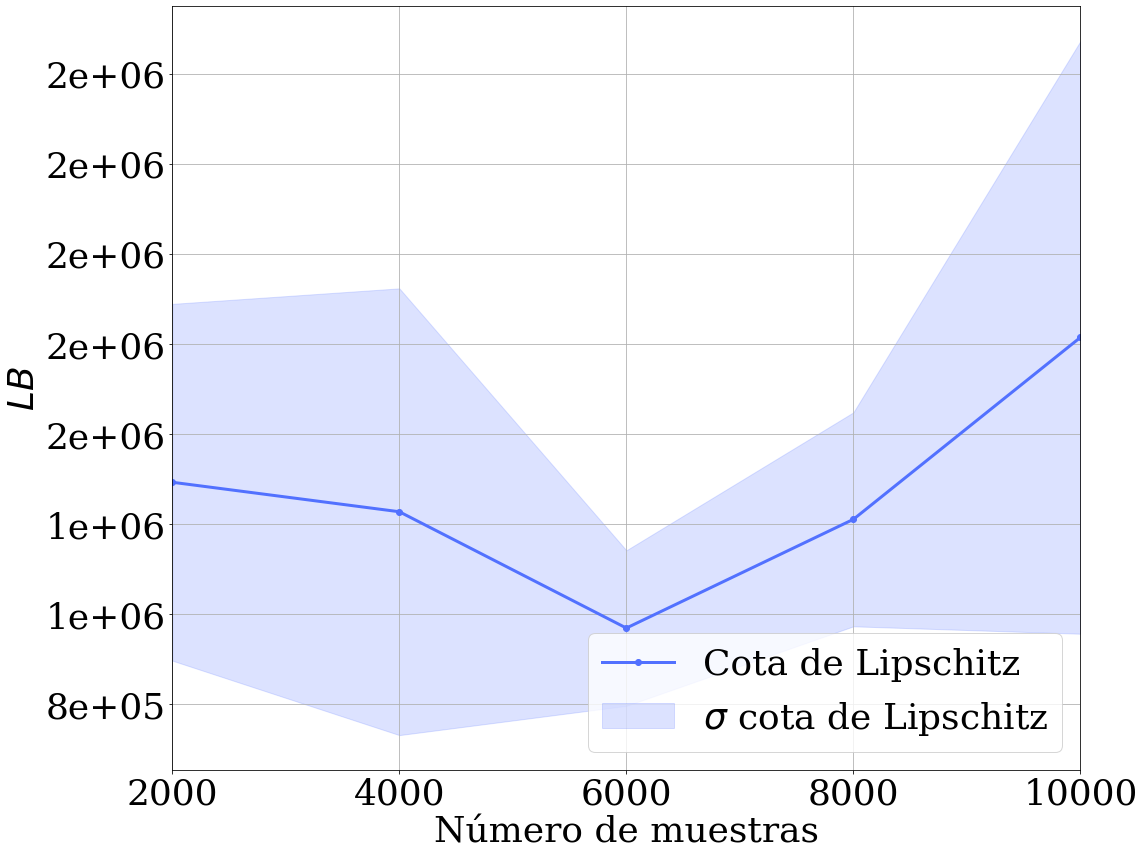

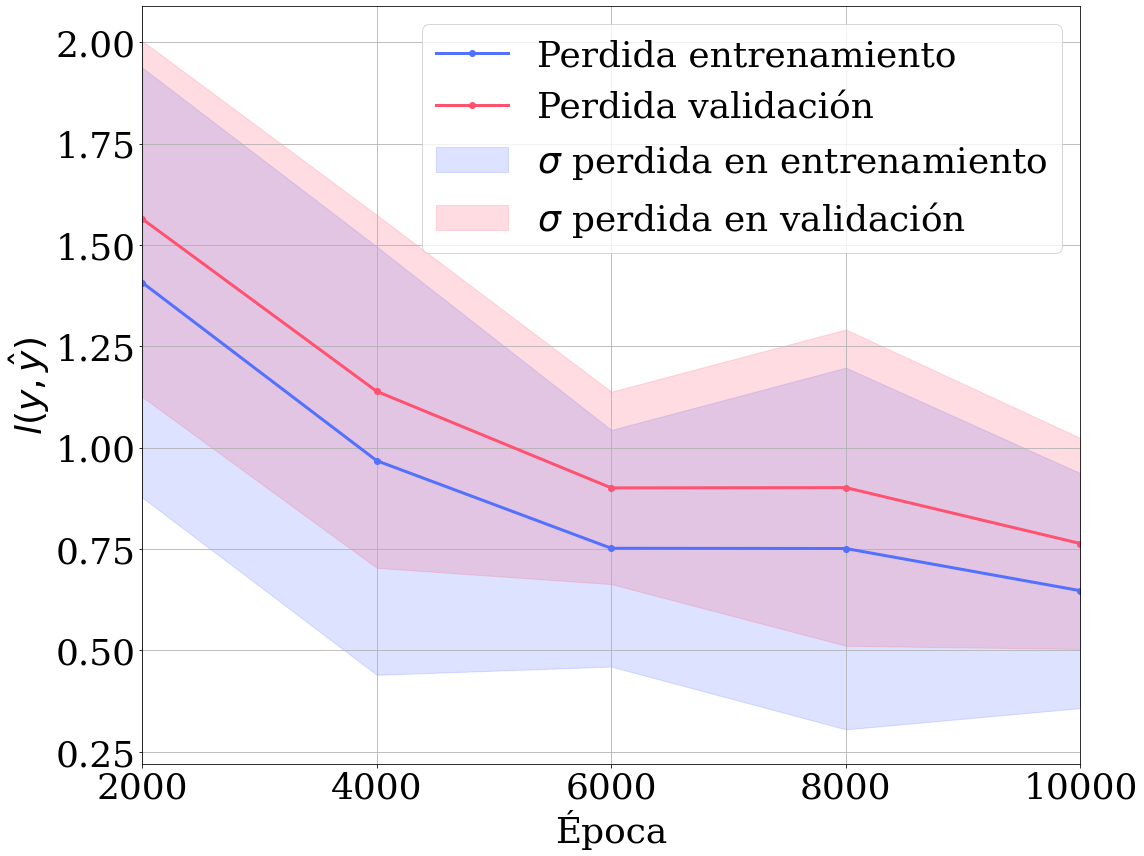

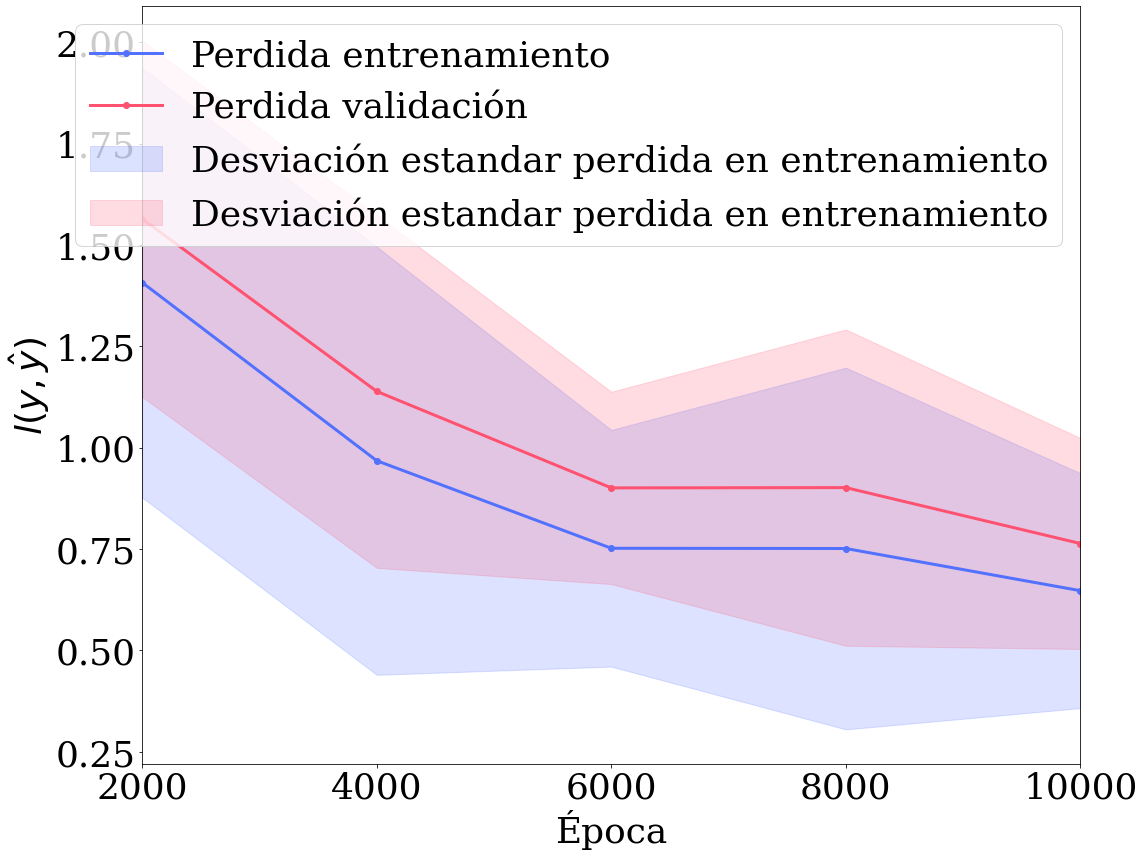

In [ ]:
sampleSizes = np.arange(0.2,1.2,0.2)
numberSamples = len(sampleSizes)
skips = [2, 4, 6, 8, 10, 12]
n_epochs = 30
resultGeneralSample = {}
for skip in skips:

  k_index_sample = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}

  for sampleSize in sampleSizes:
    if sampleSize == 1:
      X_train_sample = X_train
      y_train_sample = y_train
      y_train_onehot_sample = y_train_onehot
    else:
      shuffleSplitGenerator = ShuffleSplit(n_splits=1, train_size = sampleSize, 
                                        test_size = 0.1, random_state=0)
    
      for train_index_s, test_size_s in shuffleSplitGenerator.split(X_train):
        X_train_sample = X_train[train_index_s]
        y_train_sample = y_train[train_index_s]
        y_train_onehot_sample = y_train_onehot[train_index_s]
      ###
    k_index = 0
    loss_train = np.zeros(shape=(5,), dtype=np.float32)
    acc_train = np.zeros(shape=(5,), dtype=np.float32)
    loss_val = np.zeros(shape=(5,))
    acc_val = np.zeros(shape=(5,))
    LB = np.zeros(shape=(5,))

    print(f'Modelo : {skip} saltos residuales')

    kf = KFold(n_splits=5, shuffle=False)

    print(f'Número de K-folds: {kf}')
    print(f'\nIniciando Entrenamiento Validación Cruzada')
    print(f'\n ----')


    for train_index, test_index in kf.split(X_train_sample):
      
      generator = DataGenerator(images=X_train_sample[train_index], 
                                labels=y_train_sample[train_index], 
                                batch_size=100, shuffle=True)
      n_batches = len(generator)
      
      optimizer = tf.keras.optimizers.SGD()
      ce_loss = tf.keras.losses.CategoricalCrossentropy()
      model = load_model(skip,0)
      
      for epoch in range(n_epochs):
        for batch in range(n_batches):
          x, y = generator[batch]
          with tf.GradientTape() as tape: # Forward pass
            y_ = model(x, training=True)
            loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
          
          grad = tape.gradient(loss, model.trainable_variables)
          optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
        generator.on_epoch_end()

      
      y_ = model(X_train_sample[train_index])
      loss_train[k_index] = ce_loss(y_true=y_train_onehot_sample[train_index], y_pred=y_).numpy()
      acc_train[k_index] = sklearn.metrics.accuracy_score(y_true=y_train_sample[train_index], 
                                                        y_pred=np.argmax(y_, axis=-1))

      y_ = model(X_train_sample[test_index]) # Validation predictions
      loss_val[k_index] = ce_loss(y_true=y_train_onehot_sample[test_index], y_pred=y_).numpy()
      acc_val[k_index] = sklearn.metrics.accuracy_score(y_true=y_train_sample[test_index], 
                                                        y_pred=np.argmax(y_, axis=-1))

      
      LB[k_index] = lipschitz_bound(model.get_weights())
      
      k_index += 1

    Kf_eval_train_M0[k_index_sample] = acc_train
    Kf_eval_val_M0[k_index_sample] = acc_val
    Kf_LB_M0[k_index_sample] = LB
    Kf_loss[k_index_sample] = loss_train
    Kf_loss_val[k_index_sample] = loss_val
    k_index_sample += 1


  epoch_vec = 10000*np.arange(0.2,1.2,0.2) # asi 
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 0).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 0).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 0).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 0).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0
    
  graphAccSample(skip)
  graphGridAccSample(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 0).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 0).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  graphGridLipschtizSample(skip)
  graphLipschtizSample(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 0).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 0).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 0).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 0).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  graphGridLossSample(skip)
  graphLossSample(skip)

  resultGeneralSample[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, Kf_loss, Kf_loss_val, Kf_LB_M0]

pd.DataFrame.to_csv(pd.DataFrame(resultGeneralSample), 'ResultadosExperimentoSampleA.csv')
